[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 1. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 1. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 1. 0.]]


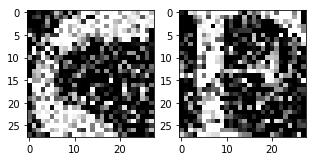

In [10]:
# 데이터 불러오기 
from matplotlib import pyplot as plt
import numpy as np
import gzip
from keras.utils import np_utils
%matplotlib inline

# 이미지 데이터 불러오기 : gzip파일일 경우 
def extract_data(filename,num_images):
    # gzip 파일 열어서 하나씩 가져오기
    with gzip.open(filename) as bytestream:
        bytestream.read(16)  # read size − This is the number of bytes to be read from the file.
        buf = bytestream.read(28 * 28 * num_images) # 파일 읽어와서 buf 에 넣기 
        data = np.frombuffer(buf,dtype=np.uint8).astype(np.float32) # flot32 로 변경해서 np.buffer에 넣기 
        data = data.reshape(num_images,28,28) # 변환한 이미지 데이터 반환하기 
        return data

train_data = extract_data('C:\\Users\\HyunA\\PycharmProjects\\CNN_Deeplearning\\Data\\Dataset\\notMNIST-to-MNIST-master\\notMNIST-to-MNIST-master\\train-images-idx3-ubyte.gz',60000)
test_data = extract_data('C:\\Users\\HyunA\\PycharmProjects\\CNN_Deeplearning\\Data\\Dataset\\notMNIST-to-MNIST-master\\notMNIST-to-MNIST-master\\t10k-images-idx3-ubyte.gz',10000)

# 라벨 데이터 불러오기 
def extract_labels(filename,num_images):
    # gzip 파일 열어서 하나씩 가져오기
    with gzip.open(filename) as bytestream:
        bytestream.read(8)
        buf = bytestream.read(1*num_images) 
        labels = np.frombuffer(buf,dtype=np.uint8).astype(np.int64)
        return labels
train_labels = extract_labels('C:\\Users\\HyunA\\PycharmProjects\\CNN_Deeplearning\\Data\\Dataset\\notMNIST-to-MNIST-master\\notMNIST-to-MNIST-master\\train-labels-idx1-ubyte.gz',60000)
test_labels = extract_labels('C:\\Users\\HyunA\\PycharmProjects\\CNN_Deeplearning\\Data\\Dataset\\notMNIST-to-MNIST-master\\notMNIST-to-MNIST-master\\t10k-labels-idx1-ubyte.gz',10000)


# create dictionary of target classes 
label_dict = {
    0:'A',
    1:'B',
    2:'C',
    3:'D',
    4:'E',
    5:'F',
    6:'G',
    7:'H',
    8:'I',
    9:'J'
}

train_data = train_data.reshape(-1,28,28,1)
test_data = test_data.reshape(-1,28,28,1)

# 0-1 사이 값으로 rescale 하기
# np.max(train_data),np.max(test_data)

train_data = train_data/np.max(train_data)
test_data = test_data/np.max(test_data)


# train , validation 데이터 분리 
from sklearn.model_selection import train_test_split

train_X, valid_X, train_ground,valid_ground = train_test_split(train_data,train_labels,test_size=0.2, random_state=13)

train_labels_categorical = np_utils.to_categorical(train_ground,10)
valid_labels_categorical = np_utils.to_categorical(valid_ground,10)
test_labels_categorical = np_utils.to_categorical(test_labels,10)

# noise 추가
noise_factor = 0.5
x_train_noisy = train_X + noise_factor * np.random.normal(loc=0.0,scale=1.0, size = train_X.shape)
x_valid_noisy = valid_X + noise_factor * np.random.normal(loc=0.0,scale=1.0, size = valid_X.shape)
x_test_noisy = test_data + noise_factor* np.random.normal(loc=0.0,scale=1.0, size = test_data.shape)

x_train_noisy = np.clip(x_train_noisy,0.,1.)
x_valid_noisy = np.clip(x_valid_noisy,0.,1.)
x_test_noisy = np.clip(x_test_noisy,0.,1.)


plt.figure(figsize=[5,5])

# display the first image in training data
plt.subplot(121)
curr_img = np.reshape(x_train_noisy[1],(28,28))
plt.imshow(curr_img, cmap='gray')

# display the first image in testing data
plt.subplot(122)
curr_img = np.reshape(x_test_noisy[1],(28,28))
plt.imshow(curr_img, cmap='gray')

print(train_labels_categorical)

In [18]:
from keras import Model
from keras.layers import Input,Conv2D,MaxPool2D,UpSampling2D,Dense,Dropout,Flatten
from keras.models import Model
from keras.optimizers import  RMSprop

# denosing autoencoder network
batch_size = 128
epoch = 10
inChannel = 1
x, y = 28,28
input_img = Input(shape=(x,y,inChannel))

def CAE_Class(input_img):
    # encoder
    conv1 = Conv2D(32,(3,3),activation='relu',padding='same',name='conv1')(input_img)
    pool1 = MaxPool2D(pool_size=(2,2),name='pool1')(conv1)
    conv2 = Conv2D(64,(3,3), activation='relu', padding='same', name='conv2')(pool1)
    pool2 = MaxPool2D(pool_size=(2,2),name='pool2')(conv2)
    conv3 = Conv2D(128,(3,3),activation='relu', padding='same',name='conv3')(pool2)
    
    
    # decoder
    # conv4  = Conv2D(128 ,(3,3), activation='relu', padding='same',name='conv4')(conv3)
    # up1 = UpSampling2D((2,2),name='up1')(conv4)
    # conv5 = Conv2D(64,(3,3),activation='relu', padding='same',name='conv5')(up1)
    # up2 = UpSampling2D((2,2),name='up2')(conv5)
    # decoded = Conv2D(1,(3,3), activation='sigmoid', padding='same',name='decoded')(up2)
    
    # classification
    pool3 = MaxPool2D(pool_size=(2,2), name='pool3')(conv3)
    flatten = Flatten()(pool3)
    dense1 = Dense(200, activation='relu', name= 'dense1')(flatten)
    dropout = Dropout(0.5,name='dropout')(dense1)
    dense2 = Dense(10, activation = 'softmax', name='dense2' )(dropout)
    return dense2

CAE_Class  = Model(input_img, CAE_Class(input_img))

# 가중치 업로드 
CAE_Class.load_weights('C:\\Users\\HyunA\\PycharmProjects\\CNN_Deeplearning\\Models\\AutoEncoder_tutorial\\denosinge_autoencoder_weights.h5',by_name=True )




In [19]:
CAE_Class.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_9 (InputLayer)         (None, 28, 28, 1)         0         
_________________________________________________________________
conv1 (Conv2D)               (None, 28, 28, 32)        320       
_________________________________________________________________
pool1 (MaxPooling2D)         (None, 14, 14, 32)        0         
_________________________________________________________________
conv2 (Conv2D)               (None, 14, 14, 64)        18496     
_________________________________________________________________
pool2 (MaxPooling2D)         (None, 7, 7, 64)          0         
_________________________________________________________________
conv3 (Conv2D)               (None, 7, 7, 128)         73856     
_________________________________________________________________
pool3 (MaxPooling2D)         (None, 3, 3, 128)         0         
__________

In [20]:
# 분류 학습하기 
# 오토인코더로 학습한 가중치 frozen 
for layer in CAE_Class.layers[:6]:
    layer.trainable = False


# 출력층 부분 학습 
CAE_Class.compile(loss='categorical_crossentropy', optimizer = RMSprop(), metrics=['accuracy'])

cae_train = CAE_Class.fit(train_X,train_labels_categorical,
              epochs=epoch,
              batch_size=batch_size,
              validation_data=(valid_X,valid_labels_categorical),
              verbose = 1
              )



Train on 48000 samples, validate on 12000 samples
Epoch 1/10


  128/48000 [..............................] - ETA: 2:43 - loss: 2.4778 - acc: 0.0938

  256/48000 [..............................] - ETA: 1:42 - loss: 2.4327 - acc: 0.1055

  384/48000 [..............................] - ETA: 1:19 - loss: 2.2800 - acc: 0.1719

  512/48000 [..............................] - ETA: 1:07 - loss: 2.1455 - acc: 0.2266

  640/48000 [..............................] - ETA: 59s - loss: 2.0194 - acc: 0.2797 

  768/48000 [..............................] - ETA: 54s - loss: 1.9204 - acc: 0.3203

  896/48000 [..............................] - ETA: 50s - loss: 1.8559 - acc: 0.3382

 1024/48000 [..............................] - ETA: 48s - loss: 1.7951 - acc: 0.3682

 1152/48000 [..............................] - ETA: 46s - loss: 1.7207 - acc: 0.4010

 1280/48000 [..............................] - ETA: 44s - loss: 1.6692 - acc: 0.4219

 1408/48000 [..............................] - ETA: 43s - loss: 1.6307 - acc: 0.4403

 1536/48000 [..............................] - ETA: 42s - loss: 1.5881 - acc: 0.4557

 1664/48000 [>.............................] - ETA: 41s - loss: 1.5539 - acc: 0.4700

 1792/48000 [>.............................] - ETA: 40s - loss: 1.5378 - acc: 0.4810

 1920/48000 [>.............................] - ETA: 39s - loss: 1.5202 - acc: 0.4891

 2048/48000 [>.............................] - ETA: 38s - loss: 1.4902 - acc: 0.5010

 2176/48000 [>.............................] - ETA: 37s - loss: 1.4795 - acc: 0.5074

 2304/48000 [>.............................] - ETA: 37s - loss: 1.4518 - acc: 0.5174

 2432/48000 [>.............................] - ETA: 36s - loss: 1.4418 - acc: 0.5226

 2560/48000 [>.............................] - ETA: 36s - loss: 1.4258 - acc: 0.5289

 2688/48000 [>.............................] - ETA: 35s - loss: 1.4111 - acc: 0.5335

 2816/48000 [>.............................] - ETA: 35s - loss: 1.3977 - acc: 0.5394

 2944/48000 [>.............................] - ETA: 35s - loss: 1.3794 - acc: 0.5469

 3072/48000 [>.............................] - ETA: 34s - loss: 1.3677 - acc: 0.5521

 3200/48000 [=>............................] - ETA: 34s - loss: 1.3503 - acc: 0.5591

 3328/48000 [=>............................] - ETA: 34s - loss: 1.3354 - acc: 0.5655

 3456/48000 [=>............................] - ETA: 33s - loss: 1.3202 - acc: 0.5741

 3584/48000 [=>............................] - ETA: 33s - loss: 1.3131 - acc: 0.5781

 3712/48000 [=>............................] - ETA: 32s - loss: 1.2972 - acc: 0.5849

 3840/48000 [=>............................] - ETA: 32s - loss: 1.2867 - acc: 0.5893

 3968/48000 [=>............................] - ETA: 32s - loss: 1.2699 - acc: 0.5958

 4096/48000 [=>............................] - ETA: 31s - loss: 1.2636 - acc: 0.5986

 4224/48000 [=>............................] - ETA: 31s - loss: 1.2504 - acc: 0.6025

 4352/48000 [=>............................] - ETA: 31s - loss: 1.2359 - acc: 0.6075

 4480/48000 [=>............................] - ETA: 30s - loss: 1.2259 - acc: 0.6112

 4608/48000 [=>............................] - ETA: 30s - loss: 1.2158 - acc: 0.6148

 4736/48000 [=>............................] - ETA: 30s - loss: 1.2075 - acc: 0.6178

 4864/48000 [==>...........................] - ETA: 30s - loss: 1.1988 - acc: 0.6197

 4992/48000 [==>...........................] - ETA: 29s - loss: 1.1898 - acc: 0.6236

 5120/48000 [==>...........................] - ETA: 29s - loss: 1.1777 - acc: 0.6279

 5248/48000 [==>...........................] - ETA: 29s - loss: 1.1700 - acc: 0.6305

 5376/48000 [==>...........................] - ETA: 29s - loss: 1.1629 - acc: 0.6330

 5504/48000 [==>...........................] - ETA: 29s - loss: 1.1554 - acc: 0.6355

 5632/48000 [==>...........................] - ETA: 28s - loss: 1.1490 - acc: 0.6376

 5760/48000 [==>...........................] - ETA: 28s - loss: 1.1445 - acc: 0.6394

 5888/48000 [==>...........................] - ETA: 28s - loss: 1.1370 - acc: 0.6418

 6016/48000 [==>...........................] - ETA: 28s - loss: 1.1333 - acc: 0.6439

 6144/48000 [==>...........................] - ETA: 27s - loss: 1.1260 - acc: 0.6468

 6272/48000 [==>...........................] - ETA: 27s - loss: 1.1233 - acc: 0.6478

 6400/48000 [===>..........................] - ETA: 27s - loss: 1.1182 - acc: 0.6502

 6528/48000 [===>..........................] - ETA: 27s - loss: 1.1120 - acc: 0.6530

 6656/48000 [===>..........................] - ETA: 27s - loss: 1.1050 - acc: 0.6550

 6784/48000 [===>..........................] - ETA: 27s - loss: 1.1008 - acc: 0.6564

 6912/48000 [===>..........................] - ETA: 26s - loss: 1.0946 - acc: 0.6581

 7040/48000 [===>..........................] - ETA: 26s - loss: 1.0884 - acc: 0.6602

 7168/48000 [===>..........................] - ETA: 26s - loss: 1.0816 - acc: 0.6622

 7296/48000 [===>..........................] - ETA: 26s - loss: 1.0742 - acc: 0.6643

 7424/48000 [===>..........................] - ETA: 26s - loss: 1.0668 - acc: 0.6666

 7552/48000 [===>..........................] - ETA: 26s - loss: 1.0628 - acc: 0.6680

 7680/48000 [===>..........................] - ETA: 26s - loss: 1.0587 - acc: 0.6690

 7808/48000 [===>..........................] - ETA: 25s - loss: 1.0566 - acc: 0.6706

 7936/48000 [===>..........................] - ETA: 25s - loss: 1.0516 - acc: 0.6720

 8064/48000 [====>.........................] - ETA: 25s - loss: 1.0466 - acc: 0.6736

 8192/48000 [====>.........................] - ETA: 25s - loss: 1.0405 - acc: 0.6753

 8320/48000 [====>.........................] - ETA: 25s - loss: 1.0362 - acc: 0.6770

 8448/48000 [====>.........................] - ETA: 25s - loss: 1.0313 - acc: 0.6786

 8576/48000 [====>.........................] - ETA: 25s - loss: 1.0261 - acc: 0.6799

 8704/48000 [====>.........................] - ETA: 24s - loss: 1.0202 - acc: 0.6821

 8832/48000 [====>.........................] - ETA: 24s - loss: 1.0161 - acc: 0.6837

 8960/48000 [====>.........................] - ETA: 24s - loss: 1.0125 - acc: 0.6857

 9088/48000 [====>.........................] - ETA: 24s - loss: 1.0118 - acc: 0.6857

 9216/48000 [====>.........................] - ETA: 24s - loss: 1.0058 - acc: 0.6878

 9344/48000 [====>.........................] - ETA: 24s - loss: 1.0011 - acc: 0.6894

 9472/48000 [====>.........................] - ETA: 24s - loss: 0.9972 - acc: 0.6908

 9600/48000 [=====>........................] - ETA: 24s - loss: 0.9941 - acc: 0.6917

 9728/48000 [=====>........................] - ETA: 23s - loss: 0.9921 - acc: 0.6924

 9856/48000 [=====>........................] - ETA: 23s - loss: 0.9879 - acc: 0.6941

 9984/48000 [=====>........................] - ETA: 23s - loss: 0.9838 - acc: 0.6954

10112/48000 [=====>........................] - ETA: 23s - loss: 0.9840 - acc: 0.6953

10240/48000 [=====>........................] - ETA: 23s - loss: 0.9809 - acc: 0.6966

10368/48000 [=====>........................] - ETA: 23s - loss: 0.9776 - acc: 0.6978

10496/48000 [=====>........................] - ETA: 23s - loss: 0.9769 - acc: 0.6980

10624/48000 [=====>........................] - ETA: 23s - loss: 0.9735 - acc: 0.6988

10752/48000 [=====>........................] - ETA: 22s - loss: 0.9682 - acc: 0.7004

10880/48000 [=====>........................] - ETA: 22s - loss: 0.9652 - acc: 0.7014

11008/48000 [=====>........................] - ETA: 22s - loss: 0.9630 - acc: 0.7022

11136/48000 [=====>........................] - ETA: 22s - loss: 0.9575 - acc: 0.7041

11264/48000 [======>.......................] - ETA: 22s - loss: 0.9552 - acc: 0.7047

11392/48000 [======>.......................] - ETA: 22s - loss: 0.9531 - acc: 0.7058

11520/48000 [======>.......................] - ETA: 22s - loss: 0.9507 - acc: 0.7064

11648/48000 [======>.......................] - ETA: 22s - loss: 0.9488 - acc: 0.7074

11776/48000 [======>.......................] - ETA: 22s - loss: 0.9451 - acc: 0.7086

11904/48000 [======>.......................] - ETA: 22s - loss: 0.9420 - acc: 0.7097

12032/48000 [======>.......................] - ETA: 21s - loss: 0.9388 - acc: 0.7109

12160/48000 [======>.......................] - ETA: 21s - loss: 0.9364 - acc: 0.7118

12288/48000 [======>.......................] - ETA: 21s - loss: 0.9341 - acc: 0.7131

12416/48000 [======>.......................] - ETA: 21s - loss: 0.9329 - acc: 0.7134

12544/48000 [======>.......................] - ETA: 21s - loss: 0.9321 - acc: 0.7137

12672/48000 [======>.......................] - ETA: 21s - loss: 0.9295 - acc: 0.7144

12800/48000 [=======>......................] - ETA: 21s - loss: 0.9273 - acc: 0.7153

12928/48000 [=======>......................] - ETA: 21s - loss: 0.9260 - acc: 0.7161

13056/48000 [=======>......................] - ETA: 21s - loss: 0.9225 - acc: 0.7172

13184/48000 [=======>......................] - ETA: 21s - loss: 0.9212 - acc: 0.7177

13312/48000 [=======>......................] - ETA: 21s - loss: 0.9178 - acc: 0.7186

13440/48000 [=======>......................] - ETA: 20s - loss: 0.9158 - acc: 0.7196

13568/48000 [=======>......................] - ETA: 20s - loss: 0.9129 - acc: 0.7205

13696/48000 [=======>......................] - ETA: 20s - loss: 0.9102 - acc: 0.7212

13824/48000 [=======>......................] - ETA: 20s - loss: 0.9075 - acc: 0.7220

13952/48000 [=======>......................] - ETA: 20s - loss: 0.9054 - acc: 0.7226

14080/48000 [=======>......................] - ETA: 20s - loss: 0.9032 - acc: 0.7237

14208/48000 [=======>......................] - ETA: 20s - loss: 0.9023 - acc: 0.7239

14336/48000 [=======>......................] - ETA: 20s - loss: 0.9003 - acc: 0.7250

14464/48000 [========>.....................] - ETA: 20s - loss: 0.8970 - acc: 0.7259

14592/48000 [========>.....................] - ETA: 20s - loss: 0.8970 - acc: 0.7257

14720/48000 [========>.....................] - ETA: 19s - loss: 0.8968 - acc: 0.7256

14848/48000 [========>.....................] - ETA: 19s - loss: 0.8951 - acc: 0.7261

14976/48000 [========>.....................] - ETA: 19s - loss: 0.8919 - acc: 0.7271

15104/48000 [========>.....................] - ETA: 19s - loss: 0.8906 - acc: 0.7278

15232/48000 [========>.....................] - ETA: 19s - loss: 0.8884 - acc: 0.7287

15360/48000 [========>.....................] - ETA: 19s - loss: 0.8848 - acc: 0.7298

15488/48000 [========>.....................] - ETA: 19s - loss: 0.8825 - acc: 0.7306

15616/48000 [========>.....................] - ETA: 19s - loss: 0.8809 - acc: 0.7312

15744/48000 [========>.....................] - ETA: 19s - loss: 0.8793 - acc: 0.7318

15872/48000 [========>.....................] - ETA: 19s - loss: 0.8771 - acc: 0.7324

16000/48000 [=========>....................] - ETA: 19s - loss: 0.8753 - acc: 0.7329

16128/48000 [=========>....................] - ETA: 18s - loss: 0.8730 - acc: 0.7336

16256/48000 [=========>....................] - ETA: 18s - loss: 0.8709 - acc: 0.7343

16384/48000 [=========>....................] - ETA: 18s - loss: 0.8690 - acc: 0.7349

16512/48000 [=========>....................] - ETA: 18s - loss: 0.8683 - acc: 0.7354

16640/48000 [=========>....................] - ETA: 18s - loss: 0.8662 - acc: 0.7365

16768/48000 [=========>....................] - ETA: 18s - loss: 0.8647 - acc: 0.7372

16896/48000 [=========>....................] - ETA: 18s - loss: 0.8636 - acc: 0.7378

17024/48000 [=========>....................] - ETA: 18s - loss: 0.8620 - acc: 0.7381

17152/48000 [=========>....................] - ETA: 18s - loss: 0.8606 - acc: 0.7385

17280/48000 [=========>....................] - ETA: 18s - loss: 0.8604 - acc: 0.7385

17408/48000 [=========>....................] - ETA: 18s - loss: 0.8600 - acc: 0.7385

17536/48000 [=========>....................] - ETA: 18s - loss: 0.8583 - acc: 0.7391

17664/48000 [==========>...................] - ETA: 17s - loss: 0.8568 - acc: 0.7392

17792/48000 [==========>...................] - ETA: 17s - loss: 0.8543 - acc: 0.7401

17920/48000 [==========>...................] - ETA: 17s - loss: 0.8541 - acc: 0.7405

18048/48000 [==========>...................] - ETA: 17s - loss: 0.8527 - acc: 0.7410

18176/48000 [==========>...................] - ETA: 17s - loss: 0.8511 - acc: 0.7414

18304/48000 [==========>...................] - ETA: 17s - loss: 0.8505 - acc: 0.7416

18432/48000 [==========>...................] - ETA: 17s - loss: 0.8496 - acc: 0.7419

18560/48000 [==========>...................] - ETA: 17s - loss: 0.8479 - acc: 0.7425

18688/48000 [==========>...................] - ETA: 17s - loss: 0.8468 - acc: 0.7429

18816/48000 [==========>...................] - ETA: 17s - loss: 0.8468 - acc: 0.7431

18944/48000 [==========>...................] - ETA: 17s - loss: 0.8451 - acc: 0.7436

19072/48000 [==========>...................] - ETA: 17s - loss: 0.8447 - acc: 0.7438

19200/48000 [===========>..................] - ETA: 16s - loss: 0.8434 - acc: 0.7441

19328/48000 [===========>..................] - ETA: 16s - loss: 0.8429 - acc: 0.7445

19456/48000 [===========>..................] - ETA: 16s - loss: 0.8417 - acc: 0.7447

19584/48000 [===========>..................] - ETA: 16s - loss: 0.8404 - acc: 0.7453

19712/48000 [===========>..................] - ETA: 16s - loss: 0.8387 - acc: 0.7459

19840/48000 [===========>..................] - ETA: 16s - loss: 0.8387 - acc: 0.7462

19968/48000 [===========>..................] - ETA: 16s - loss: 0.8378 - acc: 0.7463

20096/48000 [===========>..................] - ETA: 16s - loss: 0.8361 - acc: 0.7469

20224/48000 [===========>..................] - ETA: 16s - loss: 0.8353 - acc: 0.7472

20352/48000 [===========>..................] - ETA: 16s - loss: 0.8344 - acc: 0.7474

20480/48000 [===========>..................] - ETA: 16s - loss: 0.8339 - acc: 0.7478

20608/48000 [===========>..................] - ETA: 16s - loss: 0.8330 - acc: 0.7483

20736/48000 [===========>..................] - ETA: 15s - loss: 0.8329 - acc: 0.7484

20864/48000 [============>.................] - ETA: 15s - loss: 0.8309 - acc: 0.7489

20992/48000 [============>.................] - ETA: 15s - loss: 0.8288 - acc: 0.7498

21120/48000 [============>.................] - ETA: 15s - loss: 0.8279 - acc: 0.7502

21248/48000 [============>.................] - ETA: 15s - loss: 0.8268 - acc: 0.7505

21376/48000 [============>.................] - ETA: 15s - loss: 0.8259 - acc: 0.7509

21504/48000 [============>.................] - ETA: 15s - loss: 0.8240 - acc: 0.7515

21632/48000 [============>.................] - ETA: 15s - loss: 0.8218 - acc: 0.7522

21760/48000 [============>.................] - ETA: 15s - loss: 0.8207 - acc: 0.7523

21888/48000 [============>.................] - ETA: 15s - loss: 0.8200 - acc: 0.7524

22016/48000 [============>.................] - ETA: 15s - loss: 0.8182 - acc: 0.7531

22144/48000 [============>.................] - ETA: 15s - loss: 0.8178 - acc: 0.7534

22272/48000 [============>.................] - ETA: 14s - loss: 0.8172 - acc: 0.7539

22400/48000 [=============>................] - ETA: 14s - loss: 0.8156 - acc: 0.7544

22528/48000 [=============>................] - ETA: 14s - loss: 0.8141 - acc: 0.7548

22656/48000 [=============>................] - ETA: 14s - loss: 0.8135 - acc: 0.7549

22784/48000 [=============>................] - ETA: 14s - loss: 0.8126 - acc: 0.7552

22912/48000 [=============>................] - ETA: 14s - loss: 0.8116 - acc: 0.7557

23040/48000 [=============>................] - ETA: 14s - loss: 0.8112 - acc: 0.7559

23168/48000 [=============>................] - ETA: 14s - loss: 0.8097 - acc: 0.7563

23296/48000 [=============>................] - ETA: 14s - loss: 0.8086 - acc: 0.7564

23424/48000 [=============>................] - ETA: 14s - loss: 0.8073 - acc: 0.7567

23552/48000 [=============>................] - ETA: 14s - loss: 0.8062 - acc: 0.7570

23680/48000 [=============>................] - ETA: 14s - loss: 0.8055 - acc: 0.7571

23808/48000 [=============>................] - ETA: 14s - loss: 0.8046 - acc: 0.7575

23936/48000 [=============>................] - ETA: 13s - loss: 0.8044 - acc: 0.7576

24064/48000 [==============>...............] - ETA: 13s - loss: 0.8033 - acc: 0.7579

24192/48000 [==============>...............] - ETA: 13s - loss: 0.8018 - acc: 0.7585

24320/48000 [==============>...............] - ETA: 13s - loss: 0.8010 - acc: 0.7588

24448/48000 [==============>...............] - ETA: 13s - loss: 0.8001 - acc: 0.7590

24576/48000 [==============>...............] - ETA: 13s - loss: 0.7989 - acc: 0.7594

24704/48000 [==============>...............] - ETA: 13s - loss: 0.7981 - acc: 0.7596

24832/48000 [==============>...............] - ETA: 13s - loss: 0.7971 - acc: 0.7599

24960/48000 [==============>...............] - ETA: 13s - loss: 0.7961 - acc: 0.7602

25088/48000 [==============>...............] - ETA: 13s - loss: 0.7952 - acc: 0.7605

25216/48000 [==============>...............] - ETA: 13s - loss: 0.7944 - acc: 0.7607

25344/48000 [==============>...............] - ETA: 13s - loss: 0.7937 - acc: 0.7608

25472/48000 [==============>...............] - ETA: 13s - loss: 0.7929 - acc: 0.7610

25600/48000 [===============>..............] - ETA: 12s - loss: 0.7921 - acc: 0.7612

25728/48000 [===============>..............] - ETA: 12s - loss: 0.7910 - acc: 0.7615

25856/48000 [===============>..............] - ETA: 12s - loss: 0.7910 - acc: 0.7616

25984/48000 [===============>..............] - ETA: 12s - loss: 0.7896 - acc: 0.7623

26112/48000 [===============>..............] - ETA: 12s - loss: 0.7879 - acc: 0.7630

26240/48000 [===============>..............] - ETA: 12s - loss: 0.7865 - acc: 0.7633

26368/48000 [===============>..............] - ETA: 12s - loss: 0.7854 - acc: 0.7636

26496/48000 [===============>..............] - ETA: 12s - loss: 0.7852 - acc: 0.7637

26624/48000 [===============>..............] - ETA: 12s - loss: 0.7838 - acc: 0.7642

26752/48000 [===============>..............] - ETA: 12s - loss: 0.7832 - acc: 0.7644

26880/48000 [===============>..............] - ETA: 12s - loss: 0.7829 - acc: 0.7645

27008/48000 [===============>..............] - ETA: 12s - loss: 0.7822 - acc: 0.7648

27136/48000 [===============>..............] - ETA: 12s - loss: 0.7813 - acc: 0.7652

27264/48000 [================>.............] - ETA: 11s - loss: 0.7813 - acc: 0.7653

27392/48000 [================>.............] - ETA: 11s - loss: 0.7802 - acc: 0.7656

27520/48000 [================>.............] - ETA: 11s - loss: 0.7793 - acc: 0.7660

27648/48000 [================>.............] - ETA: 11s - loss: 0.7782 - acc: 0.7664

27776/48000 [================>.............] - ETA: 11s - loss: 0.7779 - acc: 0.7663

27904/48000 [================>.............] - ETA: 11s - loss: 0.7770 - acc: 0.7665

28032/48000 [================>.............] - ETA: 11s - loss: 0.7766 - acc: 0.7666

28160/48000 [================>.............] - ETA: 11s - loss: 0.7765 - acc: 0.7667

28288/48000 [================>.............] - ETA: 11s - loss: 0.7755 - acc: 0.7669

28416/48000 [================>.............] - ETA: 11s - loss: 0.7749 - acc: 0.7671

28544/48000 [================>.............] - ETA: 11s - loss: 0.7749 - acc: 0.7672

28672/48000 [================>.............] - ETA: 11s - loss: 0.7736 - acc: 0.7675

28800/48000 [=================>............] - ETA: 11s - loss: 0.7731 - acc: 0.7677

28928/48000 [=================>............] - ETA: 10s - loss: 0.7720 - acc: 0.7682

29056/48000 [=================>............] - ETA: 10s - loss: 0.7707 - acc: 0.7687

29184/48000 [=================>............] - ETA: 10s - loss: 0.7697 - acc: 0.7689

29312/48000 [=================>............] - ETA: 10s - loss: 0.7692 - acc: 0.7691

29440/48000 [=================>............] - ETA: 10s - loss: 0.7685 - acc: 0.7694

29568/48000 [=================>............] - ETA: 10s - loss: 0.7682 - acc: 0.7694

29696/48000 [=================>............] - ETA: 10s - loss: 0.7680 - acc: 0.7694

29824/48000 [=================>............] - ETA: 10s - loss: 0.7672 - acc: 0.7697

29952/48000 [=================>............] - ETA: 10s - loss: 0.7660 - acc: 0.7701

30080/48000 [=================>............] - ETA: 10s - loss: 0.7662 - acc: 0.7702

30208/48000 [=================>............] - ETA: 10s - loss: 0.7658 - acc: 0.7703

30336/48000 [=================>............] - ETA: 10s - loss: 0.7649 - acc: 0.7705

30464/48000 [==================>...........] - ETA: 10s - loss: 0.7646 - acc: 0.7707

30592/48000 [==================>...........] - ETA: 9s - loss: 0.7637 - acc: 0.7710 

30720/48000 [==================>...........] - ETA: 9s - loss: 0.7629 - acc: 0.7713

30848/48000 [==================>...........] - ETA: 9s - loss: 0.7625 - acc: 0.7713

30976/48000 [==================>...........] - ETA: 9s - loss: 0.7614 - acc: 0.7716

31104/48000 [==================>...........] - ETA: 9s - loss: 0.7611 - acc: 0.7718

31232/48000 [==================>...........] - ETA: 9s - loss: 0.7612 - acc: 0.7719

31360/48000 [==================>...........] - ETA: 9s - loss: 0.7602 - acc: 0.7722

31488/48000 [==================>...........] - ETA: 9s - loss: 0.7596 - acc: 0.7725

31616/48000 [==================>...........] - ETA: 9s - loss: 0.7582 - acc: 0.7729

31744/48000 [==================>...........] - ETA: 9s - loss: 0.7570 - acc: 0.7733

31872/48000 [==================>...........] - ETA: 9s - loss: 0.7568 - acc: 0.7735

32000/48000 [===================>..........] - ETA: 9s - loss: 0.7562 - acc: 0.7738

32128/48000 [===================>..........] - ETA: 9s - loss: 0.7549 - acc: 0.7742

32256/48000 [===================>..........] - ETA: 9s - loss: 0.7541 - acc: 0.7745

32384/48000 [===================>..........] - ETA: 8s - loss: 0.7541 - acc: 0.7745

32512/48000 [===================>..........] - ETA: 8s - loss: 0.7539 - acc: 0.7745

32640/48000 [===================>..........] - ETA: 8s - loss: 0.7535 - acc: 0.7746

32768/48000 [===================>..........] - ETA: 8s - loss: 0.7524 - acc: 0.7749

32896/48000 [===================>..........] - ETA: 8s - loss: 0.7519 - acc: 0.7750

33024/48000 [===================>..........] - ETA: 8s - loss: 0.7510 - acc: 0.7754

33152/48000 [===================>..........] - ETA: 8s - loss: 0.7501 - acc: 0.7756

33280/48000 [===================>..........] - ETA: 8s - loss: 0.7496 - acc: 0.7758

33408/48000 [===================>..........] - ETA: 8s - loss: 0.7487 - acc: 0.7760

33536/48000 [===================>..........] - ETA: 8s - loss: 0.7483 - acc: 0.7762

33664/48000 [====================>.........] - ETA: 8s - loss: 0.7477 - acc: 0.7764

33792/48000 [====================>.........] - ETA: 8s - loss: 0.7465 - acc: 0.7768

33920/48000 [====================>.........] - ETA: 8s - loss: 0.7462 - acc: 0.7768

34048/48000 [====================>.........] - ETA: 7s - loss: 0.7455 - acc: 0.7770

34176/48000 [====================>.........] - ETA: 7s - loss: 0.7449 - acc: 0.7772

34304/48000 [====================>.........] - ETA: 7s - loss: 0.7445 - acc: 0.7774

34432/48000 [====================>.........] - ETA: 7s - loss: 0.7437 - acc: 0.7776

34560/48000 [====================>.........] - ETA: 7s - loss: 0.7429 - acc: 0.7778

34688/48000 [====================>.........] - ETA: 7s - loss: 0.7420 - acc: 0.7782

34816/48000 [====================>.........] - ETA: 7s - loss: 0.7410 - acc: 0.7784

34944/48000 [====================>.........] - ETA: 7s - loss: 0.7402 - acc: 0.7786

35072/48000 [====================>.........] - ETA: 7s - loss: 0.7389 - acc: 0.7791

35200/48000 [=====================>........] - ETA: 7s - loss: 0.7385 - acc: 0.7793

35328/48000 [=====================>........] - ETA: 7s - loss: 0.7376 - acc: 0.7795

35456/48000 [=====================>........] - ETA: 7s - loss: 0.7367 - acc: 0.7797

35584/48000 [=====================>........] - ETA: 7s - loss: 0.7360 - acc: 0.7798

35712/48000 [=====================>........] - ETA: 7s - loss: 0.7359 - acc: 0.7798

35840/48000 [=====================>........] - ETA: 6s - loss: 0.7352 - acc: 0.7801

35968/48000 [=====================>........] - ETA: 6s - loss: 0.7344 - acc: 0.7803

36096/48000 [=====================>........] - ETA: 6s - loss: 0.7341 - acc: 0.7803

36224/48000 [=====================>........] - ETA: 6s - loss: 0.7336 - acc: 0.7803

36352/48000 [=====================>........] - ETA: 6s - loss: 0.7331 - acc: 0.7804

36480/48000 [=====================>........] - ETA: 6s - loss: 0.7326 - acc: 0.7805

36608/48000 [=====================>........] - ETA: 6s - loss: 0.7323 - acc: 0.7806

36736/48000 [=====================>........] - ETA: 6s - loss: 0.7317 - acc: 0.7807

36864/48000 [======================>.......] - ETA: 6s - loss: 0.7316 - acc: 0.7808

36992/48000 [======================>.......] - ETA: 6s - loss: 0.7316 - acc: 0.7809

37120/48000 [======================>.......] - ETA: 6s - loss: 0.7302 - acc: 0.7813

37248/48000 [======================>.......] - ETA: 6s - loss: 0.7296 - acc: 0.7815

37376/48000 [======================>.......] - ETA: 6s - loss: 0.7289 - acc: 0.7817

37504/48000 [======================>.......] - ETA: 5s - loss: 0.7288 - acc: 0.7816

37632/48000 [======================>.......] - ETA: 5s - loss: 0.7278 - acc: 0.7819

37760/48000 [======================>.......] - ETA: 5s - loss: 0.7270 - acc: 0.7821

37888/48000 [======================>.......] - ETA: 5s - loss: 0.7263 - acc: 0.7824

38016/48000 [======================>.......] - ETA: 5s - loss: 0.7257 - acc: 0.7825

38144/48000 [======================>.......] - ETA: 5s - loss: 0.7249 - acc: 0.7827

38272/48000 [======================>.......] - ETA: 5s - loss: 0.7240 - acc: 0.7829

38400/48000 [=======================>......] - ETA: 5s - loss: 0.7238 - acc: 0.7830

38528/48000 [=======================>......] - ETA: 5s - loss: 0.7226 - acc: 0.7832

38656/48000 [=======================>......] - ETA: 5s - loss: 0.7219 - acc: 0.7835

38784/48000 [=======================>......] - ETA: 5s - loss: 0.7214 - acc: 0.7835

38912/48000 [=======================>......] - ETA: 5s - loss: 0.7208 - acc: 0.7837

39040/48000 [=======================>......] - ETA: 5s - loss: 0.7204 - acc: 0.7837

39168/48000 [=======================>......] - ETA: 5s - loss: 0.7196 - acc: 0.7838

39296/48000 [=======================>......] - ETA: 4s - loss: 0.7195 - acc: 0.7838

39424/48000 [=======================>......] - ETA: 4s - loss: 0.7186 - acc: 0.7841

39552/48000 [=======================>......] - ETA: 4s - loss: 0.7178 - acc: 0.7844

39680/48000 [=======================>......] - ETA: 4s - loss: 0.7168 - acc: 0.7846

39808/48000 [=======================>......] - ETA: 4s - loss: 0.7159 - acc: 0.7849

39936/48000 [=======================>......] - ETA: 4s - loss: 0.7154 - acc: 0.7851

40064/48000 [========================>.....] - ETA: 4s - loss: 0.7151 - acc: 0.7852

40192/48000 [========================>.....] - ETA: 4s - loss: 0.7147 - acc: 0.7854

40320/48000 [========================>.....] - ETA: 4s - loss: 0.7148 - acc: 0.7854

40448/48000 [========================>.....] - ETA: 4s - loss: 0.7143 - acc: 0.7856

40576/48000 [========================>.....] - ETA: 4s - loss: 0.7139 - acc: 0.7856

40704/48000 [========================>.....] - ETA: 4s - loss: 0.7135 - acc: 0.7858

40832/48000 [========================>.....] - ETA: 4s - loss: 0.7137 - acc: 0.7858

40960/48000 [========================>.....] - ETA: 4s - loss: 0.7130 - acc: 0.7860

41088/48000 [========================>.....] - ETA: 3s - loss: 0.7128 - acc: 0.7862

41216/48000 [========================>.....] - ETA: 3s - loss: 0.7124 - acc: 0.7862

41344/48000 [========================>.....] - ETA: 3s - loss: 0.7121 - acc: 0.7863

41472/48000 [========================>.....] - ETA: 3s - loss: 0.7116 - acc: 0.7866

41600/48000 [=========================>....] - ETA: 3s - loss: 0.7114 - acc: 0.7866

41728/48000 [=========================>....] - ETA: 3s - loss: 0.7108 - acc: 0.7869

41856/48000 [=========================>....] - ETA: 3s - loss: 0.7103 - acc: 0.7870

41984/48000 [=========================>....] - ETA: 3s - loss: 0.7096 - acc: 0.7872

42112/48000 [=========================>....] - ETA: 3s - loss: 0.7097 - acc: 0.7872

42240/48000 [=========================>....] - ETA: 3s - loss: 0.7088 - acc: 0.7875

42368/48000 [=========================>....] - ETA: 3s - loss: 0.7083 - acc: 0.7877

42496/48000 [=========================>....] - ETA: 3s - loss: 0.7077 - acc: 0.7879

42624/48000 [=========================>....] - ETA: 3s - loss: 0.7070 - acc: 0.7881

42752/48000 [=========================>....] - ETA: 2s - loss: 0.7068 - acc: 0.7882

42880/48000 [=========================>....] - ETA: 2s - loss: 0.7066 - acc: 0.7881

43008/48000 [=========================>....] - ETA: 2s - loss: 0.7067 - acc: 0.7882

43136/48000 [=========================>....] - ETA: 2s - loss: 0.7061 - acc: 0.7884

43264/48000 [==========================>...] - ETA: 2s - loss: 0.7062 - acc: 0.7882

43392/48000 [==========================>...] - ETA: 2s - loss: 0.7059 - acc: 0.7883

43520/48000 [==========================>...] - ETA: 2s - loss: 0.7052 - acc: 0.7886

43648/48000 [==========================>...] - ETA: 2s - loss: 0.7047 - acc: 0.7887

43776/48000 [==========================>...] - ETA: 2s - loss: 0.7043 - acc: 0.7888

43904/48000 [==========================>...] - ETA: 2s - loss: 0.7038 - acc: 0.7890

44032/48000 [==========================>...] - ETA: 2s - loss: 0.7033 - acc: 0.7891

44160/48000 [==========================>...] - ETA: 2s - loss: 0.7025 - acc: 0.7893

44288/48000 [==========================>...] - ETA: 2s - loss: 0.7022 - acc: 0.7894

44416/48000 [==========================>...] - ETA: 2s - loss: 0.7012 - acc: 0.7897

44544/48000 [==========================>...] - ETA: 1s - loss: 0.7008 - acc: 0.7898

44672/48000 [==========================>...] - ETA: 1s - loss: 0.7001 - acc: 0.7900

44800/48000 [===========================>..] - ETA: 1s - loss: 0.6998 - acc: 0.7901

44928/48000 [===========================>..] - ETA: 1s - loss: 0.6990 - acc: 0.7903

45056/48000 [===========================>..] - ETA: 1s - loss: 0.6982 - acc: 0.7906

45184/48000 [===========================>..] - ETA: 1s - loss: 0.6975 - acc: 0.7908

45312/48000 [===========================>..] - ETA: 1s - loss: 0.6973 - acc: 0.7909

45440/48000 [===========================>..] - ETA: 1s - loss: 0.6969 - acc: 0.7911

45568/48000 [===========================>..] - ETA: 1s - loss: 0.6970 - acc: 0.7911

45696/48000 [===========================>..] - ETA: 1s - loss: 0.6967 - acc: 0.7913

45824/48000 [===========================>..] - ETA: 1s - loss: 0.6964 - acc: 0.7913

45952/48000 [===========================>..] - ETA: 1s - loss: 0.6961 - acc: 0.7914

46080/48000 [===========================>..] - ETA: 1s - loss: 0.6958 - acc: 0.7915

46208/48000 [===========================>..] - ETA: 1s - loss: 0.6954 - acc: 0.7917

46336/48000 [===========================>..] - ETA: 0s - loss: 0.6947 - acc: 0.7918

46464/48000 [============================>.] - ETA: 0s - loss: 0.6941 - acc: 0.7920

46592/48000 [============================>.] - ETA: 0s - loss: 0.6935 - acc: 0.7921

46720/48000 [============================>.] - ETA: 0s - loss: 0.6926 - acc: 0.7924

46848/48000 [============================>.] - ETA: 0s - loss: 0.6919 - acc: 0.7927

46976/48000 [============================>.] - ETA: 0s - loss: 0.6919 - acc: 0.7926

47104/48000 [============================>.] - ETA: 0s - loss: 0.6917 - acc: 0.7927

47232/48000 [============================>.] - ETA: 0s - loss: 0.6913 - acc: 0.7928

47360/48000 [============================>.] - ETA: 0s - loss: 0.6906 - acc: 0.7931

47488/48000 [============================>.] - ETA: 0s - loss: 0.6904 - acc: 0.7931

47616/48000 [============================>.] - ETA: 0s - loss: 0.6901 - acc: 0.7933

47744/48000 [============================>.] - ETA: 0s - loss: 0.6897 - acc: 0.7935

47872/48000 [============================>.] - ETA: 0s - loss: 0.6890 - acc: 0.7936

48000/48000 [==============================] - 33s 690us/step - loss: 0.6886 - acc: 0.7938 - val_loss: 0.4789 - val_acc: 0.8564


Epoch 2/10
  128/48000 [..............................] - ETA: 27s - loss: 0.4294 - acc: 0.8594

  256/48000 [..............................] - ETA: 27s - loss: 0.4618 - acc: 0.8594

  384/48000 [..............................] - ETA: 26s - loss: 0.4722 - acc: 0.8490

  512/48000 [..............................] - ETA: 26s - loss: 0.4989 - acc: 0.8379

  640/48000 [..............................] - ETA: 26s - loss: 0.5009 - acc: 0.8406

  768/48000 [..............................] - ETA: 26s - loss: 0.5313 - acc: 0.8320

  896/48000 [..............................] - ETA: 26s - loss: 0.5244 - acc: 0.8371

 1024/48000 [..............................] - ETA: 25s - loss: 0.5141 - acc: 0.8447

 1152/48000 [..............................] - ETA: 25s - loss: 0.5317 - acc: 0.8429

 1280/48000 [..............................] - ETA: 25s - loss: 0.5193 - acc: 0.8477

 1408/48000 [..............................] - ETA: 25s - loss: 0.5233 - acc: 0.8466

 1536/48000 [..............................] - ETA: 25s - loss: 0.5418 - acc: 0.8398

 1664/48000 [>.............................] - ETA: 25s - loss: 0.5487 - acc: 0.8377

 1792/48000 [>.............................] - ETA: 25s - loss: 0.5547 - acc: 0.8348

 1920/48000 [>.............................] - ETA: 25s - loss: 0.5605 - acc: 0.8318

 2048/48000 [>.............................] - ETA: 25s - loss: 0.5595 - acc: 0.8335

 2176/48000 [>.............................] - ETA: 25s - loss: 0.5568 - acc: 0.8323

 2304/48000 [>.............................] - ETA: 25s - loss: 0.5467 - acc: 0.8351

 2432/48000 [>.............................] - ETA: 25s - loss: 0.5397 - acc: 0.8380

 2560/48000 [>.............................] - ETA: 24s - loss: 0.5375 - acc: 0.8387

 2688/48000 [>.............................] - ETA: 24s - loss: 0.5409 - acc: 0.8374

 2816/48000 [>.............................] - ETA: 24s - loss: 0.5428 - acc: 0.8377

 2944/48000 [>.............................] - ETA: 24s - loss: 0.5416 - acc: 0.8363

 3072/48000 [>.............................] - ETA: 24s - loss: 0.5401 - acc: 0.8369

 3200/48000 [=>............................] - ETA: 24s - loss: 0.5386 - acc: 0.8372

 3328/48000 [=>............................] - ETA: 24s - loss: 0.5404 - acc: 0.8365

 3456/48000 [=>............................] - ETA: 24s - loss: 0.5426 - acc: 0.8359

 3584/48000 [=>............................] - ETA: 24s - loss: 0.5380 - acc: 0.8373

 3712/48000 [=>............................] - ETA: 24s - loss: 0.5389 - acc: 0.8373

 3840/48000 [=>............................] - ETA: 24s - loss: 0.5405 - acc: 0.8380

 3968/48000 [=>............................] - ETA: 24s - loss: 0.5387 - acc: 0.8387

 4096/48000 [=>............................] - ETA: 24s - loss: 0.5423 - acc: 0.8376

 4224/48000 [=>............................] - ETA: 24s - loss: 0.5450 - acc: 0.8366

 4352/48000 [=>............................] - ETA: 24s - loss: 0.5448 - acc: 0.8366

 4480/48000 [=>............................] - ETA: 23s - loss: 0.5461 - acc: 0.8359

 4608/48000 [=>............................] - ETA: 23s - loss: 0.5441 - acc: 0.8366

 4736/48000 [=>............................] - ETA: 23s - loss: 0.5430 - acc: 0.8372

 4864/48000 [==>...........................] - ETA: 23s - loss: 0.5404 - acc: 0.8380

 4992/48000 [==>...........................] - ETA: 23s - loss: 0.5395 - acc: 0.8385

 5120/48000 [==>...........................] - ETA: 23s - loss: 0.5400 - acc: 0.8385

 5248/48000 [==>...........................] - ETA: 23s - loss: 0.5407 - acc: 0.8380

 5376/48000 [==>...........................] - ETA: 23s - loss: 0.5357 - acc: 0.8393

 5504/48000 [==>...........................] - ETA: 23s - loss: 0.5356 - acc: 0.8396

 5632/48000 [==>...........................] - ETA: 23s - loss: 0.5334 - acc: 0.8400

 5760/48000 [==>...........................] - ETA: 23s - loss: 0.5326 - acc: 0.8399

 5888/48000 [==>...........................] - ETA: 23s - loss: 0.5365 - acc: 0.8390

 6016/48000 [==>...........................] - ETA: 23s - loss: 0.5356 - acc: 0.8394

 6144/48000 [==>...........................] - ETA: 22s - loss: 0.5346 - acc: 0.8390

 6272/48000 [==>...........................] - ETA: 22s - loss: 0.5334 - acc: 0.8391

 6400/48000 [===>..........................] - ETA: 22s - loss: 0.5318 - acc: 0.8394

 6528/48000 [===>..........................] - ETA: 22s - loss: 0.5328 - acc: 0.8393

 6656/48000 [===>..........................] - ETA: 22s - loss: 0.5316 - acc: 0.8400

 6784/48000 [===>..........................] - ETA: 22s - loss: 0.5303 - acc: 0.8399

 6912/48000 [===>..........................] - ETA: 22s - loss: 0.5292 - acc: 0.8400

 7040/48000 [===>..........................] - ETA: 22s - loss: 0.5302 - acc: 0.8395

 7168/48000 [===>..........................] - ETA: 22s - loss: 0.5296 - acc: 0.8394

 7296/48000 [===>..........................] - ETA: 22s - loss: 0.5281 - acc: 0.8400

 7424/48000 [===>..........................] - ETA: 22s - loss: 0.5283 - acc: 0.8405

 7552/48000 [===>..........................] - ETA: 22s - loss: 0.5267 - acc: 0.8414

 7680/48000 [===>..........................] - ETA: 22s - loss: 0.5286 - acc: 0.8409

 7808/48000 [===>..........................] - ETA: 22s - loss: 0.5262 - acc: 0.8418

 7936/48000 [===>..........................] - ETA: 21s - loss: 0.5265 - acc: 0.8419

 8064/48000 [====>.........................] - ETA: 21s - loss: 0.5253 - acc: 0.8420

 8192/48000 [====>.........................] - ETA: 21s - loss: 0.5274 - acc: 0.8416

 8320/48000 [====>.........................] - ETA: 21s - loss: 0.5276 - acc: 0.8413

 8448/48000 [====>.........................] - ETA: 21s - loss: 0.5295 - acc: 0.8409

 8576/48000 [====>.........................] - ETA: 21s - loss: 0.5284 - acc: 0.8411

 8704/48000 [====>.........................] - ETA: 21s - loss: 0.5267 - acc: 0.8420

 8832/48000 [====>.........................] - ETA: 21s - loss: 0.5266 - acc: 0.8419

 8960/48000 [====>.........................] - ETA: 21s - loss: 0.5253 - acc: 0.8426

 9088/48000 [====>.........................] - ETA: 21s - loss: 0.5256 - acc: 0.8428

 9216/48000 [====>.........................] - ETA: 21s - loss: 0.5255 - acc: 0.8433

 9344/48000 [====>.........................] - ETA: 21s - loss: 0.5255 - acc: 0.8434

 9472/48000 [====>.........................] - ETA: 21s - loss: 0.5264 - acc: 0.8433

 9600/48000 [=====>........................] - ETA: 21s - loss: 0.5271 - acc: 0.8434

 9728/48000 [=====>........................] - ETA: 21s - loss: 0.5287 - acc: 0.8428

 9856/48000 [=====>........................] - ETA: 20s - loss: 0.5266 - acc: 0.8433

 9984/48000 [=====>........................] - ETA: 20s - loss: 0.5260 - acc: 0.8436

10112/48000 [=====>........................] - ETA: 20s - loss: 0.5283 - acc: 0.8430

10240/48000 [=====>........................] - ETA: 20s - loss: 0.5286 - acc: 0.8430

10368/48000 [=====>........................] - ETA: 20s - loss: 0.5282 - acc: 0.8431

10496/48000 [=====>........................] - ETA: 20s - loss: 0.5272 - acc: 0.8430

10624/48000 [=====>........................] - ETA: 20s - loss: 0.5266 - acc: 0.8431

10752/48000 [=====>........................] - ETA: 20s - loss: 0.5271 - acc: 0.8433

10880/48000 [=====>........................] - ETA: 20s - loss: 0.5272 - acc: 0.8430

11008/48000 [=====>........................] - ETA: 20s - loss: 0.5274 - acc: 0.8431

11136/48000 [=====>........................] - ETA: 20s - loss: 0.5266 - acc: 0.8433

11264/48000 [======>.......................] - ETA: 20s - loss: 0.5272 - acc: 0.8431

11392/48000 [======>.......................] - ETA: 20s - loss: 0.5253 - acc: 0.8438

11520/48000 [======>.......................] - ETA: 20s - loss: 0.5254 - acc: 0.8437

11648/48000 [======>.......................] - ETA: 19s - loss: 0.5261 - acc: 0.8437

11776/48000 [======>.......................] - ETA: 19s - loss: 0.5262 - acc: 0.8434

11904/48000 [======>.......................] - ETA: 19s - loss: 0.5283 - acc: 0.8428

12032/48000 [======>.......................] - ETA: 19s - loss: 0.5295 - acc: 0.8427

12160/48000 [======>.......................] - ETA: 19s - loss: 0.5297 - acc: 0.8423

12288/48000 [======>.......................] - ETA: 19s - loss: 0.5294 - acc: 0.8422

12416/48000 [======>.......................] - ETA: 19s - loss: 0.5299 - acc: 0.8421

12544/48000 [======>.......................] - ETA: 19s - loss: 0.5290 - acc: 0.8423

12672/48000 [======>.......................] - ETA: 19s - loss: 0.5286 - acc: 0.8423

12800/48000 [=======>......................] - ETA: 19s - loss: 0.5294 - acc: 0.8423

12928/48000 [=======>......................] - ETA: 19s - loss: 0.5278 - acc: 0.8428

13056/48000 [=======>......................] - ETA: 19s - loss: 0.5277 - acc: 0.8428

13184/48000 [=======>......................] - ETA: 19s - loss: 0.5281 - acc: 0.8426

13312/48000 [=======>......................] - ETA: 19s - loss: 0.5273 - acc: 0.8428

13440/48000 [=======>......................] - ETA: 19s - loss: 0.5274 - acc: 0.8430

13568/48000 [=======>......................] - ETA: 18s - loss: 0.5268 - acc: 0.8432

13696/48000 [=======>......................] - ETA: 18s - loss: 0.5250 - acc: 0.8439

13824/48000 [=======>......................] - ETA: 18s - loss: 0.5250 - acc: 0.8440

13952/48000 [=======>......................] - ETA: 18s - loss: 0.5251 - acc: 0.8439

14080/48000 [=======>......................] - ETA: 18s - loss: 0.5255 - acc: 0.8437

14208/48000 [=======>......................] - ETA: 18s - loss: 0.5258 - acc: 0.8435

14336/48000 [=======>......................] - ETA: 18s - loss: 0.5277 - acc: 0.8431

14464/48000 [========>.....................] - ETA: 18s - loss: 0.5278 - acc: 0.8431

14592/48000 [========>.....................] - ETA: 18s - loss: 0.5276 - acc: 0.8431

14720/48000 [========>.....................] - ETA: 18s - loss: 0.5271 - acc: 0.8432

14848/48000 [========>.....................] - ETA: 18s - loss: 0.5274 - acc: 0.8432

14976/48000 [========>.....................] - ETA: 18s - loss: 0.5272 - acc: 0.8433

15104/48000 [========>.....................] - ETA: 18s - loss: 0.5263 - acc: 0.8435

15232/48000 [========>.....................] - ETA: 18s - loss: 0.5263 - acc: 0.8439

15360/48000 [========>.....................] - ETA: 17s - loss: 0.5258 - acc: 0.8439

15488/48000 [========>.....................] - ETA: 17s - loss: 0.5263 - acc: 0.8436

15616/48000 [========>.....................] - ETA: 17s - loss: 0.5263 - acc: 0.8436

15744/48000 [========>.....................] - ETA: 17s - loss: 0.5262 - acc: 0.8437

15872/48000 [========>.....................] - ETA: 17s - loss: 0.5264 - acc: 0.8439

16000/48000 [=========>....................] - ETA: 17s - loss: 0.5264 - acc: 0.8438

16128/48000 [=========>....................] - ETA: 17s - loss: 0.5253 - acc: 0.8440

16256/48000 [=========>....................] - ETA: 17s - loss: 0.5257 - acc: 0.8438

16384/48000 [=========>....................] - ETA: 17s - loss: 0.5249 - acc: 0.8438

16512/48000 [=========>....................] - ETA: 17s - loss: 0.5244 - acc: 0.8439

16640/48000 [=========>....................] - ETA: 17s - loss: 0.5248 - acc: 0.8439

16768/48000 [=========>....................] - ETA: 17s - loss: 0.5255 - acc: 0.8435

16896/48000 [=========>....................] - ETA: 17s - loss: 0.5264 - acc: 0.8433

17024/48000 [=========>....................] - ETA: 17s - loss: 0.5276 - acc: 0.8430

17152/48000 [=========>....................] - ETA: 16s - loss: 0.5267 - acc: 0.8433

17280/48000 [=========>....................] - ETA: 16s - loss: 0.5267 - acc: 0.8433

17408/48000 [=========>....................] - ETA: 16s - loss: 0.5265 - acc: 0.8432

17536/48000 [=========>....................] - ETA: 16s - loss: 0.5266 - acc: 0.8431

17664/48000 [==========>...................] - ETA: 16s - loss: 0.5261 - acc: 0.8433

17792/48000 [==========>...................] - ETA: 16s - loss: 0.5250 - acc: 0.8435

17920/48000 [==========>...................] - ETA: 16s - loss: 0.5252 - acc: 0.8435

18048/48000 [==========>...................] - ETA: 16s - loss: 0.5247 - acc: 0.8439

18176/48000 [==========>...................] - ETA: 16s - loss: 0.5242 - acc: 0.8438

18304/48000 [==========>...................] - ETA: 16s - loss: 0.5241 - acc: 0.8438

18432/48000 [==========>...................] - ETA: 16s - loss: 0.5231 - acc: 0.8441

18560/48000 [==========>...................] - ETA: 16s - loss: 0.5226 - acc: 0.8444

18688/48000 [==========>...................] - ETA: 16s - loss: 0.5223 - acc: 0.8444

18816/48000 [==========>...................] - ETA: 16s - loss: 0.5233 - acc: 0.8443

18944/48000 [==========>...................] - ETA: 15s - loss: 0.5235 - acc: 0.8442

19072/48000 [==========>...................] - ETA: 15s - loss: 0.5234 - acc: 0.8441

19200/48000 [===========>..................] - ETA: 15s - loss: 0.5237 - acc: 0.8440

19328/48000 [===========>..................] - ETA: 15s - loss: 0.5242 - acc: 0.8438

19456/48000 [===========>..................] - ETA: 15s - loss: 0.5242 - acc: 0.8440

19584/48000 [===========>..................] - ETA: 15s - loss: 0.5234 - acc: 0.8442

19712/48000 [===========>..................] - ETA: 15s - loss: 0.5241 - acc: 0.8440

19840/48000 [===========>..................] - ETA: 15s - loss: 0.5242 - acc: 0.8440

19968/48000 [===========>..................] - ETA: 15s - loss: 0.5243 - acc: 0.8441

20096/48000 [===========>..................] - ETA: 15s - loss: 0.5241 - acc: 0.8444

20224/48000 [===========>..................] - ETA: 15s - loss: 0.5243 - acc: 0.8442

20352/48000 [===========>..................] - ETA: 15s - loss: 0.5252 - acc: 0.8440

20480/48000 [===========>..................] - ETA: 15s - loss: 0.5255 - acc: 0.8439

20608/48000 [===========>..................] - ETA: 15s - loss: 0.5257 - acc: 0.8438

20736/48000 [===========>..................] - ETA: 14s - loss: 0.5257 - acc: 0.8438

20864/48000 [============>.................] - ETA: 14s - loss: 0.5255 - acc: 0.8439

20992/48000 [============>.................] - ETA: 14s - loss: 0.5254 - acc: 0.8439

21120/48000 [============>.................] - ETA: 14s - loss: 0.5253 - acc: 0.8439

21248/48000 [============>.................] - ETA: 14s - loss: 0.5255 - acc: 0.8438

21376/48000 [============>.................] - ETA: 14s - loss: 0.5253 - acc: 0.8438

21504/48000 [============>.................] - ETA: 14s - loss: 0.5248 - acc: 0.8441

21632/48000 [============>.................] - ETA: 14s - loss: 0.5241 - acc: 0.8444

21760/48000 [============>.................] - ETA: 14s - loss: 0.5238 - acc: 0.8445

21888/48000 [============>.................] - ETA: 14s - loss: 0.5238 - acc: 0.8446

22016/48000 [============>.................] - ETA: 14s - loss: 0.5251 - acc: 0.8442

22144/48000 [============>.................] - ETA: 14s - loss: 0.5254 - acc: 0.8442

22272/48000 [============>.................] - ETA: 14s - loss: 0.5250 - acc: 0.8443

22400/48000 [=============>................] - ETA: 14s - loss: 0.5247 - acc: 0.8445

22528/48000 [=============>................] - ETA: 14s - loss: 0.5248 - acc: 0.8442

22656/48000 [=============>................] - ETA: 13s - loss: 0.5242 - acc: 0.8442

22784/48000 [=============>................] - ETA: 13s - loss: 0.5243 - acc: 0.8441

22912/48000 [=============>................] - ETA: 13s - loss: 0.5242 - acc: 0.8443

23040/48000 [=============>................] - ETA: 13s - loss: 0.5229 - acc: 0.8446

23168/48000 [=============>................] - ETA: 13s - loss: 0.5224 - acc: 0.8448

23296/48000 [=============>................] - ETA: 13s - loss: 0.5214 - acc: 0.8450

23424/48000 [=============>................] - ETA: 13s - loss: 0.5216 - acc: 0.8450

23552/48000 [=============>................] - ETA: 13s - loss: 0.5217 - acc: 0.8451

23680/48000 [=============>................] - ETA: 13s - loss: 0.5210 - acc: 0.8453

23808/48000 [=============>................] - ETA: 13s - loss: 0.5208 - acc: 0.8454

23936/48000 [=============>................] - ETA: 13s - loss: 0.5207 - acc: 0.8453

24064/48000 [==============>...............] - ETA: 13s - loss: 0.5201 - acc: 0.8452

24192/48000 [==============>...............] - ETA: 13s - loss: 0.5203 - acc: 0.8454

24320/48000 [==============>...............] - ETA: 13s - loss: 0.5195 - acc: 0.8458

24448/48000 [==============>...............] - ETA: 13s - loss: 0.5187 - acc: 0.8459

24576/48000 [==============>...............] - ETA: 12s - loss: 0.5192 - acc: 0.8458

24704/48000 [==============>...............] - ETA: 12s - loss: 0.5187 - acc: 0.8458

24832/48000 [==============>...............] - ETA: 12s - loss: 0.5191 - acc: 0.8456

24960/48000 [==============>...............] - ETA: 12s - loss: 0.5192 - acc: 0.8457

25088/48000 [==============>...............] - ETA: 12s - loss: 0.5188 - acc: 0.8458

25216/48000 [==============>...............] - ETA: 12s - loss: 0.5178 - acc: 0.8460

25344/48000 [==============>...............] - ETA: 12s - loss: 0.5183 - acc: 0.8460

25472/48000 [==============>...............] - ETA: 12s - loss: 0.5187 - acc: 0.8458

25600/48000 [===============>..............] - ETA: 12s - loss: 0.5185 - acc: 0.8460

25728/48000 [===============>..............] - ETA: 12s - loss: 0.5183 - acc: 0.8459

25856/48000 [===============>..............] - ETA: 12s - loss: 0.5184 - acc: 0.8458

25984/48000 [===============>..............] - ETA: 12s - loss: 0.5192 - acc: 0.8457

26112/48000 [===============>..............] - ETA: 12s - loss: 0.5194 - acc: 0.8456

26240/48000 [===============>..............] - ETA: 12s - loss: 0.5194 - acc: 0.8458

26368/48000 [===============>..............] - ETA: 11s - loss: 0.5199 - acc: 0.8457

26496/48000 [===============>..............] - ETA: 11s - loss: 0.5199 - acc: 0.8458

26624/48000 [===============>..............] - ETA: 11s - loss: 0.5189 - acc: 0.8461

26752/48000 [===============>..............] - ETA: 11s - loss: 0.5183 - acc: 0.8464

26880/48000 [===============>..............] - ETA: 11s - loss: 0.5180 - acc: 0.8464

27008/48000 [===============>..............] - ETA: 11s - loss: 0.5185 - acc: 0.8463

27136/48000 [===============>..............] - ETA: 11s - loss: 0.5182 - acc: 0.8464

27264/48000 [================>.............] - ETA: 11s - loss: 0.5184 - acc: 0.8463

27392/48000 [================>.............] - ETA: 11s - loss: 0.5187 - acc: 0.8464

27520/48000 [================>.............] - ETA: 11s - loss: 0.5185 - acc: 0.8465

27648/48000 [================>.............] - ETA: 11s - loss: 0.5176 - acc: 0.8469

27776/48000 [================>.............] - ETA: 11s - loss: 0.5180 - acc: 0.8468

27904/48000 [================>.............] - ETA: 11s - loss: 0.5179 - acc: 0.8468

28032/48000 [================>.............] - ETA: 11s - loss: 0.5187 - acc: 0.8465

28160/48000 [================>.............] - ETA: 10s - loss: 0.5186 - acc: 0.8464

28288/48000 [================>.............] - ETA: 10s - loss: 0.5184 - acc: 0.8464

28416/48000 [================>.............] - ETA: 10s - loss: 0.5185 - acc: 0.8465

28544/48000 [================>.............] - ETA: 10s - loss: 0.5183 - acc: 0.8466

28672/48000 [================>.............] - ETA: 10s - loss: 0.5180 - acc: 0.8467

28800/48000 [=================>............] - ETA: 10s - loss: 0.5177 - acc: 0.8468

28928/48000 [=================>............] - ETA: 10s - loss: 0.5172 - acc: 0.8468

29056/48000 [=================>............] - ETA: 10s - loss: 0.5167 - acc: 0.8469

29184/48000 [=================>............] - ETA: 10s - loss: 0.5160 - acc: 0.8471

29312/48000 [=================>............] - ETA: 10s - loss: 0.5158 - acc: 0.8471

29440/48000 [=================>............] - ETA: 10s - loss: 0.5156 - acc: 0.8471

29568/48000 [=================>............] - ETA: 10s - loss: 0.5157 - acc: 0.8472

29696/48000 [=================>............] - ETA: 10s - loss: 0.5159 - acc: 0.8471

29824/48000 [=================>............] - ETA: 10s - loss: 0.5149 - acc: 0.8474

29952/48000 [=================>............] - ETA: 9s - loss: 0.5148 - acc: 0.8474 

30080/48000 [=================>............] - ETA: 9s - loss: 0.5154 - acc: 0.8472

30208/48000 [=================>............] - ETA: 9s - loss: 0.5152 - acc: 0.8473

30336/48000 [=================>............] - ETA: 9s - loss: 0.5153 - acc: 0.8472

30464/48000 [==================>...........] - ETA: 9s - loss: 0.5160 - acc: 0.8469

30592/48000 [==================>...........] - ETA: 9s - loss: 0.5159 - acc: 0.8469

30720/48000 [==================>...........] - ETA: 9s - loss: 0.5160 - acc: 0.8468

30848/48000 [==================>...........] - ETA: 9s - loss: 0.5152 - acc: 0.8470

30976/48000 [==================>...........] - ETA: 9s - loss: 0.5156 - acc: 0.8469

31104/48000 [==================>...........] - ETA: 9s - loss: 0.5156 - acc: 0.8469

31232/48000 [==================>...........] - ETA: 9s - loss: 0.5156 - acc: 0.8470

31360/48000 [==================>...........] - ETA: 9s - loss: 0.5151 - acc: 0.8471

31488/48000 [==================>...........] - ETA: 9s - loss: 0.5149 - acc: 0.8470

31616/48000 [==================>...........] - ETA: 9s - loss: 0.5153 - acc: 0.8469

31744/48000 [==================>...........] - ETA: 8s - loss: 0.5150 - acc: 0.8470

31872/48000 [==================>...........] - ETA: 8s - loss: 0.5140 - acc: 0.8473

32000/48000 [===================>..........] - ETA: 8s - loss: 0.5146 - acc: 0.8471

32128/48000 [===================>..........] - ETA: 8s - loss: 0.5145 - acc: 0.8469

32256/48000 [===================>..........] - ETA: 8s - loss: 0.5142 - acc: 0.8470

32384/48000 [===================>..........] - ETA: 8s - loss: 0.5141 - acc: 0.8470

32512/48000 [===================>..........] - ETA: 8s - loss: 0.5141 - acc: 0.8469

32640/48000 [===================>..........] - ETA: 8s - loss: 0.5137 - acc: 0.8470

32768/48000 [===================>..........] - ETA: 8s - loss: 0.5139 - acc: 0.8469

32896/48000 [===================>..........] - ETA: 8s - loss: 0.5134 - acc: 0.8470

33024/48000 [===================>..........] - ETA: 8s - loss: 0.5131 - acc: 0.8471

33152/48000 [===================>..........] - ETA: 8s - loss: 0.5129 - acc: 0.8472

33280/48000 [===================>..........] - ETA: 8s - loss: 0.5126 - acc: 0.8473

33408/48000 [===================>..........] - ETA: 8s - loss: 0.5121 - acc: 0.8474

33536/48000 [===================>..........] - ETA: 7s - loss: 0.5124 - acc: 0.8474

33664/48000 [====================>.........] - ETA: 7s - loss: 0.5125 - acc: 0.8473

33792/48000 [====================>.........] - ETA: 7s - loss: 0.5127 - acc: 0.8473

33920/48000 [====================>.........] - ETA: 7s - loss: 0.5125 - acc: 0.8474

34048/48000 [====================>.........] - ETA: 7s - loss: 0.5127 - acc: 0.8472

34176/48000 [====================>.........] - ETA: 7s - loss: 0.5124 - acc: 0.8473

34304/48000 [====================>.........] - ETA: 7s - loss: 0.5119 - acc: 0.8475

34432/48000 [====================>.........] - ETA: 7s - loss: 0.5115 - acc: 0.8476

34560/48000 [====================>.........] - ETA: 7s - loss: 0.5117 - acc: 0.8476

34688/48000 [====================>.........] - ETA: 7s - loss: 0.5120 - acc: 0.8474

34816/48000 [====================>.........] - ETA: 7s - loss: 0.5118 - acc: 0.8476

34944/48000 [====================>.........] - ETA: 7s - loss: 0.5123 - acc: 0.8474

35072/48000 [====================>.........] - ETA: 7s - loss: 0.5120 - acc: 0.8475

35200/48000 [=====================>........] - ETA: 7s - loss: 0.5117 - acc: 0.8476

35328/48000 [=====================>........] - ETA: 7s - loss: 0.5120 - acc: 0.8477

35456/48000 [=====================>........] - ETA: 6s - loss: 0.5120 - acc: 0.8476

35584/48000 [=====================>........] - ETA: 6s - loss: 0.5115 - acc: 0.8477

35712/48000 [=====================>........] - ETA: 6s - loss: 0.5114 - acc: 0.8477

35840/48000 [=====================>........] - ETA: 6s - loss: 0.5112 - acc: 0.8478

35968/48000 [=====================>........] - ETA: 6s - loss: 0.5111 - acc: 0.8478

36096/48000 [=====================>........] - ETA: 6s - loss: 0.5115 - acc: 0.8476

36224/48000 [=====================>........] - ETA: 6s - loss: 0.5113 - acc: 0.8477

36352/48000 [=====================>........] - ETA: 6s - loss: 0.5115 - acc: 0.8477

36480/48000 [=====================>........] - ETA: 6s - loss: 0.5107 - acc: 0.8479

36608/48000 [=====================>........] - ETA: 6s - loss: 0.5109 - acc: 0.8478

36736/48000 [=====================>........] - ETA: 6s - loss: 0.5109 - acc: 0.8478

36864/48000 [======================>.......] - ETA: 6s - loss: 0.5111 - acc: 0.8477

36992/48000 [======================>.......] - ETA: 6s - loss: 0.5106 - acc: 0.8479

37120/48000 [======================>.......] - ETA: 6s - loss: 0.5106 - acc: 0.8479

37248/48000 [======================>.......] - ETA: 5s - loss: 0.5107 - acc: 0.8478

37376/48000 [======================>.......] - ETA: 5s - loss: 0.5109 - acc: 0.8477

37504/48000 [======================>.......] - ETA: 5s - loss: 0.5112 - acc: 0.8475

37632/48000 [======================>.......] - ETA: 5s - loss: 0.5114 - acc: 0.8474

37760/48000 [======================>.......] - ETA: 5s - loss: 0.5113 - acc: 0.8475

37888/48000 [======================>.......] - ETA: 5s - loss: 0.5110 - acc: 0.8477

38016/48000 [======================>.......] - ETA: 5s - loss: 0.5109 - acc: 0.8477

38144/48000 [======================>.......] - ETA: 5s - loss: 0.5113 - acc: 0.8475

38272/48000 [======================>.......] - ETA: 5s - loss: 0.5110 - acc: 0.8475

38400/48000 [=======================>......] - ETA: 5s - loss: 0.5108 - acc: 0.8475

38528/48000 [=======================>......] - ETA: 5s - loss: 0.5109 - acc: 0.8475

38656/48000 [=======================>......] - ETA: 5s - loss: 0.5105 - acc: 0.8476

38784/48000 [=======================>......] - ETA: 5s - loss: 0.5098 - acc: 0.8477

38912/48000 [=======================>......] - ETA: 5s - loss: 0.5097 - acc: 0.8477

39040/48000 [=======================>......] - ETA: 4s - loss: 0.5101 - acc: 0.8476

39168/48000 [=======================>......] - ETA: 4s - loss: 0.5096 - acc: 0.8477

39296/48000 [=======================>......] - ETA: 4s - loss: 0.5099 - acc: 0.8478

39424/48000 [=======================>......] - ETA: 4s - loss: 0.5101 - acc: 0.8477

39552/48000 [=======================>......] - ETA: 4s - loss: 0.5095 - acc: 0.8479

39680/48000 [=======================>......] - ETA: 4s - loss: 0.5093 - acc: 0.8479

39808/48000 [=======================>......] - ETA: 4s - loss: 0.5095 - acc: 0.8479

39936/48000 [=======================>......] - ETA: 4s - loss: 0.5097 - acc: 0.8479

40064/48000 [========================>.....] - ETA: 4s - loss: 0.5095 - acc: 0.8479

40192/48000 [========================>.....] - ETA: 4s - loss: 0.5090 - acc: 0.8481

40320/48000 [========================>.....] - ETA: 4s - loss: 0.5090 - acc: 0.8482

40448/48000 [========================>.....] - ETA: 4s - loss: 0.5092 - acc: 0.8482

40576/48000 [========================>.....] - ETA: 4s - loss: 0.5093 - acc: 0.8482

40704/48000 [========================>.....] - ETA: 4s - loss: 0.5095 - acc: 0.8480

40832/48000 [========================>.....] - ETA: 3s - loss: 0.5100 - acc: 0.8479

40960/48000 [========================>.....] - ETA: 3s - loss: 0.5098 - acc: 0.8480

41088/48000 [========================>.....] - ETA: 3s - loss: 0.5099 - acc: 0.8479

41216/48000 [========================>.....] - ETA: 3s - loss: 0.5101 - acc: 0.8478

41344/48000 [========================>.....] - ETA: 3s - loss: 0.5097 - acc: 0.8478

41472/48000 [========================>.....] - ETA: 3s - loss: 0.5095 - acc: 0.8478

41600/48000 [=========================>....] - ETA: 3s - loss: 0.5092 - acc: 0.8479

41728/48000 [=========================>....] - ETA: 3s - loss: 0.5086 - acc: 0.8480

41856/48000 [=========================>....] - ETA: 3s - loss: 0.5088 - acc: 0.8480

41984/48000 [=========================>....] - ETA: 3s - loss: 0.5081 - acc: 0.8482

42112/48000 [=========================>....] - ETA: 3s - loss: 0.5080 - acc: 0.8482

42240/48000 [=========================>....] - ETA: 3s - loss: 0.5081 - acc: 0.8481

42368/48000 [=========================>....] - ETA: 3s - loss: 0.5083 - acc: 0.8480

42496/48000 [=========================>....] - ETA: 3s - loss: 0.5084 - acc: 0.8481

42624/48000 [=========================>....] - ETA: 2s - loss: 0.5085 - acc: 0.8481

42752/48000 [=========================>....] - ETA: 2s - loss: 0.5085 - acc: 0.8481

42880/48000 [=========================>....] - ETA: 2s - loss: 0.5086 - acc: 0.8482

43008/48000 [=========================>....] - ETA: 2s - loss: 0.5084 - acc: 0.8482

43136/48000 [=========================>....] - ETA: 2s - loss: 0.5084 - acc: 0.8482

43264/48000 [==========================>...] - ETA: 2s - loss: 0.5084 - acc: 0.8482

43392/48000 [==========================>...] - ETA: 2s - loss: 0.5087 - acc: 0.8481

43520/48000 [==========================>...] - ETA: 2s - loss: 0.5088 - acc: 0.8480

43648/48000 [==========================>...] - ETA: 2s - loss: 0.5088 - acc: 0.8480

43776/48000 [==========================>...] - ETA: 2s - loss: 0.5085 - acc: 0.8480

43904/48000 [==========================>...] - ETA: 2s - loss: 0.5090 - acc: 0.8479

44032/48000 [==========================>...] - ETA: 2s - loss: 0.5088 - acc: 0.8480

44160/48000 [==========================>...] - ETA: 2s - loss: 0.5090 - acc: 0.8480

44288/48000 [==========================>...] - ETA: 2s - loss: 0.5090 - acc: 0.8481

44416/48000 [==========================>...] - ETA: 1s - loss: 0.5092 - acc: 0.8481

44544/48000 [==========================>...] - ETA: 1s - loss: 0.5087 - acc: 0.8483

44672/48000 [==========================>...] - ETA: 1s - loss: 0.5082 - acc: 0.8484

44800/48000 [===========================>..] - ETA: 1s - loss: 0.5080 - acc: 0.8486

44928/48000 [===========================>..] - ETA: 1s - loss: 0.5083 - acc: 0.8484

45056/48000 [===========================>..] - ETA: 1s - loss: 0.5083 - acc: 0.8484

45184/48000 [===========================>..] - ETA: 1s - loss: 0.5082 - acc: 0.8484

45312/48000 [===========================>..] - ETA: 1s - loss: 0.5084 - acc: 0.8484

45440/48000 [===========================>..] - ETA: 1s - loss: 0.5079 - acc: 0.8485

45568/48000 [===========================>..] - ETA: 1s - loss: 0.5073 - acc: 0.8487

45696/48000 [===========================>..] - ETA: 1s - loss: 0.5072 - acc: 0.8487

45824/48000 [===========================>..] - ETA: 1s - loss: 0.5070 - acc: 0.8488

45952/48000 [===========================>..] - ETA: 1s - loss: 0.5069 - acc: 0.8488

46080/48000 [===========================>..] - ETA: 1s - loss: 0.5064 - acc: 0.8490

46208/48000 [===========================>..] - ETA: 0s - loss: 0.5062 - acc: 0.8491

46336/48000 [===========================>..] - ETA: 0s - loss: 0.5061 - acc: 0.8491

46464/48000 [============================>.] - ETA: 0s - loss: 0.5063 - acc: 0.8490

46592/48000 [============================>.] - ETA: 0s - loss: 0.5058 - acc: 0.8492

46720/48000 [============================>.] - ETA: 0s - loss: 0.5057 - acc: 0.8492

46848/48000 [============================>.] - ETA: 0s - loss: 0.5062 - acc: 0.8490

46976/48000 [============================>.] - ETA: 0s - loss: 0.5063 - acc: 0.8490

47104/48000 [============================>.] - ETA: 0s - loss: 0.5065 - acc: 0.8490

47232/48000 [============================>.] - ETA: 0s - loss: 0.5066 - acc: 0.8490

47360/48000 [============================>.] - ETA: 0s - loss: 0.5062 - acc: 0.8490

47488/48000 [============================>.] - ETA: 0s - loss: 0.5060 - acc: 0.8491

47616/48000 [============================>.] - ETA: 0s - loss: 0.5061 - acc: 0.8490

47744/48000 [============================>.] - ETA: 0s - loss: 0.5064 - acc: 0.8490

47872/48000 [============================>.] - ETA: 0s - loss: 0.5062 - acc: 0.8489

48000/48000 [==============================] - 33s 679us/step - loss: 0.5058 - acc: 0.8490 - val_loss: 0.4433 - val_acc: 0.8657


Epoch 3/10
  128/48000 [..............................] - ETA: 30s - loss: 0.4251 - acc: 0.8438

  256/48000 [..............................] - ETA: 29s - loss: 0.3430 - acc: 0.8789

  384/48000 [..............................] - ETA: 28s - loss: 0.3499 - acc: 0.8828

  512/48000 [..............................] - ETA: 27s - loss: 0.3383 - acc: 0.8887

  640/48000 [..............................] - ETA: 27s - loss: 0.3386 - acc: 0.8922

  768/48000 [..............................] - ETA: 27s - loss: 0.3554 - acc: 0.8841

  896/48000 [..............................] - ETA: 26s - loss: 0.3764 - acc: 0.8828

 1024/48000 [..............................] - ETA: 26s - loss: 0.3979 - acc: 0.8779

 1152/48000 [..............................] - ETA: 26s - loss: 0.4147 - acc: 0.8759

 1280/48000 [..............................] - ETA: 26s - loss: 0.4096 - acc: 0.8766

 1408/48000 [..............................] - ETA: 26s - loss: 0.4206 - acc: 0.8736

 1536/48000 [..............................] - ETA: 26s - loss: 0.4299 - acc: 0.8698

 1664/48000 [>.............................] - ETA: 26s - loss: 0.4334 - acc: 0.8696

 1792/48000 [>.............................] - ETA: 26s - loss: 0.4351 - acc: 0.8694

 1920/48000 [>.............................] - ETA: 26s - loss: 0.4419 - acc: 0.8672

 2048/48000 [>.............................] - ETA: 26s - loss: 0.4442 - acc: 0.8662

 2176/48000 [>.............................] - ETA: 26s - loss: 0.4468 - acc: 0.8649

 2304/48000 [>.............................] - ETA: 26s - loss: 0.4462 - acc: 0.8655

 2432/48000 [>.............................] - ETA: 26s - loss: 0.4451 - acc: 0.8643

 2560/48000 [>.............................] - ETA: 25s - loss: 0.4469 - acc: 0.8637

 2688/48000 [>.............................] - ETA: 25s - loss: 0.4453 - acc: 0.8657

 2816/48000 [>.............................] - ETA: 25s - loss: 0.4403 - acc: 0.8658

 2944/48000 [>.............................] - ETA: 25s - loss: 0.4460 - acc: 0.8641

 3072/48000 [>.............................] - ETA: 25s - loss: 0.4558 - acc: 0.8630

 3200/48000 [=>............................] - ETA: 25s - loss: 0.4578 - acc: 0.8634

 3328/48000 [=>............................] - ETA: 25s - loss: 0.4542 - acc: 0.8654

 3456/48000 [=>............................] - ETA: 25s - loss: 0.4505 - acc: 0.8655

 3584/48000 [=>............................] - ETA: 25s - loss: 0.4533 - acc: 0.8638

 3712/48000 [=>............................] - ETA: 25s - loss: 0.4515 - acc: 0.8642

 3840/48000 [=>............................] - ETA: 25s - loss: 0.4469 - acc: 0.8669

 3968/48000 [=>............................] - ETA: 25s - loss: 0.4506 - acc: 0.8662

 4096/48000 [=>............................] - ETA: 25s - loss: 0.4534 - acc: 0.8652

 4224/48000 [=>............................] - ETA: 24s - loss: 0.4549 - acc: 0.8648

 4352/48000 [=>............................] - ETA: 24s - loss: 0.4524 - acc: 0.8658

 4480/48000 [=>............................] - ETA: 24s - loss: 0.4509 - acc: 0.8656

 4608/48000 [=>............................] - ETA: 24s - loss: 0.4526 - acc: 0.8644

 4736/48000 [=>............................] - ETA: 24s - loss: 0.4500 - acc: 0.8649

 4864/48000 [==>...........................] - ETA: 24s - loss: 0.4525 - acc: 0.8649

 4992/48000 [==>...........................] - ETA: 24s - loss: 0.4537 - acc: 0.8644

 5120/48000 [==>...........................] - ETA: 24s - loss: 0.4513 - acc: 0.8652

 5248/48000 [==>...........................] - ETA: 24s - loss: 0.4510 - acc: 0.8651

 5376/48000 [==>...........................] - ETA: 24s - loss: 0.4491 - acc: 0.8655

 5504/48000 [==>...........................] - ETA: 24s - loss: 0.4512 - acc: 0.8650

 5632/48000 [==>...........................] - ETA: 24s - loss: 0.4510 - acc: 0.8656

 5760/48000 [==>...........................] - ETA: 24s - loss: 0.4516 - acc: 0.8651

 5888/48000 [==>...........................] - ETA: 23s - loss: 0.4509 - acc: 0.8653

 6016/48000 [==>...........................] - ETA: 23s - loss: 0.4528 - acc: 0.8647

 6144/48000 [==>...........................] - ETA: 23s - loss: 0.4569 - acc: 0.8647

 6272/48000 [==>...........................] - ETA: 23s - loss: 0.4570 - acc: 0.8645

 6400/48000 [===>..........................] - ETA: 23s - loss: 0.4559 - acc: 0.8644

 6528/48000 [===>..........................] - ETA: 23s - loss: 0.4548 - acc: 0.8647

 6656/48000 [===>..........................] - ETA: 23s - loss: 0.4563 - acc: 0.8643

 6784/48000 [===>..........................] - ETA: 23s - loss: 0.4593 - acc: 0.8641

 6912/48000 [===>..........................] - ETA: 23s - loss: 0.4605 - acc: 0.8639

 7040/48000 [===>..........................] - ETA: 23s - loss: 0.4604 - acc: 0.8636

 7168/48000 [===>..........................] - ETA: 23s - loss: 0.4589 - acc: 0.8636

 7296/48000 [===>..........................] - ETA: 23s - loss: 0.4586 - acc: 0.8640

 7424/48000 [===>..........................] - ETA: 23s - loss: 0.4586 - acc: 0.8636

 7552/48000 [===>..........................] - ETA: 23s - loss: 0.4570 - acc: 0.8635

 7680/48000 [===>..........................] - ETA: 22s - loss: 0.4563 - acc: 0.8639

 7808/48000 [===>..........................] - ETA: 22s - loss: 0.4540 - acc: 0.8640

 7936/48000 [===>..........................] - ETA: 22s - loss: 0.4555 - acc: 0.8633

 8064/48000 [====>.........................] - ETA: 22s - loss: 0.4547 - acc: 0.8640

 8192/48000 [====>.........................] - ETA: 22s - loss: 0.4550 - acc: 0.8638

 8320/48000 [====>.........................] - ETA: 22s - loss: 0.4542 - acc: 0.8642

 8448/48000 [====>.........................] - ETA: 22s - loss: 0.4542 - acc: 0.8642

 8576/48000 [====>.........................] - ETA: 22s - loss: 0.4548 - acc: 0.8642

 8704/48000 [====>.........................] - ETA: 22s - loss: 0.4543 - acc: 0.8642

 8832/48000 [====>.........................] - ETA: 22s - loss: 0.4549 - acc: 0.8641

 8960/48000 [====>.........................] - ETA: 22s - loss: 0.4553 - acc: 0.8641

 9088/48000 [====>.........................] - ETA: 22s - loss: 0.4556 - acc: 0.8640

 9216/48000 [====>.........................] - ETA: 22s - loss: 0.4573 - acc: 0.8636

 9344/48000 [====>.........................] - ETA: 22s - loss: 0.4585 - acc: 0.8631

 9472/48000 [====>.........................] - ETA: 21s - loss: 0.4600 - acc: 0.8630

 9600/48000 [=====>........................] - ETA: 21s - loss: 0.4588 - acc: 0.8633

 9728/48000 [=====>........................] - ETA: 21s - loss: 0.4605 - acc: 0.8626

 9856/48000 [=====>........................] - ETA: 21s - loss: 0.4608 - acc: 0.8626

 9984/48000 [=====>........................] - ETA: 21s - loss: 0.4613 - acc: 0.8623

10112/48000 [=====>........................] - ETA: 21s - loss: 0.4606 - acc: 0.8620

10240/48000 [=====>........................] - ETA: 21s - loss: 0.4613 - acc: 0.8617

10368/48000 [=====>........................] - ETA: 21s - loss: 0.4614 - acc: 0.8615

10496/48000 [=====>........................] - ETA: 21s - loss: 0.4616 - acc: 0.8613

10624/48000 [=====>........................] - ETA: 21s - loss: 0.4622 - acc: 0.8611

10752/48000 [=====>........................] - ETA: 21s - loss: 0.4631 - acc: 0.8609

10880/48000 [=====>........................] - ETA: 21s - loss: 0.4617 - acc: 0.8613

11008/48000 [=====>........................] - ETA: 21s - loss: 0.4597 - acc: 0.8619

11136/48000 [=====>........................] - ETA: 20s - loss: 0.4606 - acc: 0.8618

11264/48000 [======>.......................] - ETA: 20s - loss: 0.4619 - acc: 0.8617

11392/48000 [======>.......................] - ETA: 20s - loss: 0.4624 - acc: 0.8617

11520/48000 [======>.......................] - ETA: 20s - loss: 0.4611 - acc: 0.8622

11648/48000 [======>.......................] - ETA: 20s - loss: 0.4617 - acc: 0.8621

11776/48000 [======>.......................] - ETA: 20s - loss: 0.4616 - acc: 0.8620

11904/48000 [======>.......................] - ETA: 20s - loss: 0.4615 - acc: 0.8620

12032/48000 [======>.......................] - ETA: 20s - loss: 0.4626 - acc: 0.8615

12160/48000 [======>.......................] - ETA: 20s - loss: 0.4620 - acc: 0.8618

12288/48000 [======>.......................] - ETA: 20s - loss: 0.4624 - acc: 0.8616

12416/48000 [======>.......................] - ETA: 20s - loss: 0.4630 - acc: 0.8613

12544/48000 [======>.......................] - ETA: 20s - loss: 0.4625 - acc: 0.8615

12672/48000 [======>.......................] - ETA: 20s - loss: 0.4617 - acc: 0.8620

12800/48000 [=======>......................] - ETA: 20s - loss: 0.4630 - acc: 0.8618

12928/48000 [=======>......................] - ETA: 19s - loss: 0.4628 - acc: 0.8618

13056/48000 [=======>......................] - ETA: 19s - loss: 0.4633 - acc: 0.8614

13184/48000 [=======>......................] - ETA: 19s - loss: 0.4620 - acc: 0.8617

13312/48000 [=======>......................] - ETA: 19s - loss: 0.4616 - acc: 0.8617

13440/48000 [=======>......................] - ETA: 19s - loss: 0.4620 - acc: 0.8615

13568/48000 [=======>......................] - ETA: 19s - loss: 0.4623 - acc: 0.8614

13696/48000 [=======>......................] - ETA: 19s - loss: 0.4618 - acc: 0.8613

13824/48000 [=======>......................] - ETA: 19s - loss: 0.4613 - acc: 0.8614

13952/48000 [=======>......................] - ETA: 19s - loss: 0.4613 - acc: 0.8615

14080/48000 [=======>......................] - ETA: 19s - loss: 0.4604 - acc: 0.8617

14208/48000 [=======>......................] - ETA: 19s - loss: 0.4591 - acc: 0.8620

14336/48000 [=======>......................] - ETA: 19s - loss: 0.4594 - acc: 0.8623

14464/48000 [========>.....................] - ETA: 19s - loss: 0.4589 - acc: 0.8623

14592/48000 [========>.....................] - ETA: 19s - loss: 0.4583 - acc: 0.8625

14720/48000 [========>.....................] - ETA: 18s - loss: 0.4598 - acc: 0.8624

14848/48000 [========>.....................] - ETA: 18s - loss: 0.4612 - acc: 0.8619

14976/48000 [========>.....................] - ETA: 18s - loss: 0.4598 - acc: 0.8624

15104/48000 [========>.....................] - ETA: 18s - loss: 0.4602 - acc: 0.8621

15232/48000 [========>.....................] - ETA: 18s - loss: 0.4596 - acc: 0.8621

15360/48000 [========>.....................] - ETA: 18s - loss: 0.4604 - acc: 0.8619

15488/48000 [========>.....................] - ETA: 18s - loss: 0.4609 - acc: 0.8618

15616/48000 [========>.....................] - ETA: 18s - loss: 0.4604 - acc: 0.8619

15744/48000 [========>.....................] - ETA: 18s - loss: 0.4610 - acc: 0.8616

15872/48000 [========>.....................] - ETA: 18s - loss: 0.4621 - acc: 0.8613

16000/48000 [=========>....................] - ETA: 18s - loss: 0.4615 - acc: 0.8613

16128/48000 [=========>....................] - ETA: 18s - loss: 0.4622 - acc: 0.8610

16256/48000 [=========>....................] - ETA: 18s - loss: 0.4630 - acc: 0.8610

16384/48000 [=========>....................] - ETA: 18s - loss: 0.4626 - acc: 0.8611

16512/48000 [=========>....................] - ETA: 17s - loss: 0.4640 - acc: 0.8605

16640/48000 [=========>....................] - ETA: 17s - loss: 0.4651 - acc: 0.8601

16768/48000 [=========>....................] - ETA: 17s - loss: 0.4648 - acc: 0.8602

16896/48000 [=========>....................] - ETA: 17s - loss: 0.4654 - acc: 0.8601

17024/48000 [=========>....................] - ETA: 17s - loss: 0.4651 - acc: 0.8603

17152/48000 [=========>....................] - ETA: 17s - loss: 0.4647 - acc: 0.8604

17280/48000 [=========>....................] - ETA: 17s - loss: 0.4643 - acc: 0.8604

17408/48000 [=========>....................] - ETA: 17s - loss: 0.4632 - acc: 0.8606

17536/48000 [=========>....................] - ETA: 17s - loss: 0.4619 - acc: 0.8611

17664/48000 [==========>...................] - ETA: 17s - loss: 0.4616 - acc: 0.8611

17792/48000 [==========>...................] - ETA: 17s - loss: 0.4609 - acc: 0.8613

17920/48000 [==========>...................] - ETA: 17s - loss: 0.4620 - acc: 0.8610

18048/48000 [==========>...................] - ETA: 17s - loss: 0.4624 - acc: 0.8607

18176/48000 [==========>...................] - ETA: 17s - loss: 0.4631 - acc: 0.8605

18304/48000 [==========>...................] - ETA: 16s - loss: 0.4625 - acc: 0.8609

18432/48000 [==========>...................] - ETA: 16s - loss: 0.4633 - acc: 0.8606

18560/48000 [==========>...................] - ETA: 16s - loss: 0.4633 - acc: 0.8605

18688/48000 [==========>...................] - ETA: 16s - loss: 0.4624 - acc: 0.8607

18816/48000 [==========>...................] - ETA: 16s - loss: 0.4616 - acc: 0.8610

18944/48000 [==========>...................] - ETA: 16s - loss: 0.4629 - acc: 0.8606

19072/48000 [==========>...................] - ETA: 16s - loss: 0.4638 - acc: 0.8603

19200/48000 [===========>..................] - ETA: 16s - loss: 0.4634 - acc: 0.8603

19328/48000 [===========>..................] - ETA: 16s - loss: 0.4639 - acc: 0.8602

19456/48000 [===========>..................] - ETA: 16s - loss: 0.4633 - acc: 0.8604

19584/48000 [===========>..................] - ETA: 16s - loss: 0.4637 - acc: 0.8602

19712/48000 [===========>..................] - ETA: 16s - loss: 0.4626 - acc: 0.8605

19840/48000 [===========>..................] - ETA: 16s - loss: 0.4628 - acc: 0.8604

19968/48000 [===========>..................] - ETA: 15s - loss: 0.4628 - acc: 0.8605

20096/48000 [===========>..................] - ETA: 15s - loss: 0.4631 - acc: 0.8605

20224/48000 [===========>..................] - ETA: 15s - loss: 0.4630 - acc: 0.8608

20352/48000 [===========>..................] - ETA: 15s - loss: 0.4628 - acc: 0.8605

20480/48000 [===========>..................] - ETA: 15s - loss: 0.4632 - acc: 0.8605

20608/48000 [===========>..................] - ETA: 15s - loss: 0.4640 - acc: 0.8601

20736/48000 [===========>..................] - ETA: 15s - loss: 0.4647 - acc: 0.8600

20864/48000 [============>.................] - ETA: 15s - loss: 0.4650 - acc: 0.8599

20992/48000 [============>.................] - ETA: 15s - loss: 0.4645 - acc: 0.8600

21120/48000 [============>.................] - ETA: 15s - loss: 0.4644 - acc: 0.8599

21248/48000 [============>.................] - ETA: 15s - loss: 0.4639 - acc: 0.8600

21376/48000 [============>.................] - ETA: 15s - loss: 0.4633 - acc: 0.8602

21504/48000 [============>.................] - ETA: 15s - loss: 0.4634 - acc: 0.8601

21632/48000 [============>.................] - ETA: 15s - loss: 0.4630 - acc: 0.8601

21760/48000 [============>.................] - ETA: 14s - loss: 0.4621 - acc: 0.8604

21888/48000 [============>.................] - ETA: 14s - loss: 0.4618 - acc: 0.8605

22016/48000 [============>.................] - ETA: 14s - loss: 0.4620 - acc: 0.8604

22144/48000 [============>.................] - ETA: 14s - loss: 0.4620 - acc: 0.8602

22272/48000 [============>.................] - ETA: 14s - loss: 0.4626 - acc: 0.8602

22400/48000 [=============>................] - ETA: 14s - loss: 0.4630 - acc: 0.8603

22528/48000 [=============>................] - ETA: 14s - loss: 0.4630 - acc: 0.8602

22656/48000 [=============>................] - ETA: 14s - loss: 0.4630 - acc: 0.8603

22784/48000 [=============>................] - ETA: 14s - loss: 0.4629 - acc: 0.8602

22912/48000 [=============>................] - ETA: 14s - loss: 0.4633 - acc: 0.8599

23040/48000 [=============>................] - ETA: 14s - loss: 0.4636 - acc: 0.8599

23168/48000 [=============>................] - ETA: 14s - loss: 0.4642 - acc: 0.8599

23296/48000 [=============>................] - ETA: 14s - loss: 0.4640 - acc: 0.8599

23424/48000 [=============>................] - ETA: 14s - loss: 0.4649 - acc: 0.8596

23552/48000 [=============>................] - ETA: 13s - loss: 0.4653 - acc: 0.8595

23680/48000 [=============>................] - ETA: 13s - loss: 0.4653 - acc: 0.8596

23808/48000 [=============>................] - ETA: 13s - loss: 0.4652 - acc: 0.8595

23936/48000 [=============>................] - ETA: 13s - loss: 0.4651 - acc: 0.8596

24064/48000 [==============>...............] - ETA: 13s - loss: 0.4651 - acc: 0.8596

24192/48000 [==============>...............] - ETA: 13s - loss: 0.4642 - acc: 0.8599

24320/48000 [==============>...............] - ETA: 13s - loss: 0.4637 - acc: 0.8601

24448/48000 [==============>...............] - ETA: 13s - loss: 0.4631 - acc: 0.8602

24576/48000 [==============>...............] - ETA: 13s - loss: 0.4633 - acc: 0.8599

24704/48000 [==============>...............] - ETA: 13s - loss: 0.4643 - acc: 0.8596

24832/48000 [==============>...............] - ETA: 13s - loss: 0.4640 - acc: 0.8596

24960/48000 [==============>...............] - ETA: 13s - loss: 0.4646 - acc: 0.8595

25088/48000 [==============>...............] - ETA: 13s - loss: 0.4644 - acc: 0.8595

25216/48000 [==============>...............] - ETA: 13s - loss: 0.4653 - acc: 0.8593

25344/48000 [==============>...............] - ETA: 12s - loss: 0.4650 - acc: 0.8594

25472/48000 [==============>...............] - ETA: 12s - loss: 0.4648 - acc: 0.8596

25600/48000 [===============>..............] - ETA: 12s - loss: 0.4645 - acc: 0.8596

25728/48000 [===============>..............] - ETA: 12s - loss: 0.4643 - acc: 0.8597

25856/48000 [===============>..............] - ETA: 12s - loss: 0.4643 - acc: 0.8596

25984/48000 [===============>..............] - ETA: 12s - loss: 0.4639 - acc: 0.8598

26112/48000 [===============>..............] - ETA: 12s - loss: 0.4634 - acc: 0.8600

26240/48000 [===============>..............] - ETA: 12s - loss: 0.4624 - acc: 0.8603

26368/48000 [===============>..............] - ETA: 12s - loss: 0.4624 - acc: 0.8603

26496/48000 [===============>..............] - ETA: 12s - loss: 0.4624 - acc: 0.8604

26624/48000 [===============>..............] - ETA: 12s - loss: 0.4631 - acc: 0.8603

26752/48000 [===============>..............] - ETA: 12s - loss: 0.4635 - acc: 0.8601

26880/48000 [===============>..............] - ETA: 12s - loss: 0.4636 - acc: 0.8602

27008/48000 [===============>..............] - ETA: 12s - loss: 0.4639 - acc: 0.8600

27136/48000 [===============>..............] - ETA: 11s - loss: 0.4640 - acc: 0.8599

27264/48000 [================>.............] - ETA: 11s - loss: 0.4632 - acc: 0.8601

27392/48000 [================>.............] - ETA: 11s - loss: 0.4634 - acc: 0.8600

27520/48000 [================>.............] - ETA: 11s - loss: 0.4638 - acc: 0.8599

27648/48000 [================>.............] - ETA: 11s - loss: 0.4632 - acc: 0.8600

27776/48000 [================>.............] - ETA: 11s - loss: 0.4638 - acc: 0.8599

27904/48000 [================>.............] - ETA: 11s - loss: 0.4639 - acc: 0.8598

28032/48000 [================>.............] - ETA: 11s - loss: 0.4639 - acc: 0.8596

28160/48000 [================>.............] - ETA: 11s - loss: 0.4641 - acc: 0.8594

28288/48000 [================>.............] - ETA: 11s - loss: 0.4647 - acc: 0.8593

28416/48000 [================>.............] - ETA: 11s - loss: 0.4652 - acc: 0.8592

28544/48000 [================>.............] - ETA: 11s - loss: 0.4646 - acc: 0.8594

28672/48000 [================>.............] - ETA: 11s - loss: 0.4643 - acc: 0.8594

28800/48000 [=================>............] - ETA: 10s - loss: 0.4651 - acc: 0.8593

28928/48000 [=================>............] - ETA: 10s - loss: 0.4650 - acc: 0.8593

29056/48000 [=================>............] - ETA: 10s - loss: 0.4648 - acc: 0.8594

29184/48000 [=================>............] - ETA: 10s - loss: 0.4652 - acc: 0.8592

29312/48000 [=================>............] - ETA: 10s - loss: 0.4651 - acc: 0.8592

29440/48000 [=================>............] - ETA: 10s - loss: 0.4652 - acc: 0.8591

29568/48000 [=================>............] - ETA: 10s - loss: 0.4650 - acc: 0.8591

29696/48000 [=================>............] - ETA: 10s - loss: 0.4654 - acc: 0.8589

29824/48000 [=================>............] - ETA: 10s - loss: 0.4648 - acc: 0.8590

29952/48000 [=================>............] - ETA: 10s - loss: 0.4654 - acc: 0.8590

30080/48000 [=================>............] - ETA: 10s - loss: 0.4650 - acc: 0.8591

30208/48000 [=================>............] - ETA: 10s - loss: 0.4652 - acc: 0.8590

30336/48000 [=================>............] - ETA: 10s - loss: 0.4654 - acc: 0.8590

30464/48000 [==================>...........] - ETA: 10s - loss: 0.4659 - acc: 0.8589

30592/48000 [==================>...........] - ETA: 9s - loss: 0.4661 - acc: 0.8589 

30720/48000 [==================>...........] - ETA: 9s - loss: 0.4661 - acc: 0.8589

30848/48000 [==================>...........] - ETA: 9s - loss: 0.4656 - acc: 0.8591

30976/48000 [==================>...........] - ETA: 9s - loss: 0.4652 - acc: 0.8592

31104/48000 [==================>...........] - ETA: 9s - loss: 0.4654 - acc: 0.8591

31232/48000 [==================>...........] - ETA: 9s - loss: 0.4655 - acc: 0.8592

31360/48000 [==================>...........] - ETA: 9s - loss: 0.4659 - acc: 0.8591

31488/48000 [==================>...........] - ETA: 9s - loss: 0.4660 - acc: 0.8588

31616/48000 [==================>...........] - ETA: 9s - loss: 0.4661 - acc: 0.8588

31744/48000 [==================>...........] - ETA: 9s - loss: 0.4666 - acc: 0.8587

31872/48000 [==================>...........] - ETA: 9s - loss: 0.4668 - acc: 0.8586

32000/48000 [===================>..........] - ETA: 9s - loss: 0.4663 - acc: 0.8589

32128/48000 [===================>..........] - ETA: 9s - loss: 0.4657 - acc: 0.8590

32256/48000 [===================>..........] - ETA: 8s - loss: 0.4660 - acc: 0.8589

32384/48000 [===================>..........] - ETA: 8s - loss: 0.4666 - acc: 0.8588

32512/48000 [===================>..........] - ETA: 8s - loss: 0.4674 - acc: 0.8587

32640/48000 [===================>..........] - ETA: 8s - loss: 0.4679 - acc: 0.8585

32768/48000 [===================>..........] - ETA: 8s - loss: 0.4673 - acc: 0.8587

32896/48000 [===================>..........] - ETA: 8s - loss: 0.4673 - acc: 0.8588

33024/48000 [===================>..........] - ETA: 8s - loss: 0.4674 - acc: 0.8588

33152/48000 [===================>..........] - ETA: 8s - loss: 0.4671 - acc: 0.8589

33280/48000 [===================>..........] - ETA: 8s - loss: 0.4670 - acc: 0.8589

33408/48000 [===================>..........] - ETA: 8s - loss: 0.4667 - acc: 0.8590

33536/48000 [===================>..........] - ETA: 8s - loss: 0.4669 - acc: 0.8588

33664/48000 [====================>.........] - ETA: 8s - loss: 0.4676 - acc: 0.8586

33792/48000 [====================>.........] - ETA: 8s - loss: 0.4680 - acc: 0.8583

33920/48000 [====================>.........] - ETA: 8s - loss: 0.4681 - acc: 0.8582

34048/48000 [====================>.........] - ETA: 7s - loss: 0.4682 - acc: 0.8582

34176/48000 [====================>.........] - ETA: 7s - loss: 0.4685 - acc: 0.8581

34304/48000 [====================>.........] - ETA: 7s - loss: 0.4689 - acc: 0.8581

34432/48000 [====================>.........] - ETA: 7s - loss: 0.4687 - acc: 0.8582

34560/48000 [====================>.........] - ETA: 7s - loss: 0.4686 - acc: 0.8582

34688/48000 [====================>.........] - ETA: 7s - loss: 0.4686 - acc: 0.8583

34816/48000 [====================>.........] - ETA: 7s - loss: 0.4686 - acc: 0.8582

34944/48000 [====================>.........] - ETA: 7s - loss: 0.4686 - acc: 0.8582

35072/48000 [====================>.........] - ETA: 7s - loss: 0.4686 - acc: 0.8582

35200/48000 [=====================>........] - ETA: 7s - loss: 0.4687 - acc: 0.8581

35328/48000 [=====================>........] - ETA: 7s - loss: 0.4692 - acc: 0.8581

35456/48000 [=====================>........] - ETA: 7s - loss: 0.4685 - acc: 0.8582

35584/48000 [=====================>........] - ETA: 7s - loss: 0.4692 - acc: 0.8580

35712/48000 [=====================>........] - ETA: 7s - loss: 0.4685 - acc: 0.8582

35840/48000 [=====================>........] - ETA: 6s - loss: 0.4685 - acc: 0.8581

35968/48000 [=====================>........] - ETA: 6s - loss: 0.4685 - acc: 0.8582

36096/48000 [=====================>........] - ETA: 6s - loss: 0.4690 - acc: 0.8581

36224/48000 [=====================>........] - ETA: 6s - loss: 0.4689 - acc: 0.8581

36352/48000 [=====================>........] - ETA: 6s - loss: 0.4689 - acc: 0.8581

36480/48000 [=====================>........] - ETA: 6s - loss: 0.4690 - acc: 0.8581

36608/48000 [=====================>........] - ETA: 6s - loss: 0.4692 - acc: 0.8581

36736/48000 [=====================>........] - ETA: 6s - loss: 0.4692 - acc: 0.8581

36864/48000 [======================>.......] - ETA: 6s - loss: 0.4694 - acc: 0.8579

36992/48000 [======================>.......] - ETA: 6s - loss: 0.4697 - acc: 0.8577

37120/48000 [======================>.......] - ETA: 6s - loss: 0.4695 - acc: 0.8578

37248/48000 [======================>.......] - ETA: 6s - loss: 0.4699 - acc: 0.8577

37376/48000 [======================>.......] - ETA: 6s - loss: 0.4697 - acc: 0.8577

37504/48000 [======================>.......] - ETA: 5s - loss: 0.4697 - acc: 0.8577

37632/48000 [======================>.......] - ETA: 5s - loss: 0.4702 - acc: 0.8576

37760/48000 [======================>.......] - ETA: 5s - loss: 0.4707 - acc: 0.8574

37888/48000 [======================>.......] - ETA: 5s - loss: 0.4709 - acc: 0.8573

38016/48000 [======================>.......] - ETA: 5s - loss: 0.4708 - acc: 0.8574

38144/48000 [======================>.......] - ETA: 5s - loss: 0.4705 - acc: 0.8575

38272/48000 [======================>.......] - ETA: 5s - loss: 0.4703 - acc: 0.8576

38400/48000 [=======================>......] - ETA: 5s - loss: 0.4706 - acc: 0.8576

38528/48000 [=======================>......] - ETA: 5s - loss: 0.4707 - acc: 0.8575

38656/48000 [=======================>......] - ETA: 5s - loss: 0.4709 - acc: 0.8575

38784/48000 [=======================>......] - ETA: 5s - loss: 0.4716 - acc: 0.8574

38912/48000 [=======================>......] - ETA: 5s - loss: 0.4720 - acc: 0.8573

39040/48000 [=======================>......] - ETA: 5s - loss: 0.4720 - acc: 0.8573

39168/48000 [=======================>......] - ETA: 5s - loss: 0.4721 - acc: 0.8574

39296/48000 [=======================>......] - ETA: 4s - loss: 0.4722 - acc: 0.8574

39424/48000 [=======================>......] - ETA: 4s - loss: 0.4722 - acc: 0.8574

39552/48000 [=======================>......] - ETA: 4s - loss: 0.4723 - acc: 0.8574

39680/48000 [=======================>......] - ETA: 4s - loss: 0.4723 - acc: 0.8574

39808/48000 [=======================>......] - ETA: 4s - loss: 0.4720 - acc: 0.8575

39936/48000 [=======================>......] - ETA: 4s - loss: 0.4716 - acc: 0.8576

40064/48000 [========================>.....] - ETA: 4s - loss: 0.4720 - acc: 0.8574

40192/48000 [========================>.....] - ETA: 4s - loss: 0.4727 - acc: 0.8572

40320/48000 [========================>.....] - ETA: 4s - loss: 0.4728 - acc: 0.8573

40448/48000 [========================>.....] - ETA: 4s - loss: 0.4727 - acc: 0.8573

40576/48000 [========================>.....] - ETA: 4s - loss: 0.4728 - acc: 0.8572

40704/48000 [========================>.....] - ETA: 4s - loss: 0.4726 - acc: 0.8572

40832/48000 [========================>.....] - ETA: 4s - loss: 0.4725 - acc: 0.8572

40960/48000 [========================>.....] - ETA: 4s - loss: 0.4722 - acc: 0.8573

41088/48000 [========================>.....] - ETA: 3s - loss: 0.4717 - acc: 0.8576

41216/48000 [========================>.....] - ETA: 3s - loss: 0.4711 - acc: 0.8577

41344/48000 [========================>.....] - ETA: 3s - loss: 0.4710 - acc: 0.8578

41472/48000 [========================>.....] - ETA: 3s - loss: 0.4713 - acc: 0.8577

41600/48000 [=========================>....] - ETA: 3s - loss: 0.4713 - acc: 0.8576

41728/48000 [=========================>....] - ETA: 3s - loss: 0.4714 - acc: 0.8576

41856/48000 [=========================>....] - ETA: 3s - loss: 0.4717 - acc: 0.8575

41984/48000 [=========================>....] - ETA: 3s - loss: 0.4714 - acc: 0.8575

42112/48000 [=========================>....] - ETA: 3s - loss: 0.4715 - acc: 0.8575

42240/48000 [=========================>....] - ETA: 3s - loss: 0.4714 - acc: 0.8576

42368/48000 [=========================>....] - ETA: 3s - loss: 0.4710 - acc: 0.8577

42496/48000 [=========================>....] - ETA: 3s - loss: 0.4709 - acc: 0.8578

42624/48000 [=========================>....] - ETA: 3s - loss: 0.4714 - acc: 0.8576

42752/48000 [=========================>....] - ETA: 2s - loss: 0.4712 - acc: 0.8577

42880/48000 [=========================>....] - ETA: 2s - loss: 0.4717 - acc: 0.8576

43008/48000 [=========================>....] - ETA: 2s - loss: 0.4716 - acc: 0.8577

43136/48000 [=========================>....] - ETA: 2s - loss: 0.4713 - acc: 0.8578

43264/48000 [==========================>...] - ETA: 2s - loss: 0.4712 - acc: 0.8578

43392/48000 [==========================>...] - ETA: 2s - loss: 0.4711 - acc: 0.8579

43520/48000 [==========================>...] - ETA: 2s - loss: 0.4712 - acc: 0.8579

43648/48000 [==========================>...] - ETA: 2s - loss: 0.4709 - acc: 0.8579

43776/48000 [==========================>...] - ETA: 2s - loss: 0.4708 - acc: 0.8580

43904/48000 [==========================>...] - ETA: 2s - loss: 0.4710 - acc: 0.8579

44032/48000 [==========================>...] - ETA: 2s - loss: 0.4713 - acc: 0.8579

44160/48000 [==========================>...] - ETA: 2s - loss: 0.4709 - acc: 0.8579

44288/48000 [==========================>...] - ETA: 2s - loss: 0.4710 - acc: 0.8578

44416/48000 [==========================>...] - ETA: 2s - loss: 0.4712 - acc: 0.8578

44544/48000 [==========================>...] - ETA: 1s - loss: 0.4708 - acc: 0.8579

44672/48000 [==========================>...] - ETA: 1s - loss: 0.4711 - acc: 0.8578

44800/48000 [===========================>..] - ETA: 1s - loss: 0.4714 - acc: 0.8577

44928/48000 [===========================>..] - ETA: 1s - loss: 0.4712 - acc: 0.8578

45056/48000 [===========================>..] - ETA: 1s - loss: 0.4712 - acc: 0.8578

45184/48000 [===========================>..] - ETA: 1s - loss: 0.4710 - acc: 0.8579

45312/48000 [===========================>..] - ETA: 1s - loss: 0.4708 - acc: 0.8580

45440/48000 [===========================>..] - ETA: 1s - loss: 0.4705 - acc: 0.8581

45568/48000 [===========================>..] - ETA: 1s - loss: 0.4704 - acc: 0.8581

45696/48000 [===========================>..] - ETA: 1s - loss: 0.4708 - acc: 0.8580

45824/48000 [===========================>..] - ETA: 1s - loss: 0.4708 - acc: 0.8580

45952/48000 [===========================>..] - ETA: 1s - loss: 0.4702 - acc: 0.8582

46080/48000 [===========================>..] - ETA: 1s - loss: 0.4703 - acc: 0.8581

46208/48000 [===========================>..] - ETA: 1s - loss: 0.4704 - acc: 0.8581

46336/48000 [===========================>..] - ETA: 0s - loss: 0.4705 - acc: 0.8581

46464/48000 [============================>.] - ETA: 0s - loss: 0.4704 - acc: 0.8581

46592/48000 [============================>.] - ETA: 0s - loss: 0.4699 - acc: 0.8582

46720/48000 [============================>.] - ETA: 0s - loss: 0.4698 - acc: 0.8582

46848/48000 [============================>.] - ETA: 0s - loss: 0.4695 - acc: 0.8583

46976/48000 [============================>.] - ETA: 0s - loss: 0.4692 - acc: 0.8584

47104/48000 [============================>.] - ETA: 0s - loss: 0.4693 - acc: 0.8584

47232/48000 [============================>.] - ETA: 0s - loss: 0.4689 - acc: 0.8585

47360/48000 [============================>.] - ETA: 0s - loss: 0.4690 - acc: 0.8585

47488/48000 [============================>.] - ETA: 0s - loss: 0.4687 - acc: 0.8586

47616/48000 [============================>.] - ETA: 0s - loss: 0.4690 - acc: 0.8586

47744/48000 [============================>.] - ETA: 0s - loss: 0.4690 - acc: 0.8586

47872/48000 [============================>.] - ETA: 0s - loss: 0.4686 - acc: 0.8587

48000/48000 [==============================] - 34s 698us/step - loss: 0.4685 - acc: 0.8587 - val_loss: 0.4281 - val_acc: 0.8731


Epoch 4/10
  128/48000 [..............................] - ETA: 29s - loss: 0.4510 - acc: 0.8594

  256/48000 [..............................] - ETA: 30s - loss: 0.4376 - acc: 0.8711

  384/48000 [..............................] - ETA: 30s - loss: 0.4840 - acc: 0.8698

  512/48000 [..............................] - ETA: 30s - loss: 0.4631 - acc: 0.8652

  640/48000 [..............................] - ETA: 30s - loss: 0.4473 - acc: 0.8734

  768/48000 [..............................] - ETA: 29s - loss: 0.4134 - acc: 0.8802

  896/48000 [..............................] - ETA: 29s - loss: 0.4315 - acc: 0.8761

 1024/48000 [..............................] - ETA: 28s - loss: 0.4144 - acc: 0.8828

 1152/48000 [..............................] - ETA: 28s - loss: 0.4207 - acc: 0.8802

 1280/48000 [..............................] - ETA: 28s - loss: 0.4239 - acc: 0.8789

 1408/48000 [..............................] - ETA: 28s - loss: 0.4459 - acc: 0.8714

 1536/48000 [..............................] - ETA: 28s - loss: 0.4414 - acc: 0.8737

 1664/48000 [>.............................] - ETA: 27s - loss: 0.4309 - acc: 0.8780

 1792/48000 [>.............................] - ETA: 27s - loss: 0.4302 - acc: 0.8761

 1920/48000 [>.............................] - ETA: 27s - loss: 0.4295 - acc: 0.8771

 2048/48000 [>.............................] - ETA: 27s - loss: 0.4379 - acc: 0.8740

 2176/48000 [>.............................] - ETA: 27s - loss: 0.4368 - acc: 0.8750

 2304/48000 [>.............................] - ETA: 27s - loss: 0.4336 - acc: 0.8750

 2432/48000 [>.............................] - ETA: 27s - loss: 0.4423 - acc: 0.8725

 2560/48000 [>.............................] - ETA: 27s - loss: 0.4438 - acc: 0.8707

 2688/48000 [>.............................] - ETA: 27s - loss: 0.4467 - acc: 0.8690

 2816/48000 [>.............................] - ETA: 26s - loss: 0.4412 - acc: 0.8693

 2944/48000 [>.............................] - ETA: 26s - loss: 0.4391 - acc: 0.8702

 3072/48000 [>.............................] - ETA: 26s - loss: 0.4431 - acc: 0.8685

 3200/48000 [=>............................] - ETA: 26s - loss: 0.4443 - acc: 0.8675

 3328/48000 [=>............................] - ETA: 26s - loss: 0.4397 - acc: 0.8681

 3456/48000 [=>............................] - ETA: 26s - loss: 0.4348 - acc: 0.8689

 3584/48000 [=>............................] - ETA: 26s - loss: 0.4317 - acc: 0.8689

 3712/48000 [=>............................] - ETA: 26s - loss: 0.4307 - acc: 0.8693

 3840/48000 [=>............................] - ETA: 26s - loss: 0.4310 - acc: 0.8701

 3968/48000 [=>............................] - ETA: 26s - loss: 0.4317 - acc: 0.8687

 4096/48000 [=>............................] - ETA: 26s - loss: 0.4308 - acc: 0.8679

 4224/48000 [=>............................] - ETA: 26s - loss: 0.4300 - acc: 0.8684

 4352/48000 [=>............................] - ETA: 26s - loss: 0.4304 - acc: 0.8688

 4480/48000 [=>............................] - ETA: 25s - loss: 0.4286 - acc: 0.8690

 4608/48000 [=>............................] - ETA: 25s - loss: 0.4289 - acc: 0.8683

 4736/48000 [=>............................] - ETA: 25s - loss: 0.4318 - acc: 0.8678

 4864/48000 [==>...........................] - ETA: 25s - loss: 0.4312 - acc: 0.8682

 4992/48000 [==>...........................] - ETA: 25s - loss: 0.4351 - acc: 0.8670

 5120/48000 [==>...........................] - ETA: 25s - loss: 0.4335 - acc: 0.8682

 5248/48000 [==>...........................] - ETA: 25s - loss: 0.4321 - acc: 0.8687

 5376/48000 [==>...........................] - ETA: 25s - loss: 0.4329 - acc: 0.8689

 5504/48000 [==>...........................] - ETA: 25s - loss: 0.4363 - acc: 0.8681

 5632/48000 [==>...........................] - ETA: 25s - loss: 0.4406 - acc: 0.8672

 5760/48000 [==>...........................] - ETA: 25s - loss: 0.4407 - acc: 0.8665

 5888/48000 [==>...........................] - ETA: 25s - loss: 0.4371 - acc: 0.8677

 6016/48000 [==>...........................] - ETA: 25s - loss: 0.4379 - acc: 0.8672

 6144/48000 [==>...........................] - ETA: 25s - loss: 0.4433 - acc: 0.8657

 6272/48000 [==>...........................] - ETA: 24s - loss: 0.4410 - acc: 0.8659

 6400/48000 [===>..........................] - ETA: 24s - loss: 0.4397 - acc: 0.8664

 6528/48000 [===>..........................] - ETA: 24s - loss: 0.4390 - acc: 0.8663

 6656/48000 [===>..........................] - ETA: 24s - loss: 0.4350 - acc: 0.8675

 6784/48000 [===>..........................] - ETA: 24s - loss: 0.4351 - acc: 0.8673

 6912/48000 [===>..........................] - ETA: 24s - loss: 0.4352 - acc: 0.8673

 7040/48000 [===>..........................] - ETA: 24s - loss: 0.4364 - acc: 0.8668

 7168/48000 [===>..........................] - ETA: 24s - loss: 0.4363 - acc: 0.8666

 7296/48000 [===>..........................] - ETA: 24s - loss: 0.4365 - acc: 0.8665

 7424/48000 [===>..........................] - ETA: 24s - loss: 0.4368 - acc: 0.8662

 7552/48000 [===>..........................] - ETA: 24s - loss: 0.4357 - acc: 0.8665

 7680/48000 [===>..........................] - ETA: 24s - loss: 0.4381 - acc: 0.8661

 7808/48000 [===>..........................] - ETA: 24s - loss: 0.4376 - acc: 0.8660

 7936/48000 [===>..........................] - ETA: 23s - loss: 0.4407 - acc: 0.8652

 8064/48000 [====>.........................] - ETA: 23s - loss: 0.4433 - acc: 0.8642

 8192/48000 [====>.........................] - ETA: 23s - loss: 0.4446 - acc: 0.8630

 8320/48000 [====>.........................] - ETA: 23s - loss: 0.4429 - acc: 0.8638

 8448/48000 [====>.........................] - ETA: 23s - loss: 0.4428 - acc: 0.8634

 8576/48000 [====>.........................] - ETA: 23s - loss: 0.4427 - acc: 0.8636

 8704/48000 [====>.........................] - ETA: 23s - loss: 0.4426 - acc: 0.8632

 8832/48000 [====>.........................] - ETA: 23s - loss: 0.4396 - acc: 0.8639

 8960/48000 [====>.........................] - ETA: 23s - loss: 0.4403 - acc: 0.8637

 9088/48000 [====>.........................] - ETA: 23s - loss: 0.4405 - acc: 0.8637

 9216/48000 [====>.........................] - ETA: 23s - loss: 0.4380 - acc: 0.8650

 9344/48000 [====>.........................] - ETA: 23s - loss: 0.4388 - acc: 0.8646

 9472/48000 [====>.........................] - ETA: 23s - loss: 0.4403 - acc: 0.8645

 9600/48000 [=====>........................] - ETA: 22s - loss: 0.4413 - acc: 0.8645

 9728/48000 [=====>........................] - ETA: 22s - loss: 0.4421 - acc: 0.8639

 9856/48000 [=====>........................] - ETA: 22s - loss: 0.4419 - acc: 0.8641

 9984/48000 [=====>........................] - ETA: 22s - loss: 0.4408 - acc: 0.8645

10112/48000 [=====>........................] - ETA: 22s - loss: 0.4418 - acc: 0.8637

10240/48000 [=====>........................] - ETA: 22s - loss: 0.4397 - acc: 0.8646

10368/48000 [=====>........................] - ETA: 22s - loss: 0.4390 - acc: 0.8652

10496/48000 [=====>........................] - ETA: 22s - loss: 0.4382 - acc: 0.8658

10624/48000 [=====>........................] - ETA: 22s - loss: 0.4378 - acc: 0.8658

10752/48000 [=====>........................] - ETA: 22s - loss: 0.4379 - acc: 0.8660

10880/48000 [=====>........................] - ETA: 22s - loss: 0.4383 - acc: 0.8661

11008/48000 [=====>........................] - ETA: 22s - loss: 0.4389 - acc: 0.8662

11136/48000 [=====>........................] - ETA: 21s - loss: 0.4393 - acc: 0.8659

11264/48000 [======>.......................] - ETA: 21s - loss: 0.4398 - acc: 0.8659

11392/48000 [======>.......................] - ETA: 21s - loss: 0.4404 - acc: 0.8662

11520/48000 [======>.......................] - ETA: 21s - loss: 0.4416 - acc: 0.8655

11648/48000 [======>.......................] - ETA: 21s - loss: 0.4423 - acc: 0.8655

11776/48000 [======>.......................] - ETA: 21s - loss: 0.4425 - acc: 0.8654

11904/48000 [======>.......................] - ETA: 21s - loss: 0.4412 - acc: 0.8658

12032/48000 [======>.......................] - ETA: 21s - loss: 0.4407 - acc: 0.8658

12160/48000 [======>.......................] - ETA: 21s - loss: 0.4407 - acc: 0.8655

12288/48000 [======>.......................] - ETA: 21s - loss: 0.4382 - acc: 0.8662

12416/48000 [======>.......................] - ETA: 21s - loss: 0.4375 - acc: 0.8665

12544/48000 [======>.......................] - ETA: 21s - loss: 0.4370 - acc: 0.8665

12672/48000 [======>.......................] - ETA: 21s - loss: 0.4357 - acc: 0.8667

12800/48000 [=======>......................] - ETA: 20s - loss: 0.4363 - acc: 0.8663

12928/48000 [=======>......................] - ETA: 20s - loss: 0.4370 - acc: 0.8663

13056/48000 [=======>......................] - ETA: 20s - loss: 0.4370 - acc: 0.8665

13184/48000 [=======>......................] - ETA: 20s - loss: 0.4371 - acc: 0.8664

13312/48000 [=======>......................] - ETA: 20s - loss: 0.4383 - acc: 0.8659

13440/48000 [=======>......................] - ETA: 20s - loss: 0.4392 - acc: 0.8659

13568/48000 [=======>......................] - ETA: 20s - loss: 0.4391 - acc: 0.8659

13696/48000 [=======>......................] - ETA: 20s - loss: 0.4400 - acc: 0.8661

13824/48000 [=======>......................] - ETA: 20s - loss: 0.4405 - acc: 0.8660

13952/48000 [=======>......................] - ETA: 20s - loss: 0.4405 - acc: 0.8656

14080/48000 [=======>......................] - ETA: 20s - loss: 0.4412 - acc: 0.8653

14208/48000 [=======>......................] - ETA: 20s - loss: 0.4422 - acc: 0.8650

14336/48000 [=======>......................] - ETA: 20s - loss: 0.4419 - acc: 0.8650

14464/48000 [========>.....................] - ETA: 19s - loss: 0.4421 - acc: 0.8649

14592/48000 [========>.....................] - ETA: 19s - loss: 0.4434 - acc: 0.8644

14720/48000 [========>.....................] - ETA: 19s - loss: 0.4433 - acc: 0.8644

14848/48000 [========>.....................] - ETA: 19s - loss: 0.4441 - acc: 0.8643

14976/48000 [========>.....................] - ETA: 19s - loss: 0.4440 - acc: 0.8648

15104/48000 [========>.....................] - ETA: 19s - loss: 0.4439 - acc: 0.8649

15232/48000 [========>.....................] - ETA: 19s - loss: 0.4442 - acc: 0.8648

15360/48000 [========>.....................] - ETA: 19s - loss: 0.4443 - acc: 0.8650

15488/48000 [========>.....................] - ETA: 19s - loss: 0.4453 - acc: 0.8650

15616/48000 [========>.....................] - ETA: 19s - loss: 0.4444 - acc: 0.8653

15744/48000 [========>.....................] - ETA: 19s - loss: 0.4456 - acc: 0.8651

15872/48000 [========>.....................] - ETA: 19s - loss: 0.4445 - acc: 0.8655

16000/48000 [=========>....................] - ETA: 19s - loss: 0.4452 - acc: 0.8652

16128/48000 [=========>....................] - ETA: 19s - loss: 0.4461 - acc: 0.8648

16256/48000 [=========>....................] - ETA: 18s - loss: 0.4447 - acc: 0.8652

16384/48000 [=========>....................] - ETA: 18s - loss: 0.4444 - acc: 0.8653

16512/48000 [=========>....................] - ETA: 18s - loss: 0.4432 - acc: 0.8657

16640/48000 [=========>....................] - ETA: 18s - loss: 0.4439 - acc: 0.8654

16768/48000 [=========>....................] - ETA: 18s - loss: 0.4441 - acc: 0.8657

16896/48000 [=========>....................] - ETA: 18s - loss: 0.4427 - acc: 0.8658

17024/48000 [=========>....................] - ETA: 18s - loss: 0.4436 - acc: 0.8655

17152/48000 [=========>....................] - ETA: 18s - loss: 0.4432 - acc: 0.8656

17280/48000 [=========>....................] - ETA: 18s - loss: 0.4440 - acc: 0.8653

17408/48000 [=========>....................] - ETA: 18s - loss: 0.4433 - acc: 0.8653

17536/48000 [=========>....................] - ETA: 18s - loss: 0.4433 - acc: 0.8653

17664/48000 [==========>...................] - ETA: 18s - loss: 0.4430 - acc: 0.8653

17792/48000 [==========>...................] - ETA: 18s - loss: 0.4426 - acc: 0.8653

17920/48000 [==========>...................] - ETA: 17s - loss: 0.4432 - acc: 0.8651

18048/48000 [==========>...................] - ETA: 17s - loss: 0.4427 - acc: 0.8651

18176/48000 [==========>...................] - ETA: 17s - loss: 0.4416 - acc: 0.8654

18304/48000 [==========>...................] - ETA: 17s - loss: 0.4423 - acc: 0.8652

18432/48000 [==========>...................] - ETA: 17s - loss: 0.4418 - acc: 0.8653

18560/48000 [==========>...................] - ETA: 17s - loss: 0.4427 - acc: 0.8650

18688/48000 [==========>...................] - ETA: 17s - loss: 0.4419 - acc: 0.8652

18816/48000 [==========>...................] - ETA: 17s - loss: 0.4424 - acc: 0.8651

18944/48000 [==========>...................] - ETA: 17s - loss: 0.4424 - acc: 0.8653

19072/48000 [==========>...................] - ETA: 17s - loss: 0.4417 - acc: 0.8655

19200/48000 [===========>..................] - ETA: 17s - loss: 0.4415 - acc: 0.8654

19328/48000 [===========>..................] - ETA: 17s - loss: 0.4413 - acc: 0.8654

19456/48000 [===========>..................] - ETA: 16s - loss: 0.4417 - acc: 0.8653

19584/48000 [===========>..................] - ETA: 16s - loss: 0.4421 - acc: 0.8652

19712/48000 [===========>..................] - ETA: 16s - loss: 0.4424 - acc: 0.8652

19840/48000 [===========>..................] - ETA: 16s - loss: 0.4415 - acc: 0.8656

19968/48000 [===========>..................] - ETA: 16s - loss: 0.4413 - acc: 0.8657

20096/48000 [===========>..................] - ETA: 16s - loss: 0.4419 - acc: 0.8657

20224/48000 [===========>..................] - ETA: 16s - loss: 0.4422 - acc: 0.8657

20352/48000 [===========>..................] - ETA: 16s - loss: 0.4422 - acc: 0.8658

20480/48000 [===========>..................] - ETA: 16s - loss: 0.4417 - acc: 0.8659

20608/48000 [===========>..................] - ETA: 16s - loss: 0.4418 - acc: 0.8659

20736/48000 [===========>..................] - ETA: 16s - loss: 0.4433 - acc: 0.8654

20864/48000 [============>.................] - ETA: 16s - loss: 0.4436 - acc: 0.8653

20992/48000 [============>.................] - ETA: 16s - loss: 0.4439 - acc: 0.8653

21120/48000 [============>.................] - ETA: 15s - loss: 0.4430 - acc: 0.8656

21248/48000 [============>.................] - ETA: 15s - loss: 0.4439 - acc: 0.8655

21376/48000 [============>.................] - ETA: 15s - loss: 0.4435 - acc: 0.8656

21504/48000 [============>.................] - ETA: 15s - loss: 0.4435 - acc: 0.8657

21632/48000 [============>.................] - ETA: 15s - loss: 0.4426 - acc: 0.8659

21760/48000 [============>.................] - ETA: 15s - loss: 0.4421 - acc: 0.8660

21888/48000 [============>.................] - ETA: 15s - loss: 0.4419 - acc: 0.8661

22016/48000 [============>.................] - ETA: 15s - loss: 0.4418 - acc: 0.8661

22144/48000 [============>.................] - ETA: 15s - loss: 0.4421 - acc: 0.8658

22272/48000 [============>.................] - ETA: 15s - loss: 0.4424 - acc: 0.8657

22400/48000 [=============>................] - ETA: 15s - loss: 0.4428 - acc: 0.8655

22528/48000 [=============>................] - ETA: 15s - loss: 0.4430 - acc: 0.8654

22656/48000 [=============>................] - ETA: 15s - loss: 0.4440 - acc: 0.8652

22784/48000 [=============>................] - ETA: 14s - loss: 0.4436 - acc: 0.8652

22912/48000 [=============>................] - ETA: 14s - loss: 0.4430 - acc: 0.8655

23040/48000 [=============>................] - ETA: 14s - loss: 0.4432 - acc: 0.8655

23168/48000 [=============>................] - ETA: 14s - loss: 0.4448 - acc: 0.8651

23296/48000 [=============>................] - ETA: 14s - loss: 0.4449 - acc: 0.8654

23424/48000 [=============>................] - ETA: 14s - loss: 0.4442 - acc: 0.8655

23552/48000 [=============>................] - ETA: 14s - loss: 0.4440 - acc: 0.8655

23680/48000 [=============>................] - ETA: 14s - loss: 0.4439 - acc: 0.8656

23808/48000 [=============>................] - ETA: 14s - loss: 0.4443 - acc: 0.8655

23936/48000 [=============>................] - ETA: 14s - loss: 0.4444 - acc: 0.8655

24064/48000 [==============>...............] - ETA: 14s - loss: 0.4448 - acc: 0.8655

24192/48000 [==============>...............] - ETA: 14s - loss: 0.4455 - acc: 0.8653

24320/48000 [==============>...............] - ETA: 14s - loss: 0.4460 - acc: 0.8650

24448/48000 [==============>...............] - ETA: 14s - loss: 0.4459 - acc: 0.8651

24576/48000 [==============>...............] - ETA: 13s - loss: 0.4453 - acc: 0.8653

24704/48000 [==============>...............] - ETA: 13s - loss: 0.4456 - acc: 0.8652

24832/48000 [==============>...............] - ETA: 13s - loss: 0.4461 - acc: 0.8651

24960/48000 [==============>...............] - ETA: 13s - loss: 0.4469 - acc: 0.8649

25088/48000 [==============>...............] - ETA: 13s - loss: 0.4480 - acc: 0.8647

25216/48000 [==============>...............] - ETA: 13s - loss: 0.4475 - acc: 0.8648

25344/48000 [==============>...............] - ETA: 13s - loss: 0.4468 - acc: 0.8651

25472/48000 [==============>...............] - ETA: 13s - loss: 0.4467 - acc: 0.8650

25600/48000 [===============>..............] - ETA: 13s - loss: 0.4473 - acc: 0.8649

25728/48000 [===============>..............] - ETA: 13s - loss: 0.4474 - acc: 0.8648

25856/48000 [===============>..............] - ETA: 13s - loss: 0.4473 - acc: 0.8649

25984/48000 [===============>..............] - ETA: 13s - loss: 0.4482 - acc: 0.8647

26112/48000 [===============>..............] - ETA: 13s - loss: 0.4479 - acc: 0.8649

26240/48000 [===============>..............] - ETA: 12s - loss: 0.4482 - acc: 0.8647

26368/48000 [===============>..............] - ETA: 12s - loss: 0.4480 - acc: 0.8647

26496/48000 [===============>..............] - ETA: 12s - loss: 0.4484 - acc: 0.8644

26624/48000 [===============>..............] - ETA: 12s - loss: 0.4494 - acc: 0.8641

26752/48000 [===============>..............] - ETA: 12s - loss: 0.4491 - acc: 0.8642

26880/48000 [===============>..............] - ETA: 12s - loss: 0.4498 - acc: 0.8641

27008/48000 [===============>..............] - ETA: 12s - loss: 0.4495 - acc: 0.8642

27136/48000 [===============>..............] - ETA: 12s - loss: 0.4496 - acc: 0.8642

27264/48000 [================>.............] - ETA: 12s - loss: 0.4500 - acc: 0.8641

27392/48000 [================>.............] - ETA: 12s - loss: 0.4505 - acc: 0.8640

27520/48000 [================>.............] - ETA: 12s - loss: 0.4505 - acc: 0.8641

27648/48000 [================>.............] - ETA: 12s - loss: 0.4505 - acc: 0.8641

27776/48000 [================>.............] - ETA: 12s - loss: 0.4499 - acc: 0.8643

27904/48000 [================>.............] - ETA: 11s - loss: 0.4499 - acc: 0.8642

28032/48000 [================>.............] - ETA: 11s - loss: 0.4495 - acc: 0.8643

28160/48000 [================>.............] - ETA: 11s - loss: 0.4489 - acc: 0.8645

28288/48000 [================>.............] - ETA: 11s - loss: 0.4480 - acc: 0.8648

28416/48000 [================>.............] - ETA: 11s - loss: 0.4481 - acc: 0.8647

28544/48000 [================>.............] - ETA: 11s - loss: 0.4485 - acc: 0.8647

28672/48000 [================>.............] - ETA: 11s - loss: 0.4482 - acc: 0.8647

28800/48000 [=================>............] - ETA: 11s - loss: 0.4490 - acc: 0.8647

28928/48000 [=================>............] - ETA: 11s - loss: 0.4491 - acc: 0.8648

29056/48000 [=================>............] - ETA: 11s - loss: 0.4489 - acc: 0.8647

29184/48000 [=================>............] - ETA: 11s - loss: 0.4491 - acc: 0.8645

29312/48000 [=================>............] - ETA: 11s - loss: 0.4485 - acc: 0.8646

29440/48000 [=================>............] - ETA: 11s - loss: 0.4489 - acc: 0.8645

29568/48000 [=================>............] - ETA: 10s - loss: 0.4491 - acc: 0.8645

29696/48000 [=================>............] - ETA: 10s - loss: 0.4497 - acc: 0.8642

29824/48000 [=================>............] - ETA: 10s - loss: 0.4494 - acc: 0.8642

29952/48000 [=================>............] - ETA: 10s - loss: 0.4494 - acc: 0.8641

30080/48000 [=================>............] - ETA: 10s - loss: 0.4490 - acc: 0.8643

30208/48000 [=================>............] - ETA: 10s - loss: 0.4493 - acc: 0.8641

30336/48000 [=================>............] - ETA: 10s - loss: 0.4496 - acc: 0.8641

30464/48000 [==================>...........] - ETA: 10s - loss: 0.4496 - acc: 0.8641

30592/48000 [==================>...........] - ETA: 10s - loss: 0.4496 - acc: 0.8643

30720/48000 [==================>...........] - ETA: 10s - loss: 0.4508 - acc: 0.8639

30848/48000 [==================>...........] - ETA: 10s - loss: 0.4507 - acc: 0.8639

30976/48000 [==================>...........] - ETA: 10s - loss: 0.4505 - acc: 0.8639

31104/48000 [==================>...........] - ETA: 10s - loss: 0.4508 - acc: 0.8638

31232/48000 [==================>...........] - ETA: 9s - loss: 0.4508 - acc: 0.8638 

31360/48000 [==================>...........] - ETA: 9s - loss: 0.4505 - acc: 0.8639

31488/48000 [==================>...........] - ETA: 9s - loss: 0.4505 - acc: 0.8640

31616/48000 [==================>...........] - ETA: 9s - loss: 0.4502 - acc: 0.8641

31744/48000 [==================>...........] - ETA: 9s - loss: 0.4501 - acc: 0.8641

31872/48000 [==================>...........] - ETA: 9s - loss: 0.4502 - acc: 0.8640

32000/48000 [===================>..........] - ETA: 9s - loss: 0.4502 - acc: 0.8639

32128/48000 [===================>..........] - ETA: 9s - loss: 0.4500 - acc: 0.8640

32256/48000 [===================>..........] - ETA: 9s - loss: 0.4498 - acc: 0.8640

32384/48000 [===================>..........] - ETA: 9s - loss: 0.4494 - acc: 0.8642

32512/48000 [===================>..........] - ETA: 9s - loss: 0.4492 - acc: 0.8643

32640/48000 [===================>..........] - ETA: 9s - loss: 0.4488 - acc: 0.8644

32768/48000 [===================>..........] - ETA: 9s - loss: 0.4488 - acc: 0.8643

32896/48000 [===================>..........] - ETA: 8s - loss: 0.4484 - acc: 0.8645

33024/48000 [===================>..........] - ETA: 8s - loss: 0.4486 - acc: 0.8645

33152/48000 [===================>..........] - ETA: 8s - loss: 0.4485 - acc: 0.8644

33280/48000 [===================>..........] - ETA: 8s - loss: 0.4486 - acc: 0.8643

33408/48000 [===================>..........] - ETA: 8s - loss: 0.4486 - acc: 0.8644

33536/48000 [===================>..........] - ETA: 8s - loss: 0.4485 - acc: 0.8646

33664/48000 [====================>.........] - ETA: 8s - loss: 0.4488 - acc: 0.8645

33792/48000 [====================>.........] - ETA: 8s - loss: 0.4488 - acc: 0.8645

33920/48000 [====================>.........] - ETA: 8s - loss: 0.4489 - acc: 0.8645

34048/48000 [====================>.........] - ETA: 8s - loss: 0.4488 - acc: 0.8646

34176/48000 [====================>.........] - ETA: 8s - loss: 0.4489 - acc: 0.8645

34304/48000 [====================>.........] - ETA: 8s - loss: 0.4487 - acc: 0.8647

34432/48000 [====================>.........] - ETA: 8s - loss: 0.4496 - acc: 0.8645

34560/48000 [====================>.........] - ETA: 7s - loss: 0.4497 - acc: 0.8647

34688/48000 [====================>.........] - ETA: 7s - loss: 0.4496 - acc: 0.8647

34816/48000 [====================>.........] - ETA: 7s - loss: 0.4496 - acc: 0.8646

34944/48000 [====================>.........] - ETA: 7s - loss: 0.4500 - acc: 0.8646

35072/48000 [====================>.........] - ETA: 7s - loss: 0.4495 - acc: 0.8647

35200/48000 [=====================>........] - ETA: 7s - loss: 0.4490 - acc: 0.8649

35328/48000 [=====================>........] - ETA: 7s - loss: 0.4490 - acc: 0.8650

35456/48000 [=====================>........] - ETA: 7s - loss: 0.4483 - acc: 0.8652

35584/48000 [=====================>........] - ETA: 7s - loss: 0.4482 - acc: 0.8652

35712/48000 [=====================>........] - ETA: 7s - loss: 0.4487 - acc: 0.8649

35840/48000 [=====================>........] - ETA: 7s - loss: 0.4486 - acc: 0.8650

35968/48000 [=====================>........] - ETA: 7s - loss: 0.4486 - acc: 0.8650

36096/48000 [=====================>........] - ETA: 7s - loss: 0.4488 - acc: 0.8650

36224/48000 [=====================>........] - ETA: 7s - loss: 0.4489 - acc: 0.8649

36352/48000 [=====================>........] - ETA: 6s - loss: 0.4486 - acc: 0.8650

36480/48000 [=====================>........] - ETA: 6s - loss: 0.4485 - acc: 0.8649

36608/48000 [=====================>........] - ETA: 6s - loss: 0.4490 - acc: 0.8648

36736/48000 [=====================>........] - ETA: 6s - loss: 0.4488 - acc: 0.8648

36864/48000 [======================>.......] - ETA: 6s - loss: 0.4488 - acc: 0.8649

36992/48000 [======================>.......] - ETA: 6s - loss: 0.4489 - acc: 0.8648

37120/48000 [======================>.......] - ETA: 6s - loss: 0.4489 - acc: 0.8648

37248/48000 [======================>.......] - ETA: 6s - loss: 0.4492 - acc: 0.8647

37376/48000 [======================>.......] - ETA: 6s - loss: 0.4491 - acc: 0.8648

37504/48000 [======================>.......] - ETA: 6s - loss: 0.4494 - acc: 0.8646

37632/48000 [======================>.......] - ETA: 6s - loss: 0.4494 - acc: 0.8646

37760/48000 [======================>.......] - ETA: 6s - loss: 0.4496 - acc: 0.8646

37888/48000 [======================>.......] - ETA: 6s - loss: 0.4495 - acc: 0.8648

38016/48000 [======================>.......] - ETA: 5s - loss: 0.4494 - acc: 0.8648

38144/48000 [======================>.......] - ETA: 5s - loss: 0.4498 - acc: 0.8647

38272/48000 [======================>.......] - ETA: 5s - loss: 0.4495 - acc: 0.8648

38400/48000 [=======================>......] - ETA: 5s - loss: 0.4494 - acc: 0.8648

38528/48000 [=======================>......] - ETA: 5s - loss: 0.4496 - acc: 0.8648

38656/48000 [=======================>......] - ETA: 5s - loss: 0.4498 - acc: 0.8647

38784/48000 [=======================>......] - ETA: 5s - loss: 0.4496 - acc: 0.8647

38912/48000 [=======================>......] - ETA: 5s - loss: 0.4495 - acc: 0.8648

39040/48000 [=======================>......] - ETA: 5s - loss: 0.4496 - acc: 0.8647

39168/48000 [=======================>......] - ETA: 5s - loss: 0.4492 - acc: 0.8647

39296/48000 [=======================>......] - ETA: 5s - loss: 0.4494 - acc: 0.8647

39424/48000 [=======================>......] - ETA: 5s - loss: 0.4493 - acc: 0.8648

39552/48000 [=======================>......] - ETA: 5s - loss: 0.4493 - acc: 0.8648

39680/48000 [=======================>......] - ETA: 4s - loss: 0.4494 - acc: 0.8648

39808/48000 [=======================>......] - ETA: 4s - loss: 0.4491 - acc: 0.8649

39936/48000 [=======================>......] - ETA: 4s - loss: 0.4490 - acc: 0.8649

40064/48000 [========================>.....] - ETA: 4s - loss: 0.4485 - acc: 0.8650

40192/48000 [========================>.....] - ETA: 4s - loss: 0.4486 - acc: 0.8650

40320/48000 [========================>.....] - ETA: 4s - loss: 0.4486 - acc: 0.8650

40448/48000 [========================>.....] - ETA: 4s - loss: 0.4488 - acc: 0.8648

40576/48000 [========================>.....] - ETA: 4s - loss: 0.4492 - acc: 0.8648

40704/48000 [========================>.....] - ETA: 4s - loss: 0.4487 - acc: 0.8650

40832/48000 [========================>.....] - ETA: 4s - loss: 0.4493 - acc: 0.8648

40960/48000 [========================>.....] - ETA: 4s - loss: 0.4490 - acc: 0.8649

41088/48000 [========================>.....] - ETA: 4s - loss: 0.4489 - acc: 0.8649

41216/48000 [========================>.....] - ETA: 4s - loss: 0.4495 - acc: 0.8647

41344/48000 [========================>.....] - ETA: 3s - loss: 0.4495 - acc: 0.8647

41472/48000 [========================>.....] - ETA: 3s - loss: 0.4494 - acc: 0.8647

41600/48000 [=========================>....] - ETA: 3s - loss: 0.4495 - acc: 0.8646

41728/48000 [=========================>....] - ETA: 3s - loss: 0.4494 - acc: 0.8647

41856/48000 [=========================>....] - ETA: 3s - loss: 0.4493 - acc: 0.8647

41984/48000 [=========================>....] - ETA: 3s - loss: 0.4495 - acc: 0.8646

42112/48000 [=========================>....] - ETA: 3s - loss: 0.4495 - acc: 0.8646

42240/48000 [=========================>....] - ETA: 3s - loss: 0.4488 - acc: 0.8648

42368/48000 [=========================>....] - ETA: 3s - loss: 0.4487 - acc: 0.8648

42496/48000 [=========================>....] - ETA: 3s - loss: 0.4482 - acc: 0.8649

42624/48000 [=========================>....] - ETA: 3s - loss: 0.4481 - acc: 0.8650

42752/48000 [=========================>....] - ETA: 3s - loss: 0.4482 - acc: 0.8651

42880/48000 [=========================>....] - ETA: 3s - loss: 0.4484 - acc: 0.8651

43008/48000 [=========================>....] - ETA: 2s - loss: 0.4486 - acc: 0.8651

43136/48000 [=========================>....] - ETA: 2s - loss: 0.4488 - acc: 0.8650

43264/48000 [==========================>...] - ETA: 2s - loss: 0.4493 - acc: 0.8649

43392/48000 [==========================>...] - ETA: 2s - loss: 0.4497 - acc: 0.8647

43520/48000 [==========================>...] - ETA: 2s - loss: 0.4497 - acc: 0.8647

43648/48000 [==========================>...] - ETA: 2s - loss: 0.4494 - acc: 0.8648

43776/48000 [==========================>...] - ETA: 2s - loss: 0.4491 - acc: 0.8649

43904/48000 [==========================>...] - ETA: 2s - loss: 0.4486 - acc: 0.8650

44032/48000 [==========================>...] - ETA: 2s - loss: 0.4487 - acc: 0.8649

44160/48000 [==========================>...] - ETA: 2s - loss: 0.4485 - acc: 0.8650

44288/48000 [==========================>...] - ETA: 2s - loss: 0.4487 - acc: 0.8649

44416/48000 [==========================>...] - ETA: 2s - loss: 0.4486 - acc: 0.8649

44544/48000 [==========================>...] - ETA: 2s - loss: 0.4483 - acc: 0.8649

44672/48000 [==========================>...] - ETA: 1s - loss: 0.4486 - acc: 0.8648

44800/48000 [===========================>..] - ETA: 1s - loss: 0.4484 - acc: 0.8649

44928/48000 [===========================>..] - ETA: 1s - loss: 0.4480 - acc: 0.8650

45056/48000 [===========================>..] - ETA: 1s - loss: 0.4478 - acc: 0.8651

45184/48000 [===========================>..] - ETA: 1s - loss: 0.4478 - acc: 0.8651

45312/48000 [===========================>..] - ETA: 1s - loss: 0.4481 - acc: 0.8651

45440/48000 [===========================>..] - ETA: 1s - loss: 0.4483 - acc: 0.8650

45568/48000 [===========================>..] - ETA: 1s - loss: 0.4482 - acc: 0.8651

45696/48000 [===========================>..] - ETA: 1s - loss: 0.4478 - acc: 0.8652

45824/48000 [===========================>..] - ETA: 1s - loss: 0.4478 - acc: 0.8652

45952/48000 [===========================>..] - ETA: 1s - loss: 0.4476 - acc: 0.8652

46080/48000 [===========================>..] - ETA: 1s - loss: 0.4473 - acc: 0.8653

46208/48000 [===========================>..] - ETA: 1s - loss: 0.4473 - acc: 0.8652

46336/48000 [===========================>..] - ETA: 0s - loss: 0.4474 - acc: 0.8651

46464/48000 [============================>.] - ETA: 0s - loss: 0.4473 - acc: 0.8651

46592/48000 [============================>.] - ETA: 0s - loss: 0.4475 - acc: 0.8651

46720/48000 [============================>.] - ETA: 0s - loss: 0.4475 - acc: 0.8650

46848/48000 [============================>.] - ETA: 0s - loss: 0.4472 - acc: 0.8652

46976/48000 [============================>.] - ETA: 0s - loss: 0.4475 - acc: 0.8650

47104/48000 [============================>.] - ETA: 0s - loss: 0.4472 - acc: 0.8651

47232/48000 [============================>.] - ETA: 0s - loss: 0.4471 - acc: 0.8650

47360/48000 [============================>.] - ETA: 0s - loss: 0.4468 - acc: 0.8651

47488/48000 [============================>.] - ETA: 0s - loss: 0.4468 - acc: 0.8651

47616/48000 [============================>.] - ETA: 0s - loss: 0.4466 - acc: 0.8651

47744/48000 [============================>.] - ETA: 0s - loss: 0.4466 - acc: 0.8651

47872/48000 [============================>.] - ETA: 0s - loss: 0.4465 - acc: 0.8650

48000/48000 [==============================] - 35s 722us/step - loss: 0.4466 - acc: 0.8650 - val_loss: 0.4173 - val_acc: 0.8753


Epoch 5/10
  128/48000 [..............................] - ETA: 31s - loss: 0.3950 - acc: 0.8828

  256/48000 [..............................] - ETA: 30s - loss: 0.4359 - acc: 0.8477

  384/48000 [..............................] - ETA: 30s - loss: 0.4467 - acc: 0.8542

  512/48000 [..............................] - ETA: 29s - loss: 0.3918 - acc: 0.8730

  640/48000 [..............................] - ETA: 29s - loss: 0.3827 - acc: 0.8781

  768/48000 [..............................] - ETA: 28s - loss: 0.3801 - acc: 0.8802

  896/48000 [..............................] - ETA: 28s - loss: 0.3810 - acc: 0.8806

 1024/48000 [..............................] - ETA: 28s - loss: 0.3881 - acc: 0.8760

 1152/48000 [..............................] - ETA: 28s - loss: 0.3978 - acc: 0.8733

 1280/48000 [..............................] - ETA: 28s - loss: 0.4044 - acc: 0.8703

 1408/48000 [..............................] - ETA: 28s - loss: 0.4019 - acc: 0.8729

 1536/48000 [..............................] - ETA: 27s - loss: 0.4020 - acc: 0.8737

 1664/48000 [>.............................] - ETA: 27s - loss: 0.4057 - acc: 0.8744

 1792/48000 [>.............................] - ETA: 27s - loss: 0.4102 - acc: 0.8722

 1920/48000 [>.............................] - ETA: 27s - loss: 0.4131 - acc: 0.8724

 2048/48000 [>.............................] - ETA: 27s - loss: 0.4065 - acc: 0.8740

 2176/48000 [>.............................] - ETA: 27s - loss: 0.4071 - acc: 0.8732

 2304/48000 [>.............................] - ETA: 27s - loss: 0.4091 - acc: 0.8737

 2432/48000 [>.............................] - ETA: 27s - loss: 0.4076 - acc: 0.8738

 2560/48000 [>.............................] - ETA: 27s - loss: 0.4092 - acc: 0.8738

 2688/48000 [>.............................] - ETA: 27s - loss: 0.4058 - acc: 0.8754

 2816/48000 [>.............................] - ETA: 27s - loss: 0.4085 - acc: 0.8750

 2944/48000 [>.............................] - ETA: 27s - loss: 0.4107 - acc: 0.8743

 3072/48000 [>.............................] - ETA: 26s - loss: 0.4086 - acc: 0.8747

 3200/48000 [=>............................] - ETA: 26s - loss: 0.4065 - acc: 0.8741

 3328/48000 [=>............................] - ETA: 26s - loss: 0.4084 - acc: 0.8738

 3456/48000 [=>............................] - ETA: 26s - loss: 0.4104 - acc: 0.8736

 3584/48000 [=>............................] - ETA: 26s - loss: 0.4104 - acc: 0.8742

 3712/48000 [=>............................] - ETA: 26s - loss: 0.4097 - acc: 0.8742

 3840/48000 [=>............................] - ETA: 26s - loss: 0.4127 - acc: 0.8732

 3968/48000 [=>............................] - ETA: 26s - loss: 0.4119 - acc: 0.8732

 4096/48000 [=>............................] - ETA: 26s - loss: 0.4172 - acc: 0.8711

 4224/48000 [=>............................] - ETA: 26s - loss: 0.4172 - acc: 0.8710

 4352/48000 [=>............................] - ETA: 26s - loss: 0.4163 - acc: 0.8702

 4480/48000 [=>............................] - ETA: 26s - loss: 0.4200 - acc: 0.8701

 4608/48000 [=>............................] - ETA: 26s - loss: 0.4202 - acc: 0.8694

 4736/48000 [=>............................] - ETA: 25s - loss: 0.4182 - acc: 0.8704

 4864/48000 [==>...........................] - ETA: 25s - loss: 0.4186 - acc: 0.8703

 4992/48000 [==>...........................] - ETA: 25s - loss: 0.4221 - acc: 0.8694

 5120/48000 [==>...........................] - ETA: 25s - loss: 0.4283 - acc: 0.8678

 5248/48000 [==>...........................] - ETA: 25s - loss: 0.4235 - acc: 0.8697

 5376/48000 [==>...........................] - ETA: 25s - loss: 0.4216 - acc: 0.8702

 5504/48000 [==>...........................] - ETA: 25s - loss: 0.4212 - acc: 0.8703

 5632/48000 [==>...........................] - ETA: 25s - loss: 0.4191 - acc: 0.8709

 5760/48000 [==>...........................] - ETA: 25s - loss: 0.4180 - acc: 0.8714

 5888/48000 [==>...........................] - ETA: 25s - loss: 0.4167 - acc: 0.8714

 6016/48000 [==>...........................] - ETA: 25s - loss: 0.4191 - acc: 0.8710

 6144/48000 [==>...........................] - ETA: 25s - loss: 0.4220 - acc: 0.8701

 6272/48000 [==>...........................] - ETA: 25s - loss: 0.4219 - acc: 0.8702

 6400/48000 [===>..........................] - ETA: 24s - loss: 0.4225 - acc: 0.8703

 6528/48000 [===>..........................] - ETA: 24s - loss: 0.4242 - acc: 0.8695

 6656/48000 [===>..........................] - ETA: 24s - loss: 0.4257 - acc: 0.8691

 6784/48000 [===>..........................] - ETA: 24s - loss: 0.4271 - acc: 0.8690

 6912/48000 [===>..........................] - ETA: 24s - loss: 0.4308 - acc: 0.8678

 7040/48000 [===>..........................] - ETA: 24s - loss: 0.4286 - acc: 0.8685

 7168/48000 [===>..........................] - ETA: 24s - loss: 0.4302 - acc: 0.8686

 7296/48000 [===>..........................] - ETA: 24s - loss: 0.4302 - acc: 0.8687

 7424/48000 [===>..........................] - ETA: 24s - loss: 0.4327 - acc: 0.8680

 7552/48000 [===>..........................] - ETA: 24s - loss: 0.4328 - acc: 0.8684

 7680/48000 [===>..........................] - ETA: 24s - loss: 0.4336 - acc: 0.8682

 7808/48000 [===>..........................] - ETA: 23s - loss: 0.4329 - acc: 0.8682

 7936/48000 [===>..........................] - ETA: 23s - loss: 0.4319 - acc: 0.8683

 8064/48000 [====>.........................] - ETA: 23s - loss: 0.4308 - acc: 0.8683

 8192/48000 [====>.........................] - ETA: 23s - loss: 0.4302 - acc: 0.8684

 8320/48000 [====>.........................] - ETA: 23s - loss: 0.4325 - acc: 0.8673

 8448/48000 [====>.........................] - ETA: 23s - loss: 0.4336 - acc: 0.8668

 8576/48000 [====>.........................] - ETA: 23s - loss: 0.4329 - acc: 0.8667

 8704/48000 [====>.........................] - ETA: 23s - loss: 0.4344 - acc: 0.8660

 8832/48000 [====>.........................] - ETA: 23s - loss: 0.4332 - acc: 0.8665

 8960/48000 [====>.........................] - ETA: 23s - loss: 0.4321 - acc: 0.8671

 9088/48000 [====>.........................] - ETA: 23s - loss: 0.4311 - acc: 0.8673

 9216/48000 [====>.........................] - ETA: 22s - loss: 0.4296 - acc: 0.8678

 9344/48000 [====>.........................] - ETA: 22s - loss: 0.4331 - acc: 0.8673

 9472/48000 [====>.........................] - ETA: 22s - loss: 0.4338 - acc: 0.8668

 9600/48000 [=====>........................] - ETA: 22s - loss: 0.4342 - acc: 0.8664

 9728/48000 [=====>........................] - ETA: 22s - loss: 0.4339 - acc: 0.8663

 9856/48000 [=====>........................] - ETA: 22s - loss: 0.4324 - acc: 0.8669

 9984/48000 [=====>........................] - ETA: 22s - loss: 0.4315 - acc: 0.8673

10112/48000 [=====>........................] - ETA: 22s - loss: 0.4322 - acc: 0.8671

10240/48000 [=====>........................] - ETA: 22s - loss: 0.4310 - acc: 0.8678

10368/48000 [=====>........................] - ETA: 22s - loss: 0.4304 - acc: 0.8680

10496/48000 [=====>........................] - ETA: 22s - loss: 0.4325 - acc: 0.8673

10624/48000 [=====>........................] - ETA: 22s - loss: 0.4323 - acc: 0.8670

10752/48000 [=====>........................] - ETA: 21s - loss: 0.4319 - acc: 0.8673

10880/48000 [=====>........................] - ETA: 21s - loss: 0.4307 - acc: 0.8678

11008/48000 [=====>........................] - ETA: 21s - loss: 0.4295 - acc: 0.8682

11136/48000 [=====>........................] - ETA: 21s - loss: 0.4308 - acc: 0.8682

11264/48000 [======>.......................] - ETA: 21s - loss: 0.4316 - acc: 0.8682

11392/48000 [======>.......................] - ETA: 21s - loss: 0.4317 - acc: 0.8681

11520/48000 [======>.......................] - ETA: 21s - loss: 0.4312 - acc: 0.8681

11648/48000 [======>.......................] - ETA: 21s - loss: 0.4312 - acc: 0.8682

11776/48000 [======>.......................] - ETA: 21s - loss: 0.4323 - acc: 0.8680

11904/48000 [======>.......................] - ETA: 21s - loss: 0.4318 - acc: 0.8681

12032/48000 [======>.......................] - ETA: 21s - loss: 0.4329 - acc: 0.8676

12160/48000 [======>.......................] - ETA: 21s - loss: 0.4330 - acc: 0.8674

12288/48000 [======>.......................] - ETA: 20s - loss: 0.4349 - acc: 0.8667

12416/48000 [======>.......................] - ETA: 20s - loss: 0.4338 - acc: 0.8670

12544/48000 [======>.......................] - ETA: 20s - loss: 0.4325 - acc: 0.8673

12672/48000 [======>.......................] - ETA: 20s - loss: 0.4310 - acc: 0.8678

12800/48000 [=======>......................] - ETA: 20s - loss: 0.4306 - acc: 0.8681

12928/48000 [=======>......................] - ETA: 20s - loss: 0.4298 - acc: 0.8684

13056/48000 [=======>......................] - ETA: 20s - loss: 0.4290 - acc: 0.8689

13184/48000 [=======>......................] - ETA: 20s - loss: 0.4300 - acc: 0.8686

13312/48000 [=======>......................] - ETA: 20s - loss: 0.4292 - acc: 0.8688

13440/48000 [=======>......................] - ETA: 20s - loss: 0.4297 - acc: 0.8687

13568/48000 [=======>......................] - ETA: 20s - loss: 0.4287 - acc: 0.8688

13696/48000 [=======>......................] - ETA: 20s - loss: 0.4271 - acc: 0.8692

13824/48000 [=======>......................] - ETA: 20s - loss: 0.4266 - acc: 0.8693

13952/48000 [=======>......................] - ETA: 19s - loss: 0.4262 - acc: 0.8693

14080/48000 [=======>......................] - ETA: 19s - loss: 0.4257 - acc: 0.8695

14208/48000 [=======>......................] - ETA: 19s - loss: 0.4242 - acc: 0.8700

14336/48000 [=======>......................] - ETA: 19s - loss: 0.4248 - acc: 0.8696

14464/48000 [========>.....................] - ETA: 19s - loss: 0.4244 - acc: 0.8697

14592/48000 [========>.....................] - ETA: 19s - loss: 0.4255 - acc: 0.8697

14720/48000 [========>.....................] - ETA: 19s - loss: 0.4257 - acc: 0.8694

14848/48000 [========>.....................] - ETA: 19s - loss: 0.4254 - acc: 0.8695

14976/48000 [========>.....................] - ETA: 19s - loss: 0.4246 - acc: 0.8695

15104/48000 [========>.....................] - ETA: 19s - loss: 0.4243 - acc: 0.8696

15232/48000 [========>.....................] - ETA: 19s - loss: 0.4246 - acc: 0.8695

15360/48000 [========>.....................] - ETA: 19s - loss: 0.4246 - acc: 0.8696

15488/48000 [========>.....................] - ETA: 19s - loss: 0.4243 - acc: 0.8697

15616/48000 [========>.....................] - ETA: 18s - loss: 0.4237 - acc: 0.8699

15744/48000 [========>.....................] - ETA: 18s - loss: 0.4240 - acc: 0.8697

15872/48000 [========>.....................] - ETA: 18s - loss: 0.4243 - acc: 0.8694

16000/48000 [=========>....................] - ETA: 18s - loss: 0.4243 - acc: 0.8693

16128/48000 [=========>....................] - ETA: 18s - loss: 0.4234 - acc: 0.8697

16256/48000 [=========>....................] - ETA: 18s - loss: 0.4221 - acc: 0.8700

16384/48000 [=========>....................] - ETA: 18s - loss: 0.4213 - acc: 0.8701

16512/48000 [=========>....................] - ETA: 18s - loss: 0.4205 - acc: 0.8704

16640/48000 [=========>....................] - ETA: 18s - loss: 0.4204 - acc: 0.8706

16768/48000 [=========>....................] - ETA: 18s - loss: 0.4216 - acc: 0.8703

16896/48000 [=========>....................] - ETA: 18s - loss: 0.4209 - acc: 0.8703

17024/48000 [=========>....................] - ETA: 18s - loss: 0.4210 - acc: 0.8702

17152/48000 [=========>....................] - ETA: 18s - loss: 0.4207 - acc: 0.8704

17280/48000 [=========>....................] - ETA: 17s - loss: 0.4200 - acc: 0.8707

17408/48000 [=========>....................] - ETA: 17s - loss: 0.4220 - acc: 0.8705

17536/48000 [=========>....................] - ETA: 17s - loss: 0.4223 - acc: 0.8705

17664/48000 [==========>...................] - ETA: 17s - loss: 0.4226 - acc: 0.8703

17792/48000 [==========>...................] - ETA: 17s - loss: 0.4224 - acc: 0.8705

17920/48000 [==========>...................] - ETA: 17s - loss: 0.4225 - acc: 0.8704

18048/48000 [==========>...................] - ETA: 17s - loss: 0.4229 - acc: 0.8705

18176/48000 [==========>...................] - ETA: 17s - loss: 0.4228 - acc: 0.8704

18304/48000 [==========>...................] - ETA: 17s - loss: 0.4243 - acc: 0.8702

18432/48000 [==========>...................] - ETA: 17s - loss: 0.4244 - acc: 0.8700

18560/48000 [==========>...................] - ETA: 17s - loss: 0.4249 - acc: 0.8700

18688/48000 [==========>...................] - ETA: 17s - loss: 0.4265 - acc: 0.8696

18816/48000 [==========>...................] - ETA: 17s - loss: 0.4265 - acc: 0.8695

18944/48000 [==========>...................] - ETA: 16s - loss: 0.4268 - acc: 0.8695

19072/48000 [==========>...................] - ETA: 16s - loss: 0.4273 - acc: 0.8694

19200/48000 [===========>..................] - ETA: 16s - loss: 0.4268 - acc: 0.8697

19328/48000 [===========>..................] - ETA: 16s - loss: 0.4270 - acc: 0.8696

19456/48000 [===========>..................] - ETA: 16s - loss: 0.4268 - acc: 0.8697

19584/48000 [===========>..................] - ETA: 16s - loss: 0.4271 - acc: 0.8695

19712/48000 [===========>..................] - ETA: 16s - loss: 0.4270 - acc: 0.8697

19840/48000 [===========>..................] - ETA: 16s - loss: 0.4264 - acc: 0.8698

19968/48000 [===========>..................] - ETA: 16s - loss: 0.4260 - acc: 0.8699

20096/48000 [===========>..................] - ETA: 16s - loss: 0.4266 - acc: 0.8698

20224/48000 [===========>..................] - ETA: 16s - loss: 0.4268 - acc: 0.8698

20352/48000 [===========>..................] - ETA: 16s - loss: 0.4267 - acc: 0.8695

20480/48000 [===========>..................] - ETA: 16s - loss: 0.4264 - acc: 0.8697

20608/48000 [===========>..................] - ETA: 15s - loss: 0.4260 - acc: 0.8699

20736/48000 [===========>..................] - ETA: 15s - loss: 0.4256 - acc: 0.8699

20864/48000 [============>.................] - ETA: 15s - loss: 0.4253 - acc: 0.8699

20992/48000 [============>.................] - ETA: 15s - loss: 0.4262 - acc: 0.8698

21120/48000 [============>.................] - ETA: 15s - loss: 0.4262 - acc: 0.8698

21248/48000 [============>.................] - ETA: 15s - loss: 0.4266 - acc: 0.8696

21376/48000 [============>.................] - ETA: 15s - loss: 0.4261 - acc: 0.8698

21504/48000 [============>.................] - ETA: 15s - loss: 0.4253 - acc: 0.8699

21632/48000 [============>.................] - ETA: 15s - loss: 0.4252 - acc: 0.8699

21760/48000 [============>.................] - ETA: 15s - loss: 0.4271 - acc: 0.8694

21888/48000 [============>.................] - ETA: 15s - loss: 0.4277 - acc: 0.8693

22016/48000 [============>.................] - ETA: 15s - loss: 0.4283 - acc: 0.8692

22144/48000 [============>.................] - ETA: 15s - loss: 0.4285 - acc: 0.8691

22272/48000 [============>.................] - ETA: 14s - loss: 0.4288 - acc: 0.8691

22400/48000 [=============>................] - ETA: 14s - loss: 0.4279 - acc: 0.8694

22528/48000 [=============>................] - ETA: 14s - loss: 0.4285 - acc: 0.8692

22656/48000 [=============>................] - ETA: 14s - loss: 0.4287 - acc: 0.8691

22784/48000 [=============>................] - ETA: 14s - loss: 0.4284 - acc: 0.8691

22912/48000 [=============>................] - ETA: 14s - loss: 0.4288 - acc: 0.8690

23040/48000 [=============>................] - ETA: 14s - loss: 0.4287 - acc: 0.8690

23168/48000 [=============>................] - ETA: 14s - loss: 0.4285 - acc: 0.8690

23296/48000 [=============>................] - ETA: 14s - loss: 0.4285 - acc: 0.8691

23424/48000 [=============>................] - ETA: 14s - loss: 0.4281 - acc: 0.8692

23552/48000 [=============>................] - ETA: 14s - loss: 0.4284 - acc: 0.8692

23680/48000 [=============>................] - ETA: 14s - loss: 0.4277 - acc: 0.8693

23808/48000 [=============>................] - ETA: 14s - loss: 0.4273 - acc: 0.8694

23936/48000 [=============>................] - ETA: 13s - loss: 0.4281 - acc: 0.8692

24064/48000 [==============>...............] - ETA: 13s - loss: 0.4285 - acc: 0.8691

24192/48000 [==============>...............] - ETA: 13s - loss: 0.4278 - acc: 0.8693

24320/48000 [==============>...............] - ETA: 13s - loss: 0.4278 - acc: 0.8693

24448/48000 [==============>...............] - ETA: 13s - loss: 0.4275 - acc: 0.8694

24576/48000 [==============>...............] - ETA: 13s - loss: 0.4275 - acc: 0.8694

24704/48000 [==============>...............] - ETA: 13s - loss: 0.4271 - acc: 0.8695

24832/48000 [==============>...............] - ETA: 13s - loss: 0.4274 - acc: 0.8694

24960/48000 [==============>...............] - ETA: 13s - loss: 0.4275 - acc: 0.8693

25088/48000 [==============>...............] - ETA: 13s - loss: 0.4274 - acc: 0.8693

25216/48000 [==============>...............] - ETA: 13s - loss: 0.4271 - acc: 0.8694

25344/48000 [==============>...............] - ETA: 13s - loss: 0.4278 - acc: 0.8691

25472/48000 [==============>...............] - ETA: 13s - loss: 0.4275 - acc: 0.8692

25600/48000 [===============>..............] - ETA: 13s - loss: 0.4278 - acc: 0.8690

25728/48000 [===============>..............] - ETA: 12s - loss: 0.4274 - acc: 0.8691

25856/48000 [===============>..............] - ETA: 12s - loss: 0.4275 - acc: 0.8692

25984/48000 [===============>..............] - ETA: 12s - loss: 0.4280 - acc: 0.8690

26112/48000 [===============>..............] - ETA: 12s - loss: 0.4283 - acc: 0.8691

26240/48000 [===============>..............] - ETA: 12s - loss: 0.4280 - acc: 0.8691

26368/48000 [===============>..............] - ETA: 12s - loss: 0.4291 - acc: 0.8690

26496/48000 [===============>..............] - ETA: 12s - loss: 0.4297 - acc: 0.8689

26624/48000 [===============>..............] - ETA: 12s - loss: 0.4306 - acc: 0.8687

26752/48000 [===============>..............] - ETA: 12s - loss: 0.4306 - acc: 0.8685

26880/48000 [===============>..............] - ETA: 12s - loss: 0.4302 - acc: 0.8688

27008/48000 [===============>..............] - ETA: 12s - loss: 0.4302 - acc: 0.8687

27136/48000 [===============>..............] - ETA: 12s - loss: 0.4301 - acc: 0.8687

27264/48000 [================>.............] - ETA: 12s - loss: 0.4305 - acc: 0.8685

27392/48000 [================>.............] - ETA: 12s - loss: 0.4305 - acc: 0.8685

27520/48000 [================>.............] - ETA: 11s - loss: 0.4303 - acc: 0.8684

27648/48000 [================>.............] - ETA: 11s - loss: 0.4305 - acc: 0.8685

27776/48000 [================>.............] - ETA: 11s - loss: 0.4306 - acc: 0.8685

27904/48000 [================>.............] - ETA: 11s - loss: 0.4304 - acc: 0.8686

28032/48000 [================>.............] - ETA: 11s - loss: 0.4302 - acc: 0.8686

28160/48000 [================>.............] - ETA: 11s - loss: 0.4310 - acc: 0.8683

28288/48000 [================>.............] - ETA: 11s - loss: 0.4301 - acc: 0.8685

28416/48000 [================>.............] - ETA: 11s - loss: 0.4297 - acc: 0.8687

28544/48000 [================>.............] - ETA: 11s - loss: 0.4299 - acc: 0.8687

28672/48000 [================>.............] - ETA: 11s - loss: 0.4297 - acc: 0.8688

28800/48000 [=================>............] - ETA: 11s - loss: 0.4296 - acc: 0.8687

28928/48000 [=================>............] - ETA: 11s - loss: 0.4293 - acc: 0.8687

29056/48000 [=================>............] - ETA: 11s - loss: 0.4294 - acc: 0.8687

29184/48000 [=================>............] - ETA: 11s - loss: 0.4289 - acc: 0.8689

29312/48000 [=================>............] - ETA: 10s - loss: 0.4288 - acc: 0.8689

29440/48000 [=================>............] - ETA: 10s - loss: 0.4290 - acc: 0.8690

29568/48000 [=================>............] - ETA: 10s - loss: 0.4287 - acc: 0.8691

29696/48000 [=================>............] - ETA: 10s - loss: 0.4286 - acc: 0.8690

29824/48000 [=================>............] - ETA: 10s - loss: 0.4283 - acc: 0.8690

29952/48000 [=================>............] - ETA: 10s - loss: 0.4282 - acc: 0.8691

30080/48000 [=================>............] - ETA: 10s - loss: 0.4277 - acc: 0.8692

30208/48000 [=================>............] - ETA: 10s - loss: 0.4273 - acc: 0.8694

30336/48000 [=================>............] - ETA: 10s - loss: 0.4263 - acc: 0.8697

30464/48000 [==================>...........] - ETA: 10s - loss: 0.4268 - acc: 0.8697

30592/48000 [==================>...........] - ETA: 10s - loss: 0.4265 - acc: 0.8699

30720/48000 [==================>...........] - ETA: 10s - loss: 0.4259 - acc: 0.8701

30848/48000 [==================>...........] - ETA: 10s - loss: 0.4262 - acc: 0.8699

30976/48000 [==================>...........] - ETA: 9s - loss: 0.4265 - acc: 0.8698 

31104/48000 [==================>...........] - ETA: 9s - loss: 0.4269 - acc: 0.8698

31232/48000 [==================>...........] - ETA: 9s - loss: 0.4262 - acc: 0.8701

31360/48000 [==================>...........] - ETA: 9s - loss: 0.4257 - acc: 0.8701

31488/48000 [==================>...........] - ETA: 9s - loss: 0.4256 - acc: 0.8702

31616/48000 [==================>...........] - ETA: 9s - loss: 0.4259 - acc: 0.8701

31744/48000 [==================>...........] - ETA: 9s - loss: 0.4258 - acc: 0.8702

31872/48000 [==================>...........] - ETA: 9s - loss: 0.4252 - acc: 0.8703

32000/48000 [===================>..........] - ETA: 9s - loss: 0.4250 - acc: 0.8703

32128/48000 [===================>..........] - ETA: 9s - loss: 0.4245 - acc: 0.8705

32256/48000 [===================>..........] - ETA: 9s - loss: 0.4246 - acc: 0.8706

32384/48000 [===================>..........] - ETA: 9s - loss: 0.4246 - acc: 0.8707

32512/48000 [===================>..........] - ETA: 9s - loss: 0.4244 - acc: 0.8708

32640/48000 [===================>..........] - ETA: 9s - loss: 0.4246 - acc: 0.8707

32768/48000 [===================>..........] - ETA: 8s - loss: 0.4245 - acc: 0.8707

32896/48000 [===================>..........] - ETA: 8s - loss: 0.4242 - acc: 0.8708

33024/48000 [===================>..........] - ETA: 8s - loss: 0.4239 - acc: 0.8709

33152/48000 [===================>..........] - ETA: 8s - loss: 0.4243 - acc: 0.8708

33280/48000 [===================>..........] - ETA: 8s - loss: 0.4241 - acc: 0.8709

33408/48000 [===================>..........] - ETA: 8s - loss: 0.4245 - acc: 0.8707

33536/48000 [===================>..........] - ETA: 8s - loss: 0.4242 - acc: 0.8709

33664/48000 [====================>.........] - ETA: 8s - loss: 0.4250 - acc: 0.8706

33792/48000 [====================>.........] - ETA: 8s - loss: 0.4254 - acc: 0.8705

33920/48000 [====================>.........] - ETA: 8s - loss: 0.4263 - acc: 0.8702

34048/48000 [====================>.........] - ETA: 8s - loss: 0.4264 - acc: 0.8700

34176/48000 [====================>.........] - ETA: 8s - loss: 0.4264 - acc: 0.8700

34304/48000 [====================>.........] - ETA: 8s - loss: 0.4270 - acc: 0.8698

34432/48000 [====================>.........] - ETA: 7s - loss: 0.4267 - acc: 0.8699

34560/48000 [====================>.........] - ETA: 7s - loss: 0.4262 - acc: 0.8701

34688/48000 [====================>.........] - ETA: 7s - loss: 0.4259 - acc: 0.8702

34816/48000 [====================>.........] - ETA: 7s - loss: 0.4262 - acc: 0.8701

34944/48000 [====================>.........] - ETA: 7s - loss: 0.4257 - acc: 0.8702

35072/48000 [====================>.........] - ETA: 7s - loss: 0.4258 - acc: 0.8702

35200/48000 [=====================>........] - ETA: 7s - loss: 0.4262 - acc: 0.8701

35328/48000 [=====================>........] - ETA: 7s - loss: 0.4257 - acc: 0.8702

35456/48000 [=====================>........] - ETA: 7s - loss: 0.4253 - acc: 0.8703

35584/48000 [=====================>........] - ETA: 7s - loss: 0.4256 - acc: 0.8702

35712/48000 [=====================>........] - ETA: 7s - loss: 0.4257 - acc: 0.8702

35840/48000 [=====================>........] - ETA: 7s - loss: 0.4258 - acc: 0.8703

35968/48000 [=====================>........] - ETA: 7s - loss: 0.4253 - acc: 0.8704

36096/48000 [=====================>........] - ETA: 6s - loss: 0.4257 - acc: 0.8704

36224/48000 [=====================>........] - ETA: 6s - loss: 0.4257 - acc: 0.8703

36352/48000 [=====================>........] - ETA: 6s - loss: 0.4258 - acc: 0.8702

36480/48000 [=====================>........] - ETA: 6s - loss: 0.4259 - acc: 0.8701

36608/48000 [=====================>........] - ETA: 6s - loss: 0.4264 - acc: 0.8701

36736/48000 [=====================>........] - ETA: 6s - loss: 0.4261 - acc: 0.8702

36864/48000 [======================>.......] - ETA: 6s - loss: 0.4263 - acc: 0.8701

36992/48000 [======================>.......] - ETA: 6s - loss: 0.4265 - acc: 0.8701

37120/48000 [======================>.......] - ETA: 6s - loss: 0.4265 - acc: 0.8702

37248/48000 [======================>.......] - ETA: 6s - loss: 0.4269 - acc: 0.8700

37376/48000 [======================>.......] - ETA: 6s - loss: 0.4273 - acc: 0.8699

37504/48000 [======================>.......] - ETA: 6s - loss: 0.4277 - acc: 0.8698

37632/48000 [======================>.......] - ETA: 6s - loss: 0.4275 - acc: 0.8699

37760/48000 [======================>.......] - ETA: 6s - loss: 0.4274 - acc: 0.8701

37888/48000 [======================>.......] - ETA: 5s - loss: 0.4279 - acc: 0.8700

38016/48000 [======================>.......] - ETA: 5s - loss: 0.4281 - acc: 0.8700

38144/48000 [======================>.......] - ETA: 5s - loss: 0.4277 - acc: 0.8701

38272/48000 [======================>.......] - ETA: 5s - loss: 0.4280 - acc: 0.8701

38400/48000 [=======================>......] - ETA: 5s - loss: 0.4278 - acc: 0.8701

38528/48000 [=======================>......] - ETA: 5s - loss: 0.4282 - acc: 0.8700

38656/48000 [=======================>......] - ETA: 5s - loss: 0.4281 - acc: 0.8701

38784/48000 [=======================>......] - ETA: 5s - loss: 0.4280 - acc: 0.8702

38912/48000 [=======================>......] - ETA: 5s - loss: 0.4277 - acc: 0.8701

39040/48000 [=======================>......] - ETA: 5s - loss: 0.4284 - acc: 0.8700

39168/48000 [=======================>......] - ETA: 5s - loss: 0.4287 - acc: 0.8699

39296/48000 [=======================>......] - ETA: 5s - loss: 0.4286 - acc: 0.8699

39424/48000 [=======================>......] - ETA: 5s - loss: 0.4288 - acc: 0.8699

39552/48000 [=======================>......] - ETA: 4s - loss: 0.4287 - acc: 0.8699

39680/48000 [=======================>......] - ETA: 4s - loss: 0.4283 - acc: 0.8700

39808/48000 [=======================>......] - ETA: 4s - loss: 0.4289 - acc: 0.8699

39936/48000 [=======================>......] - ETA: 4s - loss: 0.4289 - acc: 0.8698

40064/48000 [========================>.....] - ETA: 4s - loss: 0.4289 - acc: 0.8698

40192/48000 [========================>.....] - ETA: 4s - loss: 0.4294 - acc: 0.8697

40320/48000 [========================>.....] - ETA: 4s - loss: 0.4301 - acc: 0.8695

40448/48000 [========================>.....] - ETA: 4s - loss: 0.4300 - acc: 0.8695

40576/48000 [========================>.....] - ETA: 4s - loss: 0.4296 - acc: 0.8696

40704/48000 [========================>.....] - ETA: 4s - loss: 0.4296 - acc: 0.8697

40832/48000 [========================>.....] - ETA: 4s - loss: 0.4295 - acc: 0.8698

40960/48000 [========================>.....] - ETA: 4s - loss: 0.4294 - acc: 0.8698

41088/48000 [========================>.....] - ETA: 4s - loss: 0.4295 - acc: 0.8697

41216/48000 [========================>.....] - ETA: 4s - loss: 0.4296 - acc: 0.8696

41344/48000 [========================>.....] - ETA: 3s - loss: 0.4294 - acc: 0.8697

41472/48000 [========================>.....] - ETA: 3s - loss: 0.4300 - acc: 0.8695

41600/48000 [=========================>....] - ETA: 3s - loss: 0.4304 - acc: 0.8694

41728/48000 [=========================>....] - ETA: 3s - loss: 0.4300 - acc: 0.8694

41856/48000 [=========================>....] - ETA: 3s - loss: 0.4302 - acc: 0.8694

41984/48000 [=========================>....] - ETA: 3s - loss: 0.4307 - acc: 0.8693

42112/48000 [=========================>....] - ETA: 3s - loss: 0.4305 - acc: 0.8694

42240/48000 [=========================>....] - ETA: 3s - loss: 0.4301 - acc: 0.8695

42368/48000 [=========================>....] - ETA: 3s - loss: 0.4305 - acc: 0.8695

42496/48000 [=========================>....] - ETA: 3s - loss: 0.4301 - acc: 0.8695

42624/48000 [=========================>....] - ETA: 3s - loss: 0.4304 - acc: 0.8695

42752/48000 [=========================>....] - ETA: 3s - loss: 0.4304 - acc: 0.8695

42880/48000 [=========================>....] - ETA: 3s - loss: 0.4307 - acc: 0.8694

43008/48000 [=========================>....] - ETA: 2s - loss: 0.4308 - acc: 0.8694

43136/48000 [=========================>....] - ETA: 2s - loss: 0.4310 - acc: 0.8694

43264/48000 [==========================>...] - ETA: 2s - loss: 0.4304 - acc: 0.8695

43392/48000 [==========================>...] - ETA: 2s - loss: 0.4301 - acc: 0.8697

43520/48000 [==========================>...] - ETA: 2s - loss: 0.4306 - acc: 0.8695

43648/48000 [==========================>...] - ETA: 2s - loss: 0.4312 - acc: 0.8694

43776/48000 [==========================>...] - ETA: 2s - loss: 0.4307 - acc: 0.8696

43904/48000 [==========================>...] - ETA: 2s - loss: 0.4308 - acc: 0.8696

44032/48000 [==========================>...] - ETA: 2s - loss: 0.4311 - acc: 0.8695

44160/48000 [==========================>...] - ETA: 2s - loss: 0.4309 - acc: 0.8696

44288/48000 [==========================>...] - ETA: 2s - loss: 0.4314 - acc: 0.8694

44416/48000 [==========================>...] - ETA: 2s - loss: 0.4313 - acc: 0.8695

44544/48000 [==========================>...] - ETA: 2s - loss: 0.4309 - acc: 0.8696

44672/48000 [==========================>...] - ETA: 1s - loss: 0.4308 - acc: 0.8697

44800/48000 [===========================>..] - ETA: 1s - loss: 0.4306 - acc: 0.8698

44928/48000 [===========================>..] - ETA: 1s - loss: 0.4304 - acc: 0.8698

45056/48000 [===========================>..] - ETA: 1s - loss: 0.4304 - acc: 0.8698

45184/48000 [===========================>..] - ETA: 1s - loss: 0.4306 - acc: 0.8697

45312/48000 [===========================>..] - ETA: 1s - loss: 0.4308 - acc: 0.8697

45440/48000 [===========================>..] - ETA: 1s - loss: 0.4304 - acc: 0.8698

45568/48000 [===========================>..] - ETA: 1s - loss: 0.4305 - acc: 0.8697

45696/48000 [===========================>..] - ETA: 1s - loss: 0.4302 - acc: 0.8698

45824/48000 [===========================>..] - ETA: 1s - loss: 0.4301 - acc: 0.8698

45952/48000 [===========================>..] - ETA: 1s - loss: 0.4298 - acc: 0.8699

46080/48000 [===========================>..] - ETA: 1s - loss: 0.4300 - acc: 0.8699

46208/48000 [===========================>..] - ETA: 1s - loss: 0.4296 - acc: 0.8700

46336/48000 [===========================>..] - ETA: 0s - loss: 0.4298 - acc: 0.8699

46464/48000 [============================>.] - ETA: 0s - loss: 0.4296 - acc: 0.8699

46592/48000 [============================>.] - ETA: 0s - loss: 0.4297 - acc: 0.8699

46720/48000 [============================>.] - ETA: 0s - loss: 0.4298 - acc: 0.8699

46848/48000 [============================>.] - ETA: 0s - loss: 0.4299 - acc: 0.8698

46976/48000 [============================>.] - ETA: 0s - loss: 0.4299 - acc: 0.8698

47104/48000 [============================>.] - ETA: 0s - loss: 0.4302 - acc: 0.8698

47232/48000 [============================>.] - ETA: 0s - loss: 0.4303 - acc: 0.8697

47360/48000 [============================>.] - ETA: 0s - loss: 0.4301 - acc: 0.8698

47488/48000 [============================>.] - ETA: 0s - loss: 0.4301 - acc: 0.8698

47616/48000 [============================>.] - ETA: 0s - loss: 0.4300 - acc: 0.8699

47744/48000 [============================>.] - ETA: 0s - loss: 0.4300 - acc: 0.8698

47872/48000 [============================>.] - ETA: 0s - loss: 0.4296 - acc: 0.8699

48000/48000 [==============================] - 34s 716us/step - loss: 0.4296 - acc: 0.8699 - val_loss: 0.4112 - val_acc: 0.8773


Epoch 6/10
  128/48000 [..............................] - ETA: 29s - loss: 0.4975 - acc: 0.8438

  256/48000 [..............................] - ETA: 29s - loss: 0.5351 - acc: 0.8320

  384/48000 [..............................] - ETA: 28s - loss: 0.5496 - acc: 0.8307

  512/48000 [..............................] - ETA: 27s - loss: 0.5085 - acc: 0.8496

  640/48000 [..............................] - ETA: 27s - loss: 0.5092 - acc: 0.8516

  768/48000 [..............................] - ETA: 27s - loss: 0.5000 - acc: 0.8529

  896/48000 [..............................] - ETA: 27s - loss: 0.4882 - acc: 0.8527

 1024/48000 [..............................] - ETA: 27s - loss: 0.5158 - acc: 0.8486

 1152/48000 [..............................] - ETA: 27s - loss: 0.4993 - acc: 0.8516

 1280/48000 [..............................] - ETA: 26s - loss: 0.4912 - acc: 0.8531

 1408/48000 [..............................] - ETA: 26s - loss: 0.4802 - acc: 0.8558

 1536/48000 [..............................] - ETA: 26s - loss: 0.4709 - acc: 0.8587

 1664/48000 [>.............................] - ETA: 26s - loss: 0.4783 - acc: 0.8576

 1792/48000 [>.............................] - ETA: 26s - loss: 0.4676 - acc: 0.8610

 1920/48000 [>.............................] - ETA: 26s - loss: 0.4594 - acc: 0.8635

 2048/48000 [>.............................] - ETA: 26s - loss: 0.4563 - acc: 0.8657

 2176/48000 [>.............................] - ETA: 26s - loss: 0.4535 - acc: 0.8649

 2304/48000 [>.............................] - ETA: 26s - loss: 0.4610 - acc: 0.8628

 2432/48000 [>.............................] - ETA: 26s - loss: 0.4497 - acc: 0.8668

 2560/48000 [>.............................] - ETA: 25s - loss: 0.4483 - acc: 0.8676

 2688/48000 [>.............................] - ETA: 25s - loss: 0.4456 - acc: 0.8668

 2816/48000 [>.............................] - ETA: 25s - loss: 0.4411 - acc: 0.8675

 2944/48000 [>.............................] - ETA: 25s - loss: 0.4397 - acc: 0.8679

 3072/48000 [>.............................] - ETA: 25s - loss: 0.4453 - acc: 0.8675

 3200/48000 [=>............................] - ETA: 25s - loss: 0.4433 - acc: 0.8684

 3328/48000 [=>............................] - ETA: 25s - loss: 0.4439 - acc: 0.8678

 3456/48000 [=>............................] - ETA: 25s - loss: 0.4451 - acc: 0.8675

 3584/48000 [=>............................] - ETA: 25s - loss: 0.4494 - acc: 0.8655

 3712/48000 [=>............................] - ETA: 25s - loss: 0.4495 - acc: 0.8648

 3840/48000 [=>............................] - ETA: 25s - loss: 0.4500 - acc: 0.8638

 3968/48000 [=>............................] - ETA: 25s - loss: 0.4467 - acc: 0.8642

 4096/48000 [=>............................] - ETA: 25s - loss: 0.4475 - acc: 0.8633

 4224/48000 [=>............................] - ETA: 25s - loss: 0.4451 - acc: 0.8629

 4352/48000 [=>............................] - ETA: 24s - loss: 0.4475 - acc: 0.8621

 4480/48000 [=>............................] - ETA: 24s - loss: 0.4407 - acc: 0.8645

 4608/48000 [=>............................] - ETA: 24s - loss: 0.4416 - acc: 0.8646

 4736/48000 [=>............................] - ETA: 24s - loss: 0.4369 - acc: 0.8659

 4864/48000 [==>...........................] - ETA: 24s - loss: 0.4390 - acc: 0.8660

 4992/48000 [==>...........................] - ETA: 24s - loss: 0.4358 - acc: 0.8666

 5120/48000 [==>...........................] - ETA: 24s - loss: 0.4336 - acc: 0.8674

 5248/48000 [==>...........................] - ETA: 24s - loss: 0.4319 - acc: 0.8681

 5376/48000 [==>...........................] - ETA: 24s - loss: 0.4368 - acc: 0.8670

 5504/48000 [==>...........................] - ETA: 24s - loss: 0.4372 - acc: 0.8674

 5632/48000 [==>...........................] - ETA: 24s - loss: 0.4331 - acc: 0.8691

 5760/48000 [==>...........................] - ETA: 24s - loss: 0.4327 - acc: 0.8691

 5888/48000 [==>...........................] - ETA: 24s - loss: 0.4363 - acc: 0.8685

 6016/48000 [==>...........................] - ETA: 24s - loss: 0.4358 - acc: 0.8684

 6144/48000 [==>...........................] - ETA: 23s - loss: 0.4397 - acc: 0.8682

 6272/48000 [==>...........................] - ETA: 23s - loss: 0.4394 - acc: 0.8681

 6400/48000 [===>..........................] - ETA: 23s - loss: 0.4396 - acc: 0.8689

 6528/48000 [===>..........................] - ETA: 23s - loss: 0.4384 - acc: 0.8693

 6656/48000 [===>..........................] - ETA: 23s - loss: 0.4361 - acc: 0.8697

 6784/48000 [===>..........................] - ETA: 23s - loss: 0.4334 - acc: 0.8704

 6912/48000 [===>..........................] - ETA: 23s - loss: 0.4326 - acc: 0.8707

 7040/48000 [===>..........................] - ETA: 23s - loss: 0.4310 - acc: 0.8709

 7168/48000 [===>..........................] - ETA: 23s - loss: 0.4309 - acc: 0.8708

 7296/48000 [===>..........................] - ETA: 23s - loss: 0.4290 - acc: 0.8712

 7424/48000 [===>..........................] - ETA: 23s - loss: 0.4322 - acc: 0.8702

 7552/48000 [===>..........................] - ETA: 23s - loss: 0.4322 - acc: 0.8702

 7680/48000 [===>..........................] - ETA: 23s - loss: 0.4320 - acc: 0.8704

 7808/48000 [===>..........................] - ETA: 23s - loss: 0.4313 - acc: 0.8704

 7936/48000 [===>..........................] - ETA: 23s - loss: 0.4308 - acc: 0.8710

 8064/48000 [====>.........................] - ETA: 22s - loss: 0.4316 - acc: 0.8709

 8192/48000 [====>.........................] - ETA: 22s - loss: 0.4305 - acc: 0.8712

 8320/48000 [====>.........................] - ETA: 22s - loss: 0.4318 - acc: 0.8710

 8448/48000 [====>.........................] - ETA: 22s - loss: 0.4304 - acc: 0.8717

 8576/48000 [====>.........................] - ETA: 22s - loss: 0.4314 - acc: 0.8719

 8704/48000 [====>.........................] - ETA: 22s - loss: 0.4327 - acc: 0.8716

 8832/48000 [====>.........................] - ETA: 22s - loss: 0.4314 - acc: 0.8714

 8960/48000 [====>.........................] - ETA: 22s - loss: 0.4305 - acc: 0.8720

 9088/48000 [====>.........................] - ETA: 22s - loss: 0.4312 - acc: 0.8717

 9216/48000 [====>.........................] - ETA: 22s - loss: 0.4288 - acc: 0.8724

 9344/48000 [====>.........................] - ETA: 22s - loss: 0.4278 - acc: 0.8725

 9472/48000 [====>.........................] - ETA: 22s - loss: 0.4263 - acc: 0.8730

 9600/48000 [=====>........................] - ETA: 22s - loss: 0.4264 - acc: 0.8727

 9728/48000 [=====>........................] - ETA: 21s - loss: 0.4272 - acc: 0.8722

 9856/48000 [=====>........................] - ETA: 21s - loss: 0.4268 - acc: 0.8724

 9984/48000 [=====>........................] - ETA: 21s - loss: 0.4261 - acc: 0.8727

10112/48000 [=====>........................] - ETA: 21s - loss: 0.4270 - acc: 0.8718

10240/48000 [=====>........................] - ETA: 21s - loss: 0.4271 - acc: 0.8715

10368/48000 [=====>........................] - ETA: 21s - loss: 0.4266 - acc: 0.8715

10496/48000 [=====>........................] - ETA: 21s - loss: 0.4259 - acc: 0.8716

10624/48000 [=====>........................] - ETA: 21s - loss: 0.4255 - acc: 0.8713

10752/48000 [=====>........................] - ETA: 21s - loss: 0.4243 - acc: 0.8715

10880/48000 [=====>........................] - ETA: 21s - loss: 0.4250 - acc: 0.8714

11008/48000 [=====>........................] - ETA: 21s - loss: 0.4266 - acc: 0.8705

11136/48000 [=====>........................] - ETA: 21s - loss: 0.4260 - acc: 0.8706

11264/48000 [======>.......................] - ETA: 21s - loss: 0.4269 - acc: 0.8700

11392/48000 [======>.......................] - ETA: 20s - loss: 0.4263 - acc: 0.8700

11520/48000 [======>.......................] - ETA: 20s - loss: 0.4252 - acc: 0.8703

11648/48000 [======>.......................] - ETA: 20s - loss: 0.4236 - acc: 0.8704

11776/48000 [======>.......................] - ETA: 20s - loss: 0.4238 - acc: 0.8706

11904/48000 [======>.......................] - ETA: 20s - loss: 0.4241 - acc: 0.8705

12032/48000 [======>.......................] - ETA: 20s - loss: 0.4245 - acc: 0.8708

12160/48000 [======>.......................] - ETA: 20s - loss: 0.4236 - acc: 0.8713

12288/48000 [======>.......................] - ETA: 20s - loss: 0.4235 - acc: 0.8710

12416/48000 [======>.......................] - ETA: 20s - loss: 0.4238 - acc: 0.8708

12544/48000 [======>.......................] - ETA: 20s - loss: 0.4237 - acc: 0.8711

12672/48000 [======>.......................] - ETA: 20s - loss: 0.4235 - acc: 0.8710

12800/48000 [=======>......................] - ETA: 20s - loss: 0.4243 - acc: 0.8708

12928/48000 [=======>......................] - ETA: 20s - loss: 0.4245 - acc: 0.8711

13056/48000 [=======>......................] - ETA: 20s - loss: 0.4249 - acc: 0.8709

13184/48000 [=======>......................] - ETA: 19s - loss: 0.4243 - acc: 0.8710

13312/48000 [=======>......................] - ETA: 19s - loss: 0.4237 - acc: 0.8712

13440/48000 [=======>......................] - ETA: 19s - loss: 0.4233 - acc: 0.8712

13568/48000 [=======>......................] - ETA: 19s - loss: 0.4239 - acc: 0.8710

13696/48000 [=======>......................] - ETA: 19s - loss: 0.4239 - acc: 0.8711

13824/48000 [=======>......................] - ETA: 19s - loss: 0.4222 - acc: 0.8717

13952/48000 [=======>......................] - ETA: 19s - loss: 0.4217 - acc: 0.8717

14080/48000 [=======>......................] - ETA: 19s - loss: 0.4209 - acc: 0.8719

14208/48000 [=======>......................] - ETA: 19s - loss: 0.4216 - acc: 0.8720

14336/48000 [=======>......................] - ETA: 19s - loss: 0.4209 - acc: 0.8720

14464/48000 [========>.....................] - ETA: 19s - loss: 0.4218 - acc: 0.8718

14592/48000 [========>.....................] - ETA: 19s - loss: 0.4211 - acc: 0.8718

14720/48000 [========>.....................] - ETA: 19s - loss: 0.4205 - acc: 0.8719

14848/48000 [========>.....................] - ETA: 18s - loss: 0.4203 - acc: 0.8719

14976/48000 [========>.....................] - ETA: 18s - loss: 0.4198 - acc: 0.8721

15104/48000 [========>.....................] - ETA: 18s - loss: 0.4194 - acc: 0.8722

15232/48000 [========>.....................] - ETA: 18s - loss: 0.4187 - acc: 0.8724

15360/48000 [========>.....................] - ETA: 18s - loss: 0.4177 - acc: 0.8725

15488/48000 [========>.....................] - ETA: 18s - loss: 0.4182 - acc: 0.8726

15616/48000 [========>.....................] - ETA: 18s - loss: 0.4176 - acc: 0.8728

15744/48000 [========>.....................] - ETA: 18s - loss: 0.4169 - acc: 0.8732

15872/48000 [========>.....................] - ETA: 18s - loss: 0.4163 - acc: 0.8733

16000/48000 [=========>....................] - ETA: 18s - loss: 0.4158 - acc: 0.8733

16128/48000 [=========>....................] - ETA: 18s - loss: 0.4149 - acc: 0.8736

16256/48000 [=========>....................] - ETA: 18s - loss: 0.4145 - acc: 0.8738

16384/48000 [=========>....................] - ETA: 18s - loss: 0.4145 - acc: 0.8739

16512/48000 [=========>....................] - ETA: 18s - loss: 0.4133 - acc: 0.8742

16640/48000 [=========>....................] - ETA: 17s - loss: 0.4136 - acc: 0.8740

16768/48000 [=========>....................] - ETA: 17s - loss: 0.4134 - acc: 0.8741

16896/48000 [=========>....................] - ETA: 17s - loss: 0.4133 - acc: 0.8742

17024/48000 [=========>....................] - ETA: 17s - loss: 0.4136 - acc: 0.8740

17152/48000 [=========>....................] - ETA: 17s - loss: 0.4138 - acc: 0.8738

17280/48000 [=========>....................] - ETA: 17s - loss: 0.4139 - acc: 0.8737

17408/48000 [=========>....................] - ETA: 17s - loss: 0.4139 - acc: 0.8736

17536/48000 [=========>....................] - ETA: 17s - loss: 0.4143 - acc: 0.8735

17664/48000 [==========>...................] - ETA: 17s - loss: 0.4140 - acc: 0.8737

17792/48000 [==========>...................] - ETA: 17s - loss: 0.4136 - acc: 0.8738

17920/48000 [==========>...................] - ETA: 17s - loss: 0.4141 - acc: 0.8739

18048/48000 [==========>...................] - ETA: 17s - loss: 0.4145 - acc: 0.8737

18176/48000 [==========>...................] - ETA: 17s - loss: 0.4148 - acc: 0.8735

18304/48000 [==========>...................] - ETA: 17s - loss: 0.4142 - acc: 0.8736

18432/48000 [==========>...................] - ETA: 16s - loss: 0.4152 - acc: 0.8734

18560/48000 [==========>...................] - ETA: 16s - loss: 0.4161 - acc: 0.8732

18688/48000 [==========>...................] - ETA: 16s - loss: 0.4150 - acc: 0.8736

18816/48000 [==========>...................] - ETA: 16s - loss: 0.4138 - acc: 0.8738

18944/48000 [==========>...................] - ETA: 16s - loss: 0.4144 - acc: 0.8734

19072/48000 [==========>...................] - ETA: 16s - loss: 0.4141 - acc: 0.8735

19200/48000 [===========>..................] - ETA: 16s - loss: 0.4149 - acc: 0.8731

19328/48000 [===========>..................] - ETA: 16s - loss: 0.4145 - acc: 0.8732

19456/48000 [===========>..................] - ETA: 16s - loss: 0.4137 - acc: 0.8735

19584/48000 [===========>..................] - ETA: 16s - loss: 0.4133 - acc: 0.8736

19712/48000 [===========>..................] - ETA: 16s - loss: 0.4138 - acc: 0.8734

19840/48000 [===========>..................] - ETA: 16s - loss: 0.4144 - acc: 0.8732

19968/48000 [===========>..................] - ETA: 16s - loss: 0.4151 - acc: 0.8728

20096/48000 [===========>..................] - ETA: 16s - loss: 0.4159 - acc: 0.8726

20224/48000 [===========>..................] - ETA: 15s - loss: 0.4153 - acc: 0.8727

20352/48000 [===========>..................] - ETA: 15s - loss: 0.4158 - acc: 0.8727

20480/48000 [===========>..................] - ETA: 15s - loss: 0.4154 - acc: 0.8727

20608/48000 [===========>..................] - ETA: 15s - loss: 0.4162 - acc: 0.8723

20736/48000 [===========>..................] - ETA: 15s - loss: 0.4157 - acc: 0.8726

20864/48000 [============>.................] - ETA: 15s - loss: 0.4156 - acc: 0.8727

20992/48000 [============>.................] - ETA: 15s - loss: 0.4158 - acc: 0.8727

21120/48000 [============>.................] - ETA: 15s - loss: 0.4152 - acc: 0.8729

21248/48000 [============>.................] - ETA: 15s - loss: 0.4157 - acc: 0.8729

21376/48000 [============>.................] - ETA: 15s - loss: 0.4162 - acc: 0.8728

21504/48000 [============>.................] - ETA: 15s - loss: 0.4161 - acc: 0.8727

21632/48000 [============>.................] - ETA: 15s - loss: 0.4164 - acc: 0.8725

21760/48000 [============>.................] - ETA: 15s - loss: 0.4173 - acc: 0.8722

21888/48000 [============>.................] - ETA: 14s - loss: 0.4169 - acc: 0.8721

22016/48000 [============>.................] - ETA: 14s - loss: 0.4160 - acc: 0.8724

22144/48000 [============>.................] - ETA: 14s - loss: 0.4167 - acc: 0.8722

22272/48000 [============>.................] - ETA: 14s - loss: 0.4166 - acc: 0.8723

22400/48000 [=============>................] - ETA: 14s - loss: 0.4177 - acc: 0.8721

22528/48000 [=============>................] - ETA: 14s - loss: 0.4171 - acc: 0.8722

22656/48000 [=============>................] - ETA: 14s - loss: 0.4171 - acc: 0.8722

22784/48000 [=============>................] - ETA: 14s - loss: 0.4165 - acc: 0.8724

22912/48000 [=============>................] - ETA: 14s - loss: 0.4168 - acc: 0.8724

23040/48000 [=============>................] - ETA: 14s - loss: 0.4164 - acc: 0.8726

23168/48000 [=============>................] - ETA: 14s - loss: 0.4155 - acc: 0.8728

23296/48000 [=============>................] - ETA: 14s - loss: 0.4153 - acc: 0.8730

23424/48000 [=============>................] - ETA: 14s - loss: 0.4145 - acc: 0.8732

23552/48000 [=============>................] - ETA: 14s - loss: 0.4147 - acc: 0.8731

23680/48000 [=============>................] - ETA: 13s - loss: 0.4149 - acc: 0.8731

23808/48000 [=============>................] - ETA: 13s - loss: 0.4148 - acc: 0.8732

23936/48000 [=============>................] - ETA: 13s - loss: 0.4141 - acc: 0.8734

24064/48000 [==============>...............] - ETA: 13s - loss: 0.4137 - acc: 0.8734

24192/48000 [==============>...............] - ETA: 13s - loss: 0.4132 - acc: 0.8735

24320/48000 [==============>...............] - ETA: 13s - loss: 0.4135 - acc: 0.8732

24448/48000 [==============>...............] - ETA: 13s - loss: 0.4144 - acc: 0.8728

24576/48000 [==============>...............] - ETA: 13s - loss: 0.4154 - acc: 0.8724

24704/48000 [==============>...............] - ETA: 13s - loss: 0.4149 - acc: 0.8726

24832/48000 [==============>...............] - ETA: 13s - loss: 0.4150 - acc: 0.8727

24960/48000 [==============>...............] - ETA: 13s - loss: 0.4148 - acc: 0.8729

25088/48000 [==============>...............] - ETA: 13s - loss: 0.4152 - acc: 0.8727

25216/48000 [==============>...............] - ETA: 13s - loss: 0.4156 - acc: 0.8726

25344/48000 [==============>...............] - ETA: 12s - loss: 0.4151 - acc: 0.8727

25472/48000 [==============>...............] - ETA: 12s - loss: 0.4153 - acc: 0.8726

25600/48000 [===============>..............] - ETA: 12s - loss: 0.4143 - acc: 0.8729

25728/48000 [===============>..............] - ETA: 12s - loss: 0.4146 - acc: 0.8729

25856/48000 [===============>..............] - ETA: 12s - loss: 0.4149 - acc: 0.8726

25984/48000 [===============>..............] - ETA: 12s - loss: 0.4143 - acc: 0.8727

26112/48000 [===============>..............] - ETA: 12s - loss: 0.4144 - acc: 0.8728

26240/48000 [===============>..............] - ETA: 12s - loss: 0.4145 - acc: 0.8727

26368/48000 [===============>..............] - ETA: 12s - loss: 0.4143 - acc: 0.8727

26496/48000 [===============>..............] - ETA: 12s - loss: 0.4138 - acc: 0.8730

26624/48000 [===============>..............] - ETA: 12s - loss: 0.4137 - acc: 0.8730

26752/48000 [===============>..............] - ETA: 12s - loss: 0.4134 - acc: 0.8731

26880/48000 [===============>..............] - ETA: 12s - loss: 0.4131 - acc: 0.8731

27008/48000 [===============>..............] - ETA: 12s - loss: 0.4133 - acc: 0.8731

27136/48000 [===============>..............] - ETA: 11s - loss: 0.4136 - acc: 0.8729

27264/48000 [================>.............] - ETA: 11s - loss: 0.4142 - acc: 0.8726

27392/48000 [================>.............] - ETA: 11s - loss: 0.4145 - acc: 0.8724

27520/48000 [================>.............] - ETA: 11s - loss: 0.4146 - acc: 0.8723

27648/48000 [================>.............] - ETA: 11s - loss: 0.4142 - acc: 0.8725

27776/48000 [================>.............] - ETA: 11s - loss: 0.4137 - acc: 0.8725

27904/48000 [================>.............] - ETA: 11s - loss: 0.4133 - acc: 0.8725

28032/48000 [================>.............] - ETA: 11s - loss: 0.4135 - acc: 0.8724

28160/48000 [================>.............] - ETA: 11s - loss: 0.4138 - acc: 0.8724

28288/48000 [================>.............] - ETA: 11s - loss: 0.4144 - acc: 0.8723

28416/48000 [================>.............] - ETA: 11s - loss: 0.4135 - acc: 0.8726

28544/48000 [================>.............] - ETA: 11s - loss: 0.4136 - acc: 0.8725

28672/48000 [================>.............] - ETA: 11s - loss: 0.4140 - acc: 0.8725

28800/48000 [=================>............] - ETA: 11s - loss: 0.4134 - acc: 0.8726

28928/48000 [=================>............] - ETA: 10s - loss: 0.4132 - acc: 0.8728

29056/48000 [=================>............] - ETA: 10s - loss: 0.4129 - acc: 0.8728

29184/48000 [=================>............] - ETA: 10s - loss: 0.4130 - acc: 0.8727

29312/48000 [=================>............] - ETA: 10s - loss: 0.4142 - acc: 0.8724

29440/48000 [=================>............] - ETA: 10s - loss: 0.4147 - acc: 0.8723

29568/48000 [=================>............] - ETA: 10s - loss: 0.4148 - acc: 0.8725

29696/48000 [=================>............] - ETA: 10s - loss: 0.4141 - acc: 0.8726

29824/48000 [=================>............] - ETA: 10s - loss: 0.4140 - acc: 0.8726

29952/48000 [=================>............] - ETA: 10s - loss: 0.4138 - acc: 0.8727

30080/48000 [=================>............] - ETA: 10s - loss: 0.4137 - acc: 0.8727

30208/48000 [=================>............] - ETA: 10s - loss: 0.4132 - acc: 0.8729

30336/48000 [=================>............] - ETA: 10s - loss: 0.4130 - acc: 0.8730

30464/48000 [==================>...........] - ETA: 10s - loss: 0.4130 - acc: 0.8729

30592/48000 [==================>...........] - ETA: 9s - loss: 0.4141 - acc: 0.8726 

30720/48000 [==================>...........] - ETA: 9s - loss: 0.4143 - acc: 0.8726

30848/48000 [==================>...........] - ETA: 9s - loss: 0.4136 - acc: 0.8728

30976/48000 [==================>...........] - ETA: 9s - loss: 0.4142 - acc: 0.8728

31104/48000 [==================>...........] - ETA: 9s - loss: 0.4140 - acc: 0.8727

31232/48000 [==================>...........] - ETA: 9s - loss: 0.4138 - acc: 0.8727

31360/48000 [==================>...........] - ETA: 9s - loss: 0.4137 - acc: 0.8727

31488/48000 [==================>...........] - ETA: 9s - loss: 0.4138 - acc: 0.8728

31616/48000 [==================>...........] - ETA: 9s - loss: 0.4135 - acc: 0.8728

31744/48000 [==================>...........] - ETA: 9s - loss: 0.4142 - acc: 0.8728

31872/48000 [==================>...........] - ETA: 9s - loss: 0.4142 - acc: 0.8728

32000/48000 [===================>..........] - ETA: 9s - loss: 0.4143 - acc: 0.8727

32128/48000 [===================>..........] - ETA: 9s - loss: 0.4149 - acc: 0.8725

32256/48000 [===================>..........] - ETA: 9s - loss: 0.4143 - acc: 0.8727

32384/48000 [===================>..........] - ETA: 8s - loss: 0.4138 - acc: 0.8728

32512/48000 [===================>..........] - ETA: 8s - loss: 0.4147 - acc: 0.8726

32640/48000 [===================>..........] - ETA: 8s - loss: 0.4159 - acc: 0.8723

32768/48000 [===================>..........] - ETA: 8s - loss: 0.4155 - acc: 0.8725

32896/48000 [===================>..........] - ETA: 8s - loss: 0.4158 - acc: 0.8724

33024/48000 [===================>..........] - ETA: 8s - loss: 0.4157 - acc: 0.8725

33152/48000 [===================>..........] - ETA: 8s - loss: 0.4156 - acc: 0.8725

33280/48000 [===================>..........] - ETA: 8s - loss: 0.4156 - acc: 0.8727

33408/48000 [===================>..........] - ETA: 8s - loss: 0.4155 - acc: 0.8728

33536/48000 [===================>..........] - ETA: 8s - loss: 0.4152 - acc: 0.8729

33664/48000 [====================>.........] - ETA: 8s - loss: 0.4154 - acc: 0.8729

33792/48000 [====================>.........] - ETA: 8s - loss: 0.4159 - acc: 0.8729

33920/48000 [====================>.........] - ETA: 8s - loss: 0.4159 - acc: 0.8730

34048/48000 [====================>.........] - ETA: 7s - loss: 0.4156 - acc: 0.8730

34176/48000 [====================>.........] - ETA: 7s - loss: 0.4156 - acc: 0.8731

34304/48000 [====================>.........] - ETA: 7s - loss: 0.4154 - acc: 0.8732

34432/48000 [====================>.........] - ETA: 7s - loss: 0.4157 - acc: 0.8731

34560/48000 [====================>.........] - ETA: 7s - loss: 0.4166 - acc: 0.8729

34688/48000 [====================>.........] - ETA: 7s - loss: 0.4164 - acc: 0.8729

34816/48000 [====================>.........] - ETA: 7s - loss: 0.4162 - acc: 0.8730

34944/48000 [====================>.........] - ETA: 7s - loss: 0.4170 - acc: 0.8728

35072/48000 [====================>.........] - ETA: 7s - loss: 0.4173 - acc: 0.8727

35200/48000 [=====================>........] - ETA: 7s - loss: 0.4171 - acc: 0.8728

35328/48000 [=====================>........] - ETA: 7s - loss: 0.4168 - acc: 0.8728

35456/48000 [=====================>........] - ETA: 7s - loss: 0.4171 - acc: 0.8727

35584/48000 [=====================>........] - ETA: 7s - loss: 0.4170 - acc: 0.8726

35712/48000 [=====================>........] - ETA: 7s - loss: 0.4174 - acc: 0.8725

35840/48000 [=====================>........] - ETA: 6s - loss: 0.4176 - acc: 0.8724

35968/48000 [=====================>........] - ETA: 6s - loss: 0.4175 - acc: 0.8724

36096/48000 [=====================>........] - ETA: 6s - loss: 0.4173 - acc: 0.8724

36224/48000 [=====================>........] - ETA: 6s - loss: 0.4172 - acc: 0.8725

36352/48000 [=====================>........] - ETA: 6s - loss: 0.4173 - acc: 0.8725

36480/48000 [=====================>........] - ETA: 6s - loss: 0.4174 - acc: 0.8724

36608/48000 [=====================>........] - ETA: 6s - loss: 0.4180 - acc: 0.8722

36736/48000 [=====================>........] - ETA: 6s - loss: 0.4183 - acc: 0.8721

36864/48000 [======================>.......] - ETA: 6s - loss: 0.4180 - acc: 0.8721

36992/48000 [======================>.......] - ETA: 6s - loss: 0.4179 - acc: 0.8722

37120/48000 [======================>.......] - ETA: 6s - loss: 0.4181 - acc: 0.8721

37248/48000 [======================>.......] - ETA: 6s - loss: 0.4180 - acc: 0.8720

37376/48000 [======================>.......] - ETA: 6s - loss: 0.4184 - acc: 0.8719

37504/48000 [======================>.......] - ETA: 6s - loss: 0.4188 - acc: 0.8717

37632/48000 [======================>.......] - ETA: 5s - loss: 0.4183 - acc: 0.8719

37760/48000 [======================>.......] - ETA: 5s - loss: 0.4186 - acc: 0.8719

37888/48000 [======================>.......] - ETA: 5s - loss: 0.4190 - acc: 0.8718

38016/48000 [======================>.......] - ETA: 5s - loss: 0.4188 - acc: 0.8719

38144/48000 [======================>.......] - ETA: 5s - loss: 0.4184 - acc: 0.8720

38272/48000 [======================>.......] - ETA: 5s - loss: 0.4186 - acc: 0.8719

38400/48000 [=======================>......] - ETA: 5s - loss: 0.4184 - acc: 0.8720

38528/48000 [=======================>......] - ETA: 5s - loss: 0.4177 - acc: 0.8723

38656/48000 [=======================>......] - ETA: 5s - loss: 0.4173 - acc: 0.8724

38784/48000 [=======================>......] - ETA: 5s - loss: 0.4172 - acc: 0.8724

38912/48000 [=======================>......] - ETA: 5s - loss: 0.4172 - acc: 0.8724

39040/48000 [=======================>......] - ETA: 5s - loss: 0.4170 - acc: 0.8725

39168/48000 [=======================>......] - ETA: 5s - loss: 0.4167 - acc: 0.8725

39296/48000 [=======================>......] - ETA: 4s - loss: 0.4168 - acc: 0.8725

39424/48000 [=======================>......] - ETA: 4s - loss: 0.4166 - acc: 0.8726

39552/48000 [=======================>......] - ETA: 4s - loss: 0.4165 - acc: 0.8726

39680/48000 [=======================>......] - ETA: 4s - loss: 0.4161 - acc: 0.8727

39808/48000 [=======================>......] - ETA: 4s - loss: 0.4158 - acc: 0.8728

39936/48000 [=======================>......] - ETA: 4s - loss: 0.4157 - acc: 0.8728

40064/48000 [========================>.....] - ETA: 4s - loss: 0.4159 - acc: 0.8729

40192/48000 [========================>.....] - ETA: 4s - loss: 0.4158 - acc: 0.8728

40320/48000 [========================>.....] - ETA: 4s - loss: 0.4154 - acc: 0.8730

40448/48000 [========================>.....] - ETA: 4s - loss: 0.4155 - acc: 0.8729

40576/48000 [========================>.....] - ETA: 4s - loss: 0.4154 - acc: 0.8730

40704/48000 [========================>.....] - ETA: 4s - loss: 0.4152 - acc: 0.8730

40832/48000 [========================>.....] - ETA: 4s - loss: 0.4149 - acc: 0.8731

40960/48000 [========================>.....] - ETA: 4s - loss: 0.4151 - acc: 0.8730

41088/48000 [========================>.....] - ETA: 3s - loss: 0.4153 - acc: 0.8729

41216/48000 [========================>.....] - ETA: 3s - loss: 0.4156 - acc: 0.8728

41344/48000 [========================>.....] - ETA: 3s - loss: 0.4157 - acc: 0.8728

41472/48000 [========================>.....] - ETA: 3s - loss: 0.4158 - acc: 0.8728

41600/48000 [=========================>....] - ETA: 3s - loss: 0.4158 - acc: 0.8728

41728/48000 [=========================>....] - ETA: 3s - loss: 0.4156 - acc: 0.8729

41856/48000 [=========================>....] - ETA: 3s - loss: 0.4154 - acc: 0.8729

41984/48000 [=========================>....] - ETA: 3s - loss: 0.4152 - acc: 0.8730

42112/48000 [=========================>....] - ETA: 3s - loss: 0.4154 - acc: 0.8729

42240/48000 [=========================>....] - ETA: 3s - loss: 0.4156 - acc: 0.8728

42368/48000 [=========================>....] - ETA: 3s - loss: 0.4159 - acc: 0.8727

42496/48000 [=========================>....] - ETA: 3s - loss: 0.4159 - acc: 0.8727

42624/48000 [=========================>....] - ETA: 3s - loss: 0.4153 - acc: 0.8728

42752/48000 [=========================>....] - ETA: 3s - loss: 0.4148 - acc: 0.8730

42880/48000 [=========================>....] - ETA: 2s - loss: 0.4149 - acc: 0.8729

43008/48000 [=========================>....] - ETA: 2s - loss: 0.4148 - acc: 0.8729

43136/48000 [=========================>....] - ETA: 2s - loss: 0.4151 - acc: 0.8728

43264/48000 [==========================>...] - ETA: 2s - loss: 0.4154 - acc: 0.8727

43392/48000 [==========================>...] - ETA: 2s - loss: 0.4154 - acc: 0.8726

43520/48000 [==========================>...] - ETA: 2s - loss: 0.4155 - acc: 0.8727

43648/48000 [==========================>...] - ETA: 2s - loss: 0.4155 - acc: 0.8727

43776/48000 [==========================>...] - ETA: 2s - loss: 0.4156 - acc: 0.8727

43904/48000 [==========================>...] - ETA: 2s - loss: 0.4155 - acc: 0.8728

44032/48000 [==========================>...] - ETA: 2s - loss: 0.4160 - acc: 0.8727

44160/48000 [==========================>...] - ETA: 2s - loss: 0.4162 - acc: 0.8727

44288/48000 [==========================>...] - ETA: 2s - loss: 0.4161 - acc: 0.8727

44416/48000 [==========================>...] - ETA: 2s - loss: 0.4163 - acc: 0.8727

44544/48000 [==========================>...] - ETA: 1s - loss: 0.4164 - acc: 0.8726

44672/48000 [==========================>...] - ETA: 1s - loss: 0.4158 - acc: 0.8728

44800/48000 [===========================>..] - ETA: 1s - loss: 0.4158 - acc: 0.8727

44928/48000 [===========================>..] - ETA: 1s - loss: 0.4158 - acc: 0.8726

45056/48000 [===========================>..] - ETA: 1s - loss: 0.4156 - acc: 0.8727

45184/48000 [===========================>..] - ETA: 1s - loss: 0.4155 - acc: 0.8727

45312/48000 [===========================>..] - ETA: 1s - loss: 0.4156 - acc: 0.8726

45440/48000 [===========================>..] - ETA: 1s - loss: 0.4157 - acc: 0.8727

45568/48000 [===========================>..] - ETA: 1s - loss: 0.4156 - acc: 0.8728

45696/48000 [===========================>..] - ETA: 1s - loss: 0.4156 - acc: 0.8727

45824/48000 [===========================>..] - ETA: 1s - loss: 0.4154 - acc: 0.8728

45952/48000 [===========================>..] - ETA: 1s - loss: 0.4154 - acc: 0.8729

46080/48000 [===========================>..] - ETA: 1s - loss: 0.4158 - acc: 0.8728

46208/48000 [===========================>..] - ETA: 1s - loss: 0.4157 - acc: 0.8728

46336/48000 [===========================>..] - ETA: 0s - loss: 0.4157 - acc: 0.8728

46464/48000 [============================>.] - ETA: 0s - loss: 0.4157 - acc: 0.8727

46592/48000 [============================>.] - ETA: 0s - loss: 0.4162 - acc: 0.8726

46720/48000 [============================>.] - ETA: 0s - loss: 0.4162 - acc: 0.8726

46848/48000 [============================>.] - ETA: 0s - loss: 0.4164 - acc: 0.8725

46976/48000 [============================>.] - ETA: 0s - loss: 0.4166 - acc: 0.8724

47104/48000 [============================>.] - ETA: 0s - loss: 0.4165 - acc: 0.8725

47232/48000 [============================>.] - ETA: 0s - loss: 0.4166 - acc: 0.8724

47360/48000 [============================>.] - ETA: 0s - loss: 0.4164 - acc: 0.8724

47488/48000 [============================>.] - ETA: 0s - loss: 0.4163 - acc: 0.8725

47616/48000 [============================>.] - ETA: 0s - loss: 0.4161 - acc: 0.8726

47744/48000 [============================>.] - ETA: 0s - loss: 0.4160 - acc: 0.8726

47872/48000 [============================>.] - ETA: 0s - loss: 0.4157 - acc: 0.8727

48000/48000 [==============================] - 34s 704us/step - loss: 0.4161 - acc: 0.8725 - val_loss: 0.4010 - val_acc: 0.8782


Epoch 7/10
  128/48000 [..............................] - ETA: 31s - loss: 0.2786 - acc: 0.9219

  256/48000 [..............................] - ETA: 30s - loss: 0.3240 - acc: 0.8906

  384/48000 [..............................] - ETA: 29s - loss: 0.3206 - acc: 0.8932

  512/48000 [..............................] - ETA: 28s - loss: 0.3347 - acc: 0.8945

  640/48000 [..............................] - ETA: 28s - loss: 0.3547 - acc: 0.8906

  768/48000 [..............................] - ETA: 28s - loss: 0.3732 - acc: 0.8802

  896/48000 [..............................] - ETA: 28s - loss: 0.3652 - acc: 0.8817

 1024/48000 [..............................] - ETA: 27s - loss: 0.3711 - acc: 0.8818

 1152/48000 [..............................] - ETA: 27s - loss: 0.3710 - acc: 0.8828

 1280/48000 [..............................] - ETA: 27s - loss: 0.3845 - acc: 0.8805

 1408/48000 [..............................] - ETA: 27s - loss: 0.3898 - acc: 0.8771

 1536/48000 [..............................] - ETA: 27s - loss: 0.3891 - acc: 0.8763

 1664/48000 [>.............................] - ETA: 26s - loss: 0.3776 - acc: 0.8816

 1792/48000 [>.............................] - ETA: 26s - loss: 0.3781 - acc: 0.8834

 1920/48000 [>.............................] - ETA: 26s - loss: 0.3800 - acc: 0.8823

 2048/48000 [>.............................] - ETA: 26s - loss: 0.3752 - acc: 0.8828

 2176/48000 [>.............................] - ETA: 26s - loss: 0.3814 - acc: 0.8810

 2304/48000 [>.............................] - ETA: 26s - loss: 0.3831 - acc: 0.8815

 2432/48000 [>.............................] - ETA: 26s - loss: 0.3873 - acc: 0.8795

 2560/48000 [>.............................] - ETA: 26s - loss: 0.3859 - acc: 0.8797

 2688/48000 [>.............................] - ETA: 26s - loss: 0.3920 - acc: 0.8765

 2816/48000 [>.............................] - ETA: 26s - loss: 0.3944 - acc: 0.8746

 2944/48000 [>.............................] - ETA: 25s - loss: 0.4037 - acc: 0.8743

 3072/48000 [>.............................] - ETA: 25s - loss: 0.4028 - acc: 0.8743

 3200/48000 [=>............................] - ETA: 25s - loss: 0.4045 - acc: 0.8731

 3328/48000 [=>............................] - ETA: 25s - loss: 0.4036 - acc: 0.8741

 3456/48000 [=>............................] - ETA: 25s - loss: 0.4036 - acc: 0.8741

 3584/48000 [=>............................] - ETA: 25s - loss: 0.4054 - acc: 0.8733

 3712/48000 [=>............................] - ETA: 25s - loss: 0.4066 - acc: 0.8726

 3840/48000 [=>............................] - ETA: 25s - loss: 0.4029 - acc: 0.8740

 3968/48000 [=>............................] - ETA: 25s - loss: 0.3989 - acc: 0.8753

 4096/48000 [=>............................] - ETA: 25s - loss: 0.4002 - acc: 0.8762

 4224/48000 [=>............................] - ETA: 25s - loss: 0.4031 - acc: 0.8755

 4352/48000 [=>............................] - ETA: 25s - loss: 0.4025 - acc: 0.8764

 4480/48000 [=>............................] - ETA: 24s - loss: 0.4019 - acc: 0.8763

 4608/48000 [=>............................] - ETA: 24s - loss: 0.4076 - acc: 0.8750

 4736/48000 [=>............................] - ETA: 24s - loss: 0.4054 - acc: 0.8752

 4864/48000 [==>...........................] - ETA: 24s - loss: 0.4071 - acc: 0.8750

 4992/48000 [==>...........................] - ETA: 24s - loss: 0.4059 - acc: 0.8750

 5120/48000 [==>...........................] - ETA: 24s - loss: 0.4104 - acc: 0.8732

 5248/48000 [==>...........................] - ETA: 24s - loss: 0.4078 - acc: 0.8742

 5376/48000 [==>...........................] - ETA: 24s - loss: 0.4028 - acc: 0.8757

 5504/48000 [==>...........................] - ETA: 24s - loss: 0.3998 - acc: 0.8770

 5632/48000 [==>...........................] - ETA: 24s - loss: 0.3998 - acc: 0.8770

 5760/48000 [==>...........................] - ETA: 24s - loss: 0.4029 - acc: 0.8773

 5888/48000 [==>...........................] - ETA: 24s - loss: 0.4024 - acc: 0.8774

 6016/48000 [==>...........................] - ETA: 24s - loss: 0.4007 - acc: 0.8783

 6144/48000 [==>...........................] - ETA: 24s - loss: 0.4020 - acc: 0.8778

 6272/48000 [==>...........................] - ETA: 24s - loss: 0.4008 - acc: 0.8779

 6400/48000 [===>..........................] - ETA: 23s - loss: 0.4006 - acc: 0.8777

 6528/48000 [===>..........................] - ETA: 23s - loss: 0.3991 - acc: 0.8773

 6656/48000 [===>..........................] - ETA: 23s - loss: 0.3989 - acc: 0.8773

 6784/48000 [===>..........................] - ETA: 23s - loss: 0.3995 - acc: 0.8778

 6912/48000 [===>..........................] - ETA: 23s - loss: 0.4020 - acc: 0.8763

 7040/48000 [===>..........................] - ETA: 23s - loss: 0.4040 - acc: 0.8761

 7168/48000 [===>..........................] - ETA: 23s - loss: 0.4020 - acc: 0.8768

 7296/48000 [===>..........................] - ETA: 23s - loss: 0.4017 - acc: 0.8771

 7424/48000 [===>..........................] - ETA: 23s - loss: 0.4016 - acc: 0.8766

 7552/48000 [===>..........................] - ETA: 23s - loss: 0.4061 - acc: 0.8758

 7680/48000 [===>..........................] - ETA: 23s - loss: 0.4063 - acc: 0.8758

 7808/48000 [===>..........................] - ETA: 23s - loss: 0.4065 - acc: 0.8756

 7936/48000 [===>..........................] - ETA: 23s - loss: 0.4051 - acc: 0.8758

 8064/48000 [====>.........................] - ETA: 22s - loss: 0.4050 - acc: 0.8754

 8192/48000 [====>.........................] - ETA: 22s - loss: 0.4070 - acc: 0.8754

 8320/48000 [====>.........................] - ETA: 22s - loss: 0.4076 - acc: 0.8752

 8448/48000 [====>.........................] - ETA: 22s - loss: 0.4055 - acc: 0.8759

 8576/48000 [====>.........................] - ETA: 22s - loss: 0.4077 - acc: 0.8755

 8704/48000 [====>.........................] - ETA: 22s - loss: 0.4116 - acc: 0.8743

 8832/48000 [====>.........................] - ETA: 22s - loss: 0.4103 - acc: 0.8747

 8960/48000 [====>.........................] - ETA: 22s - loss: 0.4113 - acc: 0.8744

 9088/48000 [====>.........................] - ETA: 22s - loss: 0.4108 - acc: 0.8752

 9216/48000 [====>.........................] - ETA: 22s - loss: 0.4097 - acc: 0.8755

 9344/48000 [====>.........................] - ETA: 22s - loss: 0.4082 - acc: 0.8757

 9472/48000 [====>.........................] - ETA: 22s - loss: 0.4090 - acc: 0.8757

 9600/48000 [=====>........................] - ETA: 22s - loss: 0.4102 - acc: 0.8753

 9728/48000 [=====>........................] - ETA: 22s - loss: 0.4088 - acc: 0.8755

 9856/48000 [=====>........................] - ETA: 21s - loss: 0.4086 - acc: 0.8756

 9984/48000 [=====>........................] - ETA: 21s - loss: 0.4084 - acc: 0.8758

10112/48000 [=====>........................] - ETA: 21s - loss: 0.4088 - acc: 0.8754

10240/48000 [=====>........................] - ETA: 21s - loss: 0.4076 - acc: 0.8757

10368/48000 [=====>........................] - ETA: 21s - loss: 0.4074 - acc: 0.8754

10496/48000 [=====>........................] - ETA: 21s - loss: 0.4089 - acc: 0.8747

10624/48000 [=====>........................] - ETA: 21s - loss: 0.4092 - acc: 0.8744

10752/48000 [=====>........................] - ETA: 21s - loss: 0.4074 - acc: 0.8749

10880/48000 [=====>........................] - ETA: 21s - loss: 0.4082 - acc: 0.8748

11008/48000 [=====>........................] - ETA: 21s - loss: 0.4084 - acc: 0.8750

11136/48000 [=====>........................] - ETA: 21s - loss: 0.4082 - acc: 0.8750

11264/48000 [======>.......................] - ETA: 21s - loss: 0.4082 - acc: 0.8750

11392/48000 [======>.......................] - ETA: 21s - loss: 0.4083 - acc: 0.8748

11520/48000 [======>.......................] - ETA: 20s - loss: 0.4093 - acc: 0.8745

11648/48000 [======>.......................] - ETA: 20s - loss: 0.4084 - acc: 0.8745

11776/48000 [======>.......................] - ETA: 20s - loss: 0.4088 - acc: 0.8742

11904/48000 [======>.......................] - ETA: 20s - loss: 0.4089 - acc: 0.8742

12032/48000 [======>.......................] - ETA: 20s - loss: 0.4083 - acc: 0.8741

12160/48000 [======>.......................] - ETA: 20s - loss: 0.4088 - acc: 0.8740

12288/48000 [======>.......................] - ETA: 20s - loss: 0.4093 - acc: 0.8739

12416/48000 [======>.......................] - ETA: 20s - loss: 0.4087 - acc: 0.8740

12544/48000 [======>.......................] - ETA: 20s - loss: 0.4096 - acc: 0.8738

12672/48000 [======>.......................] - ETA: 20s - loss: 0.4093 - acc: 0.8740

12800/48000 [=======>......................] - ETA: 20s - loss: 0.4102 - acc: 0.8736

12928/48000 [=======>......................] - ETA: 20s - loss: 0.4104 - acc: 0.8735

13056/48000 [=======>......................] - ETA: 20s - loss: 0.4124 - acc: 0.8727

13184/48000 [=======>......................] - ETA: 20s - loss: 0.4135 - acc: 0.8729

13312/48000 [=======>......................] - ETA: 19s - loss: 0.4147 - acc: 0.8724

13440/48000 [=======>......................] - ETA: 19s - loss: 0.4143 - acc: 0.8728

13568/48000 [=======>......................] - ETA: 19s - loss: 0.4138 - acc: 0.8731

13696/48000 [=======>......................] - ETA: 19s - loss: 0.4134 - acc: 0.8730

13824/48000 [=======>......................] - ETA: 19s - loss: 0.4137 - acc: 0.8730

13952/48000 [=======>......................] - ETA: 19s - loss: 0.4138 - acc: 0.8730

14080/48000 [=======>......................] - ETA: 19s - loss: 0.4138 - acc: 0.8730

14208/48000 [=======>......................] - ETA: 19s - loss: 0.4141 - acc: 0.8730

14336/48000 [=======>......................] - ETA: 19s - loss: 0.4167 - acc: 0.8726

14464/48000 [========>.....................] - ETA: 19s - loss: 0.4169 - acc: 0.8728

14592/48000 [========>.....................] - ETA: 19s - loss: 0.4162 - acc: 0.8731

14720/48000 [========>.....................] - ETA: 19s - loss: 0.4155 - acc: 0.8734

14848/48000 [========>.....................] - ETA: 19s - loss: 0.4150 - acc: 0.8735

14976/48000 [========>.....................] - ETA: 18s - loss: 0.4146 - acc: 0.8736

15104/48000 [========>.....................] - ETA: 18s - loss: 0.4149 - acc: 0.8731

15232/48000 [========>.....................] - ETA: 18s - loss: 0.4144 - acc: 0.8732

15360/48000 [========>.....................] - ETA: 18s - loss: 0.4130 - acc: 0.8736

15488/48000 [========>.....................] - ETA: 18s - loss: 0.4145 - acc: 0.8732

15616/48000 [========>.....................] - ETA: 18s - loss: 0.4130 - acc: 0.8737

15744/48000 [========>.....................] - ETA: 18s - loss: 0.4123 - acc: 0.8739

15872/48000 [========>.....................] - ETA: 18s - loss: 0.4120 - acc: 0.8741

16000/48000 [=========>....................] - ETA: 18s - loss: 0.4125 - acc: 0.8740

16128/48000 [=========>....................] - ETA: 18s - loss: 0.4131 - acc: 0.8736

16256/48000 [=========>....................] - ETA: 18s - loss: 0.4130 - acc: 0.8736

16384/48000 [=========>....................] - ETA: 18s - loss: 0.4118 - acc: 0.8741

16512/48000 [=========>....................] - ETA: 18s - loss: 0.4125 - acc: 0.8735

16640/48000 [=========>....................] - ETA: 18s - loss: 0.4116 - acc: 0.8737

16768/48000 [=========>....................] - ETA: 17s - loss: 0.4122 - acc: 0.8737

16896/48000 [=========>....................] - ETA: 17s - loss: 0.4133 - acc: 0.8735

17024/48000 [=========>....................] - ETA: 17s - loss: 0.4130 - acc: 0.8736

17152/48000 [=========>....................] - ETA: 17s - loss: 0.4119 - acc: 0.8741

17280/48000 [=========>....................] - ETA: 17s - loss: 0.4118 - acc: 0.8739

17408/48000 [=========>....................] - ETA: 17s - loss: 0.4111 - acc: 0.8741

17536/48000 [=========>....................] - ETA: 17s - loss: 0.4112 - acc: 0.8739

17664/48000 [==========>...................] - ETA: 17s - loss: 0.4106 - acc: 0.8739

17792/48000 [==========>...................] - ETA: 17s - loss: 0.4106 - acc: 0.8741

17920/48000 [==========>...................] - ETA: 17s - loss: 0.4106 - acc: 0.8742

18048/48000 [==========>...................] - ETA: 17s - loss: 0.4106 - acc: 0.8739

18176/48000 [==========>...................] - ETA: 17s - loss: 0.4107 - acc: 0.8738

18304/48000 [==========>...................] - ETA: 17s - loss: 0.4100 - acc: 0.8742

18432/48000 [==========>...................] - ETA: 16s - loss: 0.4103 - acc: 0.8739

18560/48000 [==========>...................] - ETA: 16s - loss: 0.4099 - acc: 0.8741

18688/48000 [==========>...................] - ETA: 16s - loss: 0.4096 - acc: 0.8742

18816/48000 [==========>...................] - ETA: 16s - loss: 0.4091 - acc: 0.8743

18944/48000 [==========>...................] - ETA: 16s - loss: 0.4094 - acc: 0.8740

19072/48000 [==========>...................] - ETA: 16s - loss: 0.4090 - acc: 0.8743

19200/48000 [===========>..................] - ETA: 16s - loss: 0.4091 - acc: 0.8744

19328/48000 [===========>..................] - ETA: 16s - loss: 0.4088 - acc: 0.8745

19456/48000 [===========>..................] - ETA: 16s - loss: 0.4090 - acc: 0.8744

19584/48000 [===========>..................] - ETA: 16s - loss: 0.4086 - acc: 0.8746

19712/48000 [===========>..................] - ETA: 16s - loss: 0.4081 - acc: 0.8748

19840/48000 [===========>..................] - ETA: 16s - loss: 0.4072 - acc: 0.8752

19968/48000 [===========>..................] - ETA: 16s - loss: 0.4067 - acc: 0.8754

20096/48000 [===========>..................] - ETA: 16s - loss: 0.4064 - acc: 0.8755

20224/48000 [===========>..................] - ETA: 15s - loss: 0.4061 - acc: 0.8756

20352/48000 [===========>..................] - ETA: 15s - loss: 0.4066 - acc: 0.8754

20480/48000 [===========>..................] - ETA: 15s - loss: 0.4066 - acc: 0.8754

20608/48000 [===========>..................] - ETA: 15s - loss: 0.4060 - acc: 0.8757

20736/48000 [===========>..................] - ETA: 15s - loss: 0.4057 - acc: 0.8757

20864/48000 [============>.................] - ETA: 15s - loss: 0.4054 - acc: 0.8757

20992/48000 [============>.................] - ETA: 15s - loss: 0.4052 - acc: 0.8757

21120/48000 [============>.................] - ETA: 15s - loss: 0.4047 - acc: 0.8758

21248/48000 [============>.................] - ETA: 15s - loss: 0.4048 - acc: 0.8758

21376/48000 [============>.................] - ETA: 15s - loss: 0.4052 - acc: 0.8757

21504/48000 [============>.................] - ETA: 15s - loss: 0.4067 - acc: 0.8755

21632/48000 [============>.................] - ETA: 15s - loss: 0.4066 - acc: 0.8754

21760/48000 [============>.................] - ETA: 15s - loss: 0.4069 - acc: 0.8751

21888/48000 [============>.................] - ETA: 14s - loss: 0.4067 - acc: 0.8754

22016/48000 [============>.................] - ETA: 14s - loss: 0.4062 - acc: 0.8755

22144/48000 [============>.................] - ETA: 14s - loss: 0.4063 - acc: 0.8756

22272/48000 [============>.................] - ETA: 14s - loss: 0.4055 - acc: 0.8758

22400/48000 [=============>................] - ETA: 14s - loss: 0.4056 - acc: 0.8758

22528/48000 [=============>................] - ETA: 14s - loss: 0.4065 - acc: 0.8757

22656/48000 [=============>................] - ETA: 14s - loss: 0.4079 - acc: 0.8753

22784/48000 [=============>................] - ETA: 14s - loss: 0.4079 - acc: 0.8754

22912/48000 [=============>................] - ETA: 14s - loss: 0.4075 - acc: 0.8757

23040/48000 [=============>................] - ETA: 14s - loss: 0.4075 - acc: 0.8755

23168/48000 [=============>................] - ETA: 14s - loss: 0.4078 - acc: 0.8753

23296/48000 [=============>................] - ETA: 14s - loss: 0.4078 - acc: 0.8753

23424/48000 [=============>................] - ETA: 14s - loss: 0.4081 - acc: 0.8752

23552/48000 [=============>................] - ETA: 14s - loss: 0.4074 - acc: 0.8755

23680/48000 [=============>................] - ETA: 13s - loss: 0.4077 - acc: 0.8753

23808/48000 [=============>................] - ETA: 13s - loss: 0.4073 - acc: 0.8755

23936/48000 [=============>................] - ETA: 13s - loss: 0.4075 - acc: 0.8753

24064/48000 [==============>...............] - ETA: 13s - loss: 0.4075 - acc: 0.8753

24192/48000 [==============>...............] - ETA: 13s - loss: 0.4075 - acc: 0.8754

24320/48000 [==============>...............] - ETA: 13s - loss: 0.4065 - acc: 0.8757

24448/48000 [==============>...............] - ETA: 13s - loss: 0.4058 - acc: 0.8760

24576/48000 [==============>...............] - ETA: 13s - loss: 0.4064 - acc: 0.8760

24704/48000 [==============>...............] - ETA: 13s - loss: 0.4056 - acc: 0.8763

24832/48000 [==============>...............] - ETA: 13s - loss: 0.4059 - acc: 0.8762

24960/48000 [==============>...............] - ETA: 13s - loss: 0.4065 - acc: 0.8761

25088/48000 [==============>...............] - ETA: 13s - loss: 0.4075 - acc: 0.8760

25216/48000 [==============>...............] - ETA: 13s - loss: 0.4078 - acc: 0.8760

25344/48000 [==============>...............] - ETA: 12s - loss: 0.4081 - acc: 0.8759

25472/48000 [==============>...............] - ETA: 12s - loss: 0.4087 - acc: 0.8755

25600/48000 [===============>..............] - ETA: 12s - loss: 0.4089 - acc: 0.8754

25728/48000 [===============>..............] - ETA: 12s - loss: 0.4087 - acc: 0.8754

25856/48000 [===============>..............] - ETA: 12s - loss: 0.4094 - acc: 0.8752

25984/48000 [===============>..............] - ETA: 12s - loss: 0.4093 - acc: 0.8753

26112/48000 [===============>..............] - ETA: 12s - loss: 0.4098 - acc: 0.8750

26240/48000 [===============>..............] - ETA: 12s - loss: 0.4100 - acc: 0.8751

26368/48000 [===============>..............] - ETA: 12s - loss: 0.4106 - acc: 0.8748

26496/48000 [===============>..............] - ETA: 12s - loss: 0.4101 - acc: 0.8749

26624/48000 [===============>..............] - ETA: 12s - loss: 0.4103 - acc: 0.8749

26752/48000 [===============>..............] - ETA: 12s - loss: 0.4103 - acc: 0.8750

26880/48000 [===============>..............] - ETA: 12s - loss: 0.4104 - acc: 0.8750

27008/48000 [===============>..............] - ETA: 12s - loss: 0.4101 - acc: 0.8751

27136/48000 [===============>..............] - ETA: 11s - loss: 0.4095 - acc: 0.8753

27264/48000 [================>.............] - ETA: 11s - loss: 0.4092 - acc: 0.8754

27392/48000 [================>.............] - ETA: 11s - loss: 0.4090 - acc: 0.8755

27520/48000 [================>.............] - ETA: 11s - loss: 0.4096 - acc: 0.8755

27648/48000 [================>.............] - ETA: 11s - loss: 0.4097 - acc: 0.8755

27776/48000 [================>.............] - ETA: 11s - loss: 0.4099 - acc: 0.8754

27904/48000 [================>.............] - ETA: 11s - loss: 0.4106 - acc: 0.8753

28032/48000 [================>.............] - ETA: 11s - loss: 0.4099 - acc: 0.8756

28160/48000 [================>.............] - ETA: 11s - loss: 0.4101 - acc: 0.8756

28288/48000 [================>.............] - ETA: 11s - loss: 0.4096 - acc: 0.8757

28416/48000 [================>.............] - ETA: 11s - loss: 0.4094 - acc: 0.8758

28544/48000 [================>.............] - ETA: 11s - loss: 0.4090 - acc: 0.8759

28672/48000 [================>.............] - ETA: 11s - loss: 0.4089 - acc: 0.8760

28800/48000 [=================>............] - ETA: 11s - loss: 0.4086 - acc: 0.8762

28928/48000 [=================>............] - ETA: 10s - loss: 0.4084 - acc: 0.8763

29056/48000 [=================>............] - ETA: 10s - loss: 0.4078 - acc: 0.8765

29184/48000 [=================>............] - ETA: 10s - loss: 0.4069 - acc: 0.8767

29312/48000 [=================>............] - ETA: 10s - loss: 0.4064 - acc: 0.8768

29440/48000 [=================>............] - ETA: 10s - loss: 0.4073 - acc: 0.8766

29568/48000 [=================>............] - ETA: 10s - loss: 0.4075 - acc: 0.8766

29696/48000 [=================>............] - ETA: 10s - loss: 0.4070 - acc: 0.8766

29824/48000 [=================>............] - ETA: 10s - loss: 0.4066 - acc: 0.8768

29952/48000 [=================>............] - ETA: 10s - loss: 0.4069 - acc: 0.8766

30080/48000 [=================>............] - ETA: 10s - loss: 0.4078 - acc: 0.8763

30208/48000 [=================>............] - ETA: 10s - loss: 0.4081 - acc: 0.8762

30336/48000 [=================>............] - ETA: 10s - loss: 0.4077 - acc: 0.8763

30464/48000 [==================>...........] - ETA: 10s - loss: 0.4073 - acc: 0.8764

30592/48000 [==================>...........] - ETA: 9s - loss: 0.4074 - acc: 0.8763 

30720/48000 [==================>...........] - ETA: 9s - loss: 0.4077 - acc: 0.8761

30848/48000 [==================>...........] - ETA: 9s - loss: 0.4070 - acc: 0.8764

30976/48000 [==================>...........] - ETA: 9s - loss: 0.4072 - acc: 0.8764

31104/48000 [==================>...........] - ETA: 9s - loss: 0.4074 - acc: 0.8763

31232/48000 [==================>...........] - ETA: 9s - loss: 0.4075 - acc: 0.8763

31360/48000 [==================>...........] - ETA: 9s - loss: 0.4071 - acc: 0.8764

31488/48000 [==================>...........] - ETA: 9s - loss: 0.4069 - acc: 0.8764

31616/48000 [==================>...........] - ETA: 9s - loss: 0.4078 - acc: 0.8760

31744/48000 [==================>...........] - ETA: 9s - loss: 0.4082 - acc: 0.8759

31872/48000 [==================>...........] - ETA: 9s - loss: 0.4076 - acc: 0.8760

32000/48000 [===================>..........] - ETA: 9s - loss: 0.4074 - acc: 0.8760

32128/48000 [===================>..........] - ETA: 9s - loss: 0.4077 - acc: 0.8759

32256/48000 [===================>..........] - ETA: 9s - loss: 0.4084 - acc: 0.8759

32384/48000 [===================>..........] - ETA: 8s - loss: 0.4086 - acc: 0.8758

32512/48000 [===================>..........] - ETA: 8s - loss: 0.4081 - acc: 0.8759

32640/48000 [===================>..........] - ETA: 8s - loss: 0.4074 - acc: 0.8760

32768/48000 [===================>..........] - ETA: 8s - loss: 0.4080 - acc: 0.8760

32896/48000 [===================>..........] - ETA: 8s - loss: 0.4076 - acc: 0.8761

33024/48000 [===================>..........] - ETA: 8s - loss: 0.4074 - acc: 0.8762

33152/48000 [===================>..........] - ETA: 8s - loss: 0.4070 - acc: 0.8762

33280/48000 [===================>..........] - ETA: 8s - loss: 0.4070 - acc: 0.8762

33408/48000 [===================>..........] - ETA: 8s - loss: 0.4068 - acc: 0.8763

33536/48000 [===================>..........] - ETA: 8s - loss: 0.4076 - acc: 0.8763

33664/48000 [====================>.........] - ETA: 8s - loss: 0.4074 - acc: 0.8762

33792/48000 [====================>.........] - ETA: 8s - loss: 0.4069 - acc: 0.8764

33920/48000 [====================>.........] - ETA: 8s - loss: 0.4066 - acc: 0.8765

34048/48000 [====================>.........] - ETA: 7s - loss: 0.4066 - acc: 0.8765

34176/48000 [====================>.........] - ETA: 7s - loss: 0.4059 - acc: 0.8766

34304/48000 [====================>.........] - ETA: 7s - loss: 0.4063 - acc: 0.8765

34432/48000 [====================>.........] - ETA: 7s - loss: 0.4064 - acc: 0.8765

34560/48000 [====================>.........] - ETA: 7s - loss: 0.4066 - acc: 0.8764

34688/48000 [====================>.........] - ETA: 7s - loss: 0.4065 - acc: 0.8765

34816/48000 [====================>.........] - ETA: 7s - loss: 0.4071 - acc: 0.8765

34944/48000 [====================>.........] - ETA: 7s - loss: 0.4070 - acc: 0.8765

35072/48000 [====================>.........] - ETA: 7s - loss: 0.4071 - acc: 0.8764

35200/48000 [=====================>........] - ETA: 7s - loss: 0.4070 - acc: 0.8764

35328/48000 [=====================>........] - ETA: 7s - loss: 0.4066 - acc: 0.8765

35456/48000 [=====================>........] - ETA: 7s - loss: 0.4067 - acc: 0.8765

35584/48000 [=====================>........] - ETA: 7s - loss: 0.4067 - acc: 0.8764

35712/48000 [=====================>........] - ETA: 7s - loss: 0.4067 - acc: 0.8765

35840/48000 [=====================>........] - ETA: 6s - loss: 0.4066 - acc: 0.8766

35968/48000 [=====================>........] - ETA: 6s - loss: 0.4070 - acc: 0.8764

36096/48000 [=====================>........] - ETA: 6s - loss: 0.4075 - acc: 0.8762

36224/48000 [=====================>........] - ETA: 6s - loss: 0.4077 - acc: 0.8762

36352/48000 [=====================>........] - ETA: 6s - loss: 0.4075 - acc: 0.8762

36480/48000 [=====================>........] - ETA: 6s - loss: 0.4085 - acc: 0.8760

36608/48000 [=====================>........] - ETA: 6s - loss: 0.4093 - acc: 0.8758

36736/48000 [=====================>........] - ETA: 6s - loss: 0.4097 - acc: 0.8758

36864/48000 [======================>.......] - ETA: 6s - loss: 0.4099 - acc: 0.8757

36992/48000 [======================>.......] - ETA: 6s - loss: 0.4094 - acc: 0.8758

37120/48000 [======================>.......] - ETA: 6s - loss: 0.4095 - acc: 0.8758

37248/48000 [======================>.......] - ETA: 6s - loss: 0.4093 - acc: 0.8758

37376/48000 [======================>.......] - ETA: 6s - loss: 0.4100 - acc: 0.8757

37504/48000 [======================>.......] - ETA: 6s - loss: 0.4103 - acc: 0.8756

37632/48000 [======================>.......] - ETA: 5s - loss: 0.4103 - acc: 0.8755

37760/48000 [======================>.......] - ETA: 5s - loss: 0.4103 - acc: 0.8756

37888/48000 [======================>.......] - ETA: 5s - loss: 0.4102 - acc: 0.8756

38016/48000 [======================>.......] - ETA: 5s - loss: 0.4102 - acc: 0.8755

38144/48000 [======================>.......] - ETA: 5s - loss: 0.4106 - acc: 0.8754

38272/48000 [======================>.......] - ETA: 5s - loss: 0.4101 - acc: 0.8756

38400/48000 [=======================>......] - ETA: 5s - loss: 0.4100 - acc: 0.8758

38528/48000 [=======================>......] - ETA: 5s - loss: 0.4103 - acc: 0.8756

38656/48000 [=======================>......] - ETA: 5s - loss: 0.4100 - acc: 0.8757

38784/48000 [=======================>......] - ETA: 5s - loss: 0.4096 - acc: 0.8758

38912/48000 [=======================>......] - ETA: 5s - loss: 0.4101 - acc: 0.8757

39040/48000 [=======================>......] - ETA: 5s - loss: 0.4097 - acc: 0.8757

39168/48000 [=======================>......] - ETA: 5s - loss: 0.4101 - acc: 0.8756

39296/48000 [=======================>......] - ETA: 4s - loss: 0.4100 - acc: 0.8757

39424/48000 [=======================>......] - ETA: 4s - loss: 0.4096 - acc: 0.8756

39552/48000 [=======================>......] - ETA: 4s - loss: 0.4097 - acc: 0.8757

39680/48000 [=======================>......] - ETA: 4s - loss: 0.4094 - acc: 0.8758

39808/48000 [=======================>......] - ETA: 4s - loss: 0.4097 - acc: 0.8757

39936/48000 [=======================>......] - ETA: 4s - loss: 0.4096 - acc: 0.8756

40064/48000 [========================>.....] - ETA: 4s - loss: 0.4095 - acc: 0.8755

40192/48000 [========================>.....] - ETA: 4s - loss: 0.4104 - acc: 0.8754

40320/48000 [========================>.....] - ETA: 4s - loss: 0.4103 - acc: 0.8754

40448/48000 [========================>.....] - ETA: 4s - loss: 0.4103 - acc: 0.8754

40576/48000 [========================>.....] - ETA: 4s - loss: 0.4101 - acc: 0.8755

40704/48000 [========================>.....] - ETA: 4s - loss: 0.4102 - acc: 0.8754

40832/48000 [========================>.....] - ETA: 4s - loss: 0.4100 - acc: 0.8754

40960/48000 [========================>.....] - ETA: 4s - loss: 0.4100 - acc: 0.8755

41088/48000 [========================>.....] - ETA: 3s - loss: 0.4109 - acc: 0.8754

41216/48000 [========================>.....] - ETA: 3s - loss: 0.4109 - acc: 0.8753

41344/48000 [========================>.....] - ETA: 3s - loss: 0.4112 - acc: 0.8752

41472/48000 [========================>.....] - ETA: 3s - loss: 0.4115 - acc: 0.8750

41600/48000 [=========================>....] - ETA: 3s - loss: 0.4113 - acc: 0.8750

41728/48000 [=========================>....] - ETA: 3s - loss: 0.4110 - acc: 0.8752

41856/48000 [=========================>....] - ETA: 3s - loss: 0.4110 - acc: 0.8752

41984/48000 [=========================>....] - ETA: 3s - loss: 0.4109 - acc: 0.8752

42112/48000 [=========================>....] - ETA: 3s - loss: 0.4107 - acc: 0.8753

42240/48000 [=========================>....] - ETA: 3s - loss: 0.4112 - acc: 0.8753

42368/48000 [=========================>....] - ETA: 3s - loss: 0.4112 - acc: 0.8752

42496/48000 [=========================>....] - ETA: 3s - loss: 0.4115 - acc: 0.8751

42624/48000 [=========================>....] - ETA: 3s - loss: 0.4114 - acc: 0.8751

42752/48000 [=========================>....] - ETA: 3s - loss: 0.4117 - acc: 0.8750

42880/48000 [=========================>....] - ETA: 2s - loss: 0.4117 - acc: 0.8751

43008/48000 [=========================>....] - ETA: 2s - loss: 0.4117 - acc: 0.8751

43136/48000 [=========================>....] - ETA: 2s - loss: 0.4114 - acc: 0.8752

43264/48000 [==========================>...] - ETA: 2s - loss: 0.4114 - acc: 0.8752

43392/48000 [==========================>...] - ETA: 2s - loss: 0.4110 - acc: 0.8753

43520/48000 [==========================>...] - ETA: 2s - loss: 0.4105 - acc: 0.8754

43648/48000 [==========================>...] - ETA: 2s - loss: 0.4105 - acc: 0.8754

43776/48000 [==========================>...] - ETA: 2s - loss: 0.4101 - acc: 0.8755

43904/48000 [==========================>...] - ETA: 2s - loss: 0.4099 - acc: 0.8755

44032/48000 [==========================>...] - ETA: 2s - loss: 0.4093 - acc: 0.8757

44160/48000 [==========================>...] - ETA: 2s - loss: 0.4097 - acc: 0.8756

44288/48000 [==========================>...] - ETA: 2s - loss: 0.4096 - acc: 0.8757

44416/48000 [==========================>...] - ETA: 2s - loss: 0.4101 - acc: 0.8756

44544/48000 [==========================>...] - ETA: 1s - loss: 0.4101 - acc: 0.8756

44672/48000 [==========================>...] - ETA: 1s - loss: 0.4100 - acc: 0.8756

44800/48000 [===========================>..] - ETA: 1s - loss: 0.4104 - acc: 0.8754

44928/48000 [===========================>..] - ETA: 1s - loss: 0.4101 - acc: 0.8756

45056/48000 [===========================>..] - ETA: 1s - loss: 0.4099 - acc: 0.8756

45184/48000 [===========================>..] - ETA: 1s - loss: 0.4098 - acc: 0.8755

45312/48000 [===========================>..] - ETA: 1s - loss: 0.4097 - acc: 0.8756

45440/48000 [===========================>..] - ETA: 1s - loss: 0.4100 - acc: 0.8755

45568/48000 [===========================>..] - ETA: 1s - loss: 0.4098 - acc: 0.8756

45696/48000 [===========================>..] - ETA: 1s - loss: 0.4095 - acc: 0.8757

45824/48000 [===========================>..] - ETA: 1s - loss: 0.4091 - acc: 0.8758

45952/48000 [===========================>..] - ETA: 1s - loss: 0.4089 - acc: 0.8759

46080/48000 [===========================>..] - ETA: 1s - loss: 0.4090 - acc: 0.8759

46208/48000 [===========================>..] - ETA: 1s - loss: 0.4095 - acc: 0.8757

46336/48000 [===========================>..] - ETA: 0s - loss: 0.4093 - acc: 0.8758

46464/48000 [============================>.] - ETA: 0s - loss: 0.4094 - acc: 0.8757

46592/48000 [============================>.] - ETA: 0s - loss: 0.4093 - acc: 0.8757

46720/48000 [============================>.] - ETA: 0s - loss: 0.4090 - acc: 0.8757

46848/48000 [============================>.] - ETA: 0s - loss: 0.4090 - acc: 0.8757

46976/48000 [============================>.] - ETA: 0s - loss: 0.4092 - acc: 0.8757

47104/48000 [============================>.] - ETA: 0s - loss: 0.4093 - acc: 0.8757

47232/48000 [============================>.] - ETA: 0s - loss: 0.4094 - acc: 0.8758

47360/48000 [============================>.] - ETA: 0s - loss: 0.4097 - acc: 0.8757

47488/48000 [============================>.] - ETA: 0s - loss: 0.4097 - acc: 0.8757

47616/48000 [============================>.] - ETA: 0s - loss: 0.4094 - acc: 0.8757

47744/48000 [============================>.] - ETA: 0s - loss: 0.4090 - acc: 0.8758

47872/48000 [============================>.] - ETA: 0s - loss: 0.4086 - acc: 0.8759

48000/48000 [==============================] - 34s 701us/step - loss: 0.4086 - acc: 0.8761 - val_loss: 0.4001 - val_acc: 0.8794


Epoch 8/10
  128/48000 [..............................] - ETA: 31s - loss: 0.2677 - acc: 0.9141

  256/48000 [..............................] - ETA: 31s - loss: 0.4895 - acc: 0.8711

  384/48000 [..............................] - ETA: 30s - loss: 0.4343 - acc: 0.8828

  512/48000 [..............................] - ETA: 29s - loss: 0.3941 - acc: 0.8906

  640/48000 [..............................] - ETA: 29s - loss: 0.4035 - acc: 0.8844

  768/48000 [..............................] - ETA: 28s - loss: 0.3763 - acc: 0.8906

  896/48000 [..............................] - ETA: 28s - loss: 0.3795 - acc: 0.8862

 1024/48000 [..............................] - ETA: 28s - loss: 0.3983 - acc: 0.8789

 1152/48000 [..............................] - ETA: 27s - loss: 0.3880 - acc: 0.8811

 1280/48000 [..............................] - ETA: 27s - loss: 0.3944 - acc: 0.8781

 1408/48000 [..............................] - ETA: 27s - loss: 0.3890 - acc: 0.8800

 1536/48000 [..............................] - ETA: 27s - loss: 0.3970 - acc: 0.8783

 1664/48000 [>.............................] - ETA: 27s - loss: 0.4013 - acc: 0.8798

 1792/48000 [>.............................] - ETA: 26s - loss: 0.4087 - acc: 0.8783

 1920/48000 [>.............................] - ETA: 26s - loss: 0.4028 - acc: 0.8792

 2048/48000 [>.............................] - ETA: 26s - loss: 0.4040 - acc: 0.8794

 2176/48000 [>.............................] - ETA: 26s - loss: 0.4095 - acc: 0.8773

 2304/48000 [>.............................] - ETA: 26s - loss: 0.4032 - acc: 0.8798

 2432/48000 [>.............................] - ETA: 26s - loss: 0.4005 - acc: 0.8803

 2560/48000 [>.............................] - ETA: 26s - loss: 0.4107 - acc: 0.8770

 2688/48000 [>.............................] - ETA: 26s - loss: 0.4156 - acc: 0.8765

 2816/48000 [>.............................] - ETA: 26s - loss: 0.4141 - acc: 0.8775

 2944/48000 [>.............................] - ETA: 26s - loss: 0.4106 - acc: 0.8784

 3072/48000 [>.............................] - ETA: 26s - loss: 0.4102 - acc: 0.8776

 3200/48000 [=>............................] - ETA: 25s - loss: 0.4087 - acc: 0.8784

 3328/48000 [=>............................] - ETA: 25s - loss: 0.4058 - acc: 0.8786

 3456/48000 [=>............................] - ETA: 25s - loss: 0.4053 - acc: 0.8796

 3584/48000 [=>............................] - ETA: 25s - loss: 0.4025 - acc: 0.8800

 3712/48000 [=>............................] - ETA: 25s - loss: 0.4046 - acc: 0.8804

 3840/48000 [=>............................] - ETA: 25s - loss: 0.4028 - acc: 0.8807

 3968/48000 [=>............................] - ETA: 25s - loss: 0.3984 - acc: 0.8818

 4096/48000 [=>............................] - ETA: 25s - loss: 0.3952 - acc: 0.8826

 4224/48000 [=>............................] - ETA: 25s - loss: 0.3942 - acc: 0.8823

 4352/48000 [=>............................] - ETA: 25s - loss: 0.3973 - acc: 0.8817

 4480/48000 [=>............................] - ETA: 25s - loss: 0.3960 - acc: 0.8828

 4608/48000 [=>............................] - ETA: 25s - loss: 0.3948 - acc: 0.8835

 4736/48000 [=>............................] - ETA: 24s - loss: 0.3965 - acc: 0.8822

 4864/48000 [==>...........................] - ETA: 24s - loss: 0.4008 - acc: 0.8812

 4992/48000 [==>...........................] - ETA: 24s - loss: 0.4007 - acc: 0.8808

 5120/48000 [==>...........................] - ETA: 24s - loss: 0.3991 - acc: 0.8812

 5248/48000 [==>...........................] - ETA: 24s - loss: 0.4025 - acc: 0.8800

 5376/48000 [==>...........................] - ETA: 24s - loss: 0.4008 - acc: 0.8802

 5504/48000 [==>...........................] - ETA: 24s - loss: 0.4008 - acc: 0.8795

 5632/48000 [==>...........................] - ETA: 24s - loss: 0.3985 - acc: 0.8801

 5760/48000 [==>...........................] - ETA: 24s - loss: 0.3995 - acc: 0.8793

 5888/48000 [==>...........................] - ETA: 24s - loss: 0.3964 - acc: 0.8803

 6016/48000 [==>...........................] - ETA: 24s - loss: 0.3940 - acc: 0.8808

 6144/48000 [==>...........................] - ETA: 24s - loss: 0.3903 - acc: 0.8818

 6272/48000 [==>...........................] - ETA: 24s - loss: 0.3909 - acc: 0.8815

 6400/48000 [===>..........................] - ETA: 23s - loss: 0.3891 - acc: 0.8820

 6528/48000 [===>..........................] - ETA: 23s - loss: 0.3860 - acc: 0.8831

 6656/48000 [===>..........................] - ETA: 23s - loss: 0.3880 - acc: 0.8827

 6784/48000 [===>..........................] - ETA: 23s - loss: 0.3891 - acc: 0.8822

 6912/48000 [===>..........................] - ETA: 23s - loss: 0.3899 - acc: 0.8818

 7040/48000 [===>..........................] - ETA: 23s - loss: 0.3893 - acc: 0.8822

 7168/48000 [===>..........................] - ETA: 23s - loss: 0.3908 - acc: 0.8817

 7296/48000 [===>..........................] - ETA: 23s - loss: 0.3929 - acc: 0.8814

 7424/48000 [===>..........................] - ETA: 23s - loss: 0.3914 - acc: 0.8821

 7552/48000 [===>..........................] - ETA: 23s - loss: 0.3926 - acc: 0.8820

 7680/48000 [===>..........................] - ETA: 23s - loss: 0.3951 - acc: 0.8820

 7808/48000 [===>..........................] - ETA: 23s - loss: 0.3960 - acc: 0.8815

 7936/48000 [===>..........................] - ETA: 23s - loss: 0.3968 - acc: 0.8812

 8064/48000 [====>.........................] - ETA: 23s - loss: 0.3978 - acc: 0.8808

 8192/48000 [====>.........................] - ETA: 22s - loss: 0.3978 - acc: 0.8815

 8320/48000 [====>.........................] - ETA: 22s - loss: 0.3962 - acc: 0.8817

 8448/48000 [====>.........................] - ETA: 22s - loss: 0.3966 - acc: 0.8816

 8576/48000 [====>.........................] - ETA: 22s - loss: 0.3950 - acc: 0.8820

 8704/48000 [====>.........................] - ETA: 22s - loss: 0.3945 - acc: 0.8827

 8832/48000 [====>.........................] - ETA: 22s - loss: 0.3941 - acc: 0.8827

 8960/48000 [====>.........................] - ETA: 22s - loss: 0.3951 - acc: 0.8827

 9088/48000 [====>.........................] - ETA: 22s - loss: 0.3991 - acc: 0.8818

 9216/48000 [====>.........................] - ETA: 22s - loss: 0.3997 - acc: 0.8815

 9344/48000 [====>.........................] - ETA: 22s - loss: 0.3992 - acc: 0.8814

 9472/48000 [====>.........................] - ETA: 22s - loss: 0.4015 - acc: 0.8809

 9600/48000 [=====>........................] - ETA: 22s - loss: 0.4016 - acc: 0.8806

 9728/48000 [=====>........................] - ETA: 22s - loss: 0.4012 - acc: 0.8803

 9856/48000 [=====>........................] - ETA: 21s - loss: 0.4025 - acc: 0.8799

 9984/48000 [=====>........................] - ETA: 21s - loss: 0.4022 - acc: 0.8800

10112/48000 [=====>........................] - ETA: 21s - loss: 0.4012 - acc: 0.8800

10240/48000 [=====>........................] - ETA: 21s - loss: 0.4001 - acc: 0.8804

10368/48000 [=====>........................] - ETA: 21s - loss: 0.3988 - acc: 0.8805

10496/48000 [=====>........................] - ETA: 21s - loss: 0.3973 - acc: 0.8810

10624/48000 [=====>........................] - ETA: 21s - loss: 0.3978 - acc: 0.8808

10752/48000 [=====>........................] - ETA: 21s - loss: 0.3989 - acc: 0.8806

10880/48000 [=====>........................] - ETA: 21s - loss: 0.4005 - acc: 0.8801

11008/48000 [=====>........................] - ETA: 21s - loss: 0.4009 - acc: 0.8801

11136/48000 [=====>........................] - ETA: 21s - loss: 0.4009 - acc: 0.8797

11264/48000 [======>.......................] - ETA: 21s - loss: 0.4022 - acc: 0.8793

11392/48000 [======>.......................] - ETA: 21s - loss: 0.4014 - acc: 0.8794

11520/48000 [======>.......................] - ETA: 21s - loss: 0.4014 - acc: 0.8790

11648/48000 [======>.......................] - ETA: 20s - loss: 0.4015 - acc: 0.8789

11776/48000 [======>.......................] - ETA: 20s - loss: 0.4035 - acc: 0.8779

11904/48000 [======>.......................] - ETA: 20s - loss: 0.4033 - acc: 0.8778

12032/48000 [======>.......................] - ETA: 20s - loss: 0.4030 - acc: 0.8778

12160/48000 [======>.......................] - ETA: 20s - loss: 0.4037 - acc: 0.8775

12288/48000 [======>.......................] - ETA: 20s - loss: 0.4040 - acc: 0.8778

12416/48000 [======>.......................] - ETA: 20s - loss: 0.4036 - acc: 0.8777

12544/48000 [======>.......................] - ETA: 20s - loss: 0.4040 - acc: 0.8776

12672/48000 [======>.......................] - ETA: 20s - loss: 0.4044 - acc: 0.8774

12800/48000 [=======>......................] - ETA: 20s - loss: 0.4041 - acc: 0.8773

12928/48000 [=======>......................] - ETA: 20s - loss: 0.4047 - acc: 0.8771

13056/48000 [=======>......................] - ETA: 20s - loss: 0.4067 - acc: 0.8769

13184/48000 [=======>......................] - ETA: 20s - loss: 0.4063 - acc: 0.8772

13312/48000 [=======>......................] - ETA: 20s - loss: 0.4043 - acc: 0.8776

13440/48000 [=======>......................] - ETA: 19s - loss: 0.4027 - acc: 0.8783

13568/48000 [=======>......................] - ETA: 19s - loss: 0.4016 - acc: 0.8787

13696/48000 [=======>......................] - ETA: 19s - loss: 0.4021 - acc: 0.8789

13824/48000 [=======>......................] - ETA: 19s - loss: 0.4012 - acc: 0.8793

13952/48000 [=======>......................] - ETA: 19s - loss: 0.4012 - acc: 0.8794

14080/48000 [=======>......................] - ETA: 19s - loss: 0.4018 - acc: 0.8793

14208/48000 [=======>......................] - ETA: 19s - loss: 0.4013 - acc: 0.8795

14336/48000 [=======>......................] - ETA: 19s - loss: 0.4019 - acc: 0.8792

14464/48000 [========>.....................] - ETA: 19s - loss: 0.4020 - acc: 0.8793

14592/48000 [========>.....................] - ETA: 19s - loss: 0.4028 - acc: 0.8792

14720/48000 [========>.....................] - ETA: 19s - loss: 0.4026 - acc: 0.8793

14848/48000 [========>.....................] - ETA: 19s - loss: 0.4028 - acc: 0.8789

14976/48000 [========>.....................] - ETA: 19s - loss: 0.4018 - acc: 0.8791

15104/48000 [========>.....................] - ETA: 18s - loss: 0.4040 - acc: 0.8784

15232/48000 [========>.....................] - ETA: 18s - loss: 0.4043 - acc: 0.8783

15360/48000 [========>.....................] - ETA: 18s - loss: 0.4034 - acc: 0.8785

15488/48000 [========>.....................] - ETA: 18s - loss: 0.4029 - acc: 0.8788

15616/48000 [========>.....................] - ETA: 18s - loss: 0.4015 - acc: 0.8792

15744/48000 [========>.....................] - ETA: 18s - loss: 0.4023 - acc: 0.8789

15872/48000 [========>.....................] - ETA: 18s - loss: 0.4023 - acc: 0.8788

16000/48000 [=========>....................] - ETA: 18s - loss: 0.4010 - acc: 0.8791

16128/48000 [=========>....................] - ETA: 18s - loss: 0.4000 - acc: 0.8792

16256/48000 [=========>....................] - ETA: 18s - loss: 0.4005 - acc: 0.8788

16384/48000 [=========>....................] - ETA: 18s - loss: 0.4002 - acc: 0.8790

16512/48000 [=========>....................] - ETA: 18s - loss: 0.3990 - acc: 0.8794

16640/48000 [=========>....................] - ETA: 18s - loss: 0.3997 - acc: 0.8793

16768/48000 [=========>....................] - ETA: 17s - loss: 0.3995 - acc: 0.8794

16896/48000 [=========>....................] - ETA: 17s - loss: 0.3989 - acc: 0.8796

17024/48000 [=========>....................] - ETA: 17s - loss: 0.3990 - acc: 0.8796

17152/48000 [=========>....................] - ETA: 17s - loss: 0.3988 - acc: 0.8797

17280/48000 [=========>....................] - ETA: 17s - loss: 0.3990 - acc: 0.8794

17408/48000 [=========>....................] - ETA: 17s - loss: 0.3984 - acc: 0.8796

17536/48000 [=========>....................] - ETA: 17s - loss: 0.3991 - acc: 0.8792

17664/48000 [==========>...................] - ETA: 17s - loss: 0.3996 - acc: 0.8788

17792/48000 [==========>...................] - ETA: 17s - loss: 0.4000 - acc: 0.8787

17920/48000 [==========>...................] - ETA: 17s - loss: 0.3996 - acc: 0.8787

18048/48000 [==========>...................] - ETA: 17s - loss: 0.3997 - acc: 0.8787

18176/48000 [==========>...................] - ETA: 17s - loss: 0.3996 - acc: 0.8786

18304/48000 [==========>...................] - ETA: 17s - loss: 0.4006 - acc: 0.8785

18432/48000 [==========>...................] - ETA: 17s - loss: 0.4008 - acc: 0.8784

18560/48000 [==========>...................] - ETA: 16s - loss: 0.4011 - acc: 0.8783

18688/48000 [==========>...................] - ETA: 16s - loss: 0.4000 - acc: 0.8785

18816/48000 [==========>...................] - ETA: 16s - loss: 0.4007 - acc: 0.8782

18944/48000 [==========>...................] - ETA: 16s - loss: 0.4011 - acc: 0.8780

19072/48000 [==========>...................] - ETA: 16s - loss: 0.4014 - acc: 0.8779

19200/48000 [===========>..................] - ETA: 16s - loss: 0.4010 - acc: 0.8780

19328/48000 [===========>..................] - ETA: 16s - loss: 0.4013 - acc: 0.8779

19456/48000 [===========>..................] - ETA: 16s - loss: 0.4007 - acc: 0.8779

19584/48000 [===========>..................] - ETA: 16s - loss: 0.3999 - acc: 0.8781

19712/48000 [===========>..................] - ETA: 16s - loss: 0.3989 - acc: 0.8784

19840/48000 [===========>..................] - ETA: 16s - loss: 0.3988 - acc: 0.8785

19968/48000 [===========>..................] - ETA: 16s - loss: 0.3991 - acc: 0.8786

20096/48000 [===========>..................] - ETA: 16s - loss: 0.3985 - acc: 0.8788

20224/48000 [===========>..................] - ETA: 15s - loss: 0.3981 - acc: 0.8788

20352/48000 [===========>..................] - ETA: 15s - loss: 0.3979 - acc: 0.8790

20480/48000 [===========>..................] - ETA: 15s - loss: 0.3974 - acc: 0.8791

20608/48000 [===========>..................] - ETA: 15s - loss: 0.3971 - acc: 0.8790

20736/48000 [===========>..................] - ETA: 15s - loss: 0.3976 - acc: 0.8788

20864/48000 [============>.................] - ETA: 15s - loss: 0.3982 - acc: 0.8786

20992/48000 [============>.................] - ETA: 15s - loss: 0.3984 - acc: 0.8785

21120/48000 [============>.................] - ETA: 15s - loss: 0.3977 - acc: 0.8787

21248/48000 [============>.................] - ETA: 15s - loss: 0.3974 - acc: 0.8787

21376/48000 [============>.................] - ETA: 15s - loss: 0.3984 - acc: 0.8784

21504/48000 [============>.................] - ETA: 15s - loss: 0.3994 - acc: 0.8783

21632/48000 [============>.................] - ETA: 15s - loss: 0.4005 - acc: 0.8782

21760/48000 [============>.................] - ETA: 15s - loss: 0.4002 - acc: 0.8784

21888/48000 [============>.................] - ETA: 15s - loss: 0.4013 - acc: 0.8780

22016/48000 [============>.................] - ETA: 14s - loss: 0.4020 - acc: 0.8779

22144/48000 [============>.................] - ETA: 14s - loss: 0.4018 - acc: 0.8779

22272/48000 [============>.................] - ETA: 14s - loss: 0.4028 - acc: 0.8777

22400/48000 [=============>................] - ETA: 14s - loss: 0.4028 - acc: 0.8776

22528/48000 [=============>................] - ETA: 14s - loss: 0.4030 - acc: 0.8777

22656/48000 [=============>................] - ETA: 14s - loss: 0.4039 - acc: 0.8776

22784/48000 [=============>................] - ETA: 14s - loss: 0.4035 - acc: 0.8778

22912/48000 [=============>................] - ETA: 14s - loss: 0.4034 - acc: 0.8779

23040/48000 [=============>................] - ETA: 14s - loss: 0.4031 - acc: 0.8780

23168/48000 [=============>................] - ETA: 14s - loss: 0.4027 - acc: 0.8781

23296/48000 [=============>................] - ETA: 14s - loss: 0.4041 - acc: 0.8778

23424/48000 [=============>................] - ETA: 14s - loss: 0.4037 - acc: 0.8779

23552/48000 [=============>................] - ETA: 14s - loss: 0.4037 - acc: 0.8780

23680/48000 [=============>................] - ETA: 13s - loss: 0.4037 - acc: 0.8780

23808/48000 [=============>................] - ETA: 13s - loss: 0.4035 - acc: 0.8779

23936/48000 [=============>................] - ETA: 13s - loss: 0.4040 - acc: 0.8776

24064/48000 [==============>...............] - ETA: 13s - loss: 0.4051 - acc: 0.8775

24192/48000 [==============>...............] - ETA: 13s - loss: 0.4047 - acc: 0.8776

24320/48000 [==============>...............] - ETA: 13s - loss: 0.4040 - acc: 0.8778

24448/48000 [==============>...............] - ETA: 13s - loss: 0.4042 - acc: 0.8777

24576/48000 [==============>...............] - ETA: 13s - loss: 0.4042 - acc: 0.8778

24704/48000 [==============>...............] - ETA: 13s - loss: 0.4042 - acc: 0.8777

24832/48000 [==============>...............] - ETA: 13s - loss: 0.4041 - acc: 0.8776

24960/48000 [==============>...............] - ETA: 13s - loss: 0.4040 - acc: 0.8776

25088/48000 [==============>...............] - ETA: 13s - loss: 0.4042 - acc: 0.8775

25216/48000 [==============>...............] - ETA: 13s - loss: 0.4041 - acc: 0.8775

25344/48000 [==============>...............] - ETA: 13s - loss: 0.4039 - acc: 0.8776

25472/48000 [==============>...............] - ETA: 12s - loss: 0.4038 - acc: 0.8777

25600/48000 [===============>..............] - ETA: 12s - loss: 0.4046 - acc: 0.8776

25728/48000 [===============>..............] - ETA: 12s - loss: 0.4046 - acc: 0.8776

25856/48000 [===============>..............] - ETA: 12s - loss: 0.4046 - acc: 0.8777

25984/48000 [===============>..............] - ETA: 12s - loss: 0.4050 - acc: 0.8775

26112/48000 [===============>..............] - ETA: 12s - loss: 0.4051 - acc: 0.8776

26240/48000 [===============>..............] - ETA: 12s - loss: 0.4050 - acc: 0.8776

26368/48000 [===============>..............] - ETA: 12s - loss: 0.4046 - acc: 0.8776

26496/48000 [===============>..............] - ETA: 12s - loss: 0.4052 - acc: 0.8774

26624/48000 [===============>..............] - ETA: 12s - loss: 0.4056 - acc: 0.8774

26752/48000 [===============>..............] - ETA: 12s - loss: 0.4053 - acc: 0.8774

26880/48000 [===============>..............] - ETA: 12s - loss: 0.4057 - acc: 0.8775

27008/48000 [===============>..............] - ETA: 12s - loss: 0.4060 - acc: 0.8773

27136/48000 [===============>..............] - ETA: 11s - loss: 0.4054 - acc: 0.8775

27264/48000 [================>.............] - ETA: 11s - loss: 0.4045 - acc: 0.8778

27392/48000 [================>.............] - ETA: 11s - loss: 0.4049 - acc: 0.8777

27520/48000 [================>.............] - ETA: 11s - loss: 0.4050 - acc: 0.8777

27648/48000 [================>.............] - ETA: 11s - loss: 0.4056 - acc: 0.8773

27776/48000 [================>.............] - ETA: 11s - loss: 0.4055 - acc: 0.8773

27904/48000 [================>.............] - ETA: 11s - loss: 0.4050 - acc: 0.8774

28032/48000 [================>.............] - ETA: 11s - loss: 0.4046 - acc: 0.8774

28160/48000 [================>.............] - ETA: 11s - loss: 0.4041 - acc: 0.8776

28288/48000 [================>.............] - ETA: 11s - loss: 0.4028 - acc: 0.8780

28416/48000 [================>.............] - ETA: 11s - loss: 0.4021 - acc: 0.8783

28544/48000 [================>.............] - ETA: 11s - loss: 0.4016 - acc: 0.8785

28672/48000 [================>.............] - ETA: 11s - loss: 0.4016 - acc: 0.8785

28800/48000 [=================>............] - ETA: 11s - loss: 0.4011 - acc: 0.8786

28928/48000 [=================>............] - ETA: 10s - loss: 0.4008 - acc: 0.8786

29056/48000 [=================>............] - ETA: 10s - loss: 0.4002 - acc: 0.8787

29184/48000 [=================>............] - ETA: 10s - loss: 0.4006 - acc: 0.8787

29312/48000 [=================>............] - ETA: 10s - loss: 0.4012 - acc: 0.8786

29440/48000 [=================>............] - ETA: 10s - loss: 0.4014 - acc: 0.8785

29568/48000 [=================>............] - ETA: 10s - loss: 0.4018 - acc: 0.8784

29696/48000 [=================>............] - ETA: 10s - loss: 0.4020 - acc: 0.8784

29824/48000 [=================>............] - ETA: 10s - loss: 0.4018 - acc: 0.8785

29952/48000 [=================>............] - ETA: 10s - loss: 0.4020 - acc: 0.8784

30080/48000 [=================>............] - ETA: 10s - loss: 0.4017 - acc: 0.8783

30208/48000 [=================>............] - ETA: 10s - loss: 0.4012 - acc: 0.8784

30336/48000 [=================>............] - ETA: 10s - loss: 0.4006 - acc: 0.8786

30464/48000 [==================>...........] - ETA: 10s - loss: 0.4002 - acc: 0.8787

30592/48000 [==================>...........] - ETA: 9s - loss: 0.4003 - acc: 0.8787 

30720/48000 [==================>...........] - ETA: 9s - loss: 0.4002 - acc: 0.8786

30848/48000 [==================>...........] - ETA: 9s - loss: 0.4003 - acc: 0.8786

30976/48000 [==================>...........] - ETA: 9s - loss: 0.4006 - acc: 0.8786

31104/48000 [==================>...........] - ETA: 9s - loss: 0.4006 - acc: 0.8786

31232/48000 [==================>...........] - ETA: 9s - loss: 0.4002 - acc: 0.8787

31360/48000 [==================>...........] - ETA: 9s - loss: 0.4002 - acc: 0.8787

31488/48000 [==================>...........] - ETA: 9s - loss: 0.3999 - acc: 0.8788

31616/48000 [==================>...........] - ETA: 9s - loss: 0.3996 - acc: 0.8790

31744/48000 [==================>...........] - ETA: 9s - loss: 0.3994 - acc: 0.8791

31872/48000 [==================>...........] - ETA: 9s - loss: 0.3991 - acc: 0.8791

32000/48000 [===================>..........] - ETA: 9s - loss: 0.3991 - acc: 0.8792

32128/48000 [===================>..........] - ETA: 9s - loss: 0.3992 - acc: 0.8792

32256/48000 [===================>..........] - ETA: 9s - loss: 0.3986 - acc: 0.8794

32384/48000 [===================>..........] - ETA: 8s - loss: 0.3991 - acc: 0.8793

32512/48000 [===================>..........] - ETA: 8s - loss: 0.3990 - acc: 0.8794

32640/48000 [===================>..........] - ETA: 8s - loss: 0.3995 - acc: 0.8792

32768/48000 [===================>..........] - ETA: 8s - loss: 0.4001 - acc: 0.8791

32896/48000 [===================>..........] - ETA: 8s - loss: 0.4010 - acc: 0.8790

33024/48000 [===================>..........] - ETA: 8s - loss: 0.4007 - acc: 0.8791

33152/48000 [===================>..........] - ETA: 8s - loss: 0.4005 - acc: 0.8792

33280/48000 [===================>..........] - ETA: 8s - loss: 0.4001 - acc: 0.8794

33408/48000 [===================>..........] - ETA: 8s - loss: 0.4002 - acc: 0.8794

33536/48000 [===================>..........] - ETA: 8s - loss: 0.3999 - acc: 0.8794

33664/48000 [====================>.........] - ETA: 8s - loss: 0.3994 - acc: 0.8794

33792/48000 [====================>.........] - ETA: 8s - loss: 0.3996 - acc: 0.8794

33920/48000 [====================>.........] - ETA: 8s - loss: 0.3999 - acc: 0.8792

34048/48000 [====================>.........] - ETA: 8s - loss: 0.4004 - acc: 0.8791

34176/48000 [====================>.........] - ETA: 7s - loss: 0.4000 - acc: 0.8793

34304/48000 [====================>.........] - ETA: 7s - loss: 0.4001 - acc: 0.8792

34432/48000 [====================>.........] - ETA: 7s - loss: 0.4002 - acc: 0.8790

34560/48000 [====================>.........] - ETA: 7s - loss: 0.4005 - acc: 0.8788

34688/48000 [====================>.........] - ETA: 7s - loss: 0.4008 - acc: 0.8787

34816/48000 [====================>.........] - ETA: 7s - loss: 0.4006 - acc: 0.8787

34944/48000 [====================>.........] - ETA: 7s - loss: 0.4003 - acc: 0.8787

35072/48000 [====================>.........] - ETA: 7s - loss: 0.4003 - acc: 0.8788

35200/48000 [=====================>........] - ETA: 7s - loss: 0.4006 - acc: 0.8786

35328/48000 [=====================>........] - ETA: 7s - loss: 0.4009 - acc: 0.8785

35456/48000 [=====================>........] - ETA: 7s - loss: 0.4009 - acc: 0.8785

35584/48000 [=====================>........] - ETA: 7s - loss: 0.4007 - acc: 0.8786

35712/48000 [=====================>........] - ETA: 7s - loss: 0.4009 - acc: 0.8786

35840/48000 [=====================>........] - ETA: 6s - loss: 0.4006 - acc: 0.8787

35968/48000 [=====================>........] - ETA: 6s - loss: 0.4004 - acc: 0.8787

36096/48000 [=====================>........] - ETA: 6s - loss: 0.4001 - acc: 0.8788

36224/48000 [=====================>........] - ETA: 6s - loss: 0.3997 - acc: 0.8788

36352/48000 [=====================>........] - ETA: 6s - loss: 0.4000 - acc: 0.8787

36480/48000 [=====================>........] - ETA: 6s - loss: 0.4002 - acc: 0.8786

36608/48000 [=====================>........] - ETA: 6s - loss: 0.4000 - acc: 0.8787

36736/48000 [=====================>........] - ETA: 6s - loss: 0.4000 - acc: 0.8786

36864/48000 [======================>.......] - ETA: 6s - loss: 0.4000 - acc: 0.8786

36992/48000 [======================>.......] - ETA: 6s - loss: 0.4001 - acc: 0.8786

37120/48000 [======================>.......] - ETA: 6s - loss: 0.4009 - acc: 0.8784

37248/48000 [======================>.......] - ETA: 6s - loss: 0.4006 - acc: 0.8785

37376/48000 [======================>.......] - ETA: 6s - loss: 0.4012 - acc: 0.8783

37504/48000 [======================>.......] - ETA: 6s - loss: 0.4015 - acc: 0.8781

37632/48000 [======================>.......] - ETA: 5s - loss: 0.4016 - acc: 0.8781

37760/48000 [======================>.......] - ETA: 5s - loss: 0.4013 - acc: 0.8782

37888/48000 [======================>.......] - ETA: 5s - loss: 0.4009 - acc: 0.8783

38016/48000 [======================>.......] - ETA: 5s - loss: 0.4005 - acc: 0.8784

38144/48000 [======================>.......] - ETA: 5s - loss: 0.4013 - acc: 0.8784

38272/48000 [======================>.......] - ETA: 5s - loss: 0.4012 - acc: 0.8782

38400/48000 [=======================>......] - ETA: 5s - loss: 0.4011 - acc: 0.8783

38528/48000 [=======================>......] - ETA: 5s - loss: 0.4010 - acc: 0.8783

38656/48000 [=======================>......] - ETA: 5s - loss: 0.4009 - acc: 0.8784

38784/48000 [=======================>......] - ETA: 5s - loss: 0.4011 - acc: 0.8782

38912/48000 [=======================>......] - ETA: 5s - loss: 0.4009 - acc: 0.8783

39040/48000 [=======================>......] - ETA: 5s - loss: 0.4007 - acc: 0.8784

39168/48000 [=======================>......] - ETA: 5s - loss: 0.4012 - acc: 0.8782

39296/48000 [=======================>......] - ETA: 4s - loss: 0.4011 - acc: 0.8783

39424/48000 [=======================>......] - ETA: 4s - loss: 0.4007 - acc: 0.8784

39552/48000 [=======================>......] - ETA: 4s - loss: 0.4010 - acc: 0.8784

39680/48000 [=======================>......] - ETA: 4s - loss: 0.4010 - acc: 0.8784

39808/48000 [=======================>......] - ETA: 4s - loss: 0.4009 - acc: 0.8785

39936/48000 [=======================>......] - ETA: 4s - loss: 0.4009 - acc: 0.8784

40064/48000 [========================>.....] - ETA: 4s - loss: 0.4009 - acc: 0.8784

40192/48000 [========================>.....] - ETA: 4s - loss: 0.4005 - acc: 0.8785

40320/48000 [========================>.....] - ETA: 4s - loss: 0.4002 - acc: 0.8786

40448/48000 [========================>.....] - ETA: 4s - loss: 0.4006 - acc: 0.8785

40576/48000 [========================>.....] - ETA: 4s - loss: 0.4003 - acc: 0.8785

40704/48000 [========================>.....] - ETA: 4s - loss: 0.4000 - acc: 0.8786

40832/48000 [========================>.....] - ETA: 4s - loss: 0.4002 - acc: 0.8786

40960/48000 [========================>.....] - ETA: 4s - loss: 0.4000 - acc: 0.8786

41088/48000 [========================>.....] - ETA: 3s - loss: 0.4005 - acc: 0.8786

41216/48000 [========================>.....] - ETA: 3s - loss: 0.4003 - acc: 0.8786

41344/48000 [========================>.....] - ETA: 3s - loss: 0.4008 - acc: 0.8786

41472/48000 [========================>.....] - ETA: 3s - loss: 0.4003 - acc: 0.8787

41600/48000 [=========================>....] - ETA: 3s - loss: 0.4002 - acc: 0.8787

41728/48000 [=========================>....] - ETA: 3s - loss: 0.3998 - acc: 0.8789

41856/48000 [=========================>....] - ETA: 3s - loss: 0.3998 - acc: 0.8788

41984/48000 [=========================>....] - ETA: 3s - loss: 0.3995 - acc: 0.8789

42112/48000 [=========================>....] - ETA: 3s - loss: 0.3999 - acc: 0.8789

42240/48000 [=========================>....] - ETA: 3s - loss: 0.4000 - acc: 0.8789

42368/48000 [=========================>....] - ETA: 3s - loss: 0.3999 - acc: 0.8788

42496/48000 [=========================>....] - ETA: 3s - loss: 0.3997 - acc: 0.8789

42624/48000 [=========================>....] - ETA: 3s - loss: 0.3995 - acc: 0.8790

42752/48000 [=========================>....] - ETA: 3s - loss: 0.3997 - acc: 0.8789

42880/48000 [=========================>....] - ETA: 2s - loss: 0.3998 - acc: 0.8789

43008/48000 [=========================>....] - ETA: 2s - loss: 0.3993 - acc: 0.8791

43136/48000 [=========================>....] - ETA: 2s - loss: 0.3991 - acc: 0.8791

43264/48000 [==========================>...] - ETA: 2s - loss: 0.3997 - acc: 0.8790

43392/48000 [==========================>...] - ETA: 2s - loss: 0.3998 - acc: 0.8790

43520/48000 [==========================>...] - ETA: 2s - loss: 0.4000 - acc: 0.8789

43648/48000 [==========================>...] - ETA: 2s - loss: 0.3998 - acc: 0.8790

43776/48000 [==========================>...] - ETA: 2s - loss: 0.3998 - acc: 0.8790

43904/48000 [==========================>...] - ETA: 2s - loss: 0.4000 - acc: 0.8790

44032/48000 [==========================>...] - ETA: 2s - loss: 0.3997 - acc: 0.8790

44160/48000 [==========================>...] - ETA: 2s - loss: 0.4003 - acc: 0.8789

44288/48000 [==========================>...] - ETA: 2s - loss: 0.3999 - acc: 0.8790

44416/48000 [==========================>...] - ETA: 2s - loss: 0.4000 - acc: 0.8789

44544/48000 [==========================>...] - ETA: 1s - loss: 0.4000 - acc: 0.8789

44672/48000 [==========================>...] - ETA: 1s - loss: 0.4002 - acc: 0.8788

44800/48000 [===========================>..] - ETA: 1s - loss: 0.4008 - acc: 0.8787

44928/48000 [===========================>..] - ETA: 1s - loss: 0.4004 - acc: 0.8789

45056/48000 [===========================>..] - ETA: 1s - loss: 0.4001 - acc: 0.8789

45184/48000 [===========================>..] - ETA: 1s - loss: 0.4003 - acc: 0.8788

45312/48000 [===========================>..] - ETA: 1s - loss: 0.4006 - acc: 0.8787

45440/48000 [===========================>..] - ETA: 1s - loss: 0.4008 - acc: 0.8787

45568/48000 [===========================>..] - ETA: 1s - loss: 0.4004 - acc: 0.8788

45696/48000 [===========================>..] - ETA: 1s - loss: 0.4002 - acc: 0.8788

45824/48000 [===========================>..] - ETA: 1s - loss: 0.4002 - acc: 0.8787

45952/48000 [===========================>..] - ETA: 1s - loss: 0.4002 - acc: 0.8786

46080/48000 [===========================>..] - ETA: 1s - loss: 0.4000 - acc: 0.8787

46208/48000 [===========================>..] - ETA: 1s - loss: 0.3997 - acc: 0.8787

46336/48000 [===========================>..] - ETA: 0s - loss: 0.3993 - acc: 0.8789

46464/48000 [============================>.] - ETA: 0s - loss: 0.3992 - acc: 0.8789

46592/48000 [============================>.] - ETA: 0s - loss: 0.3996 - acc: 0.8788

46720/48000 [============================>.] - ETA: 0s - loss: 0.3992 - acc: 0.8790

46848/48000 [============================>.] - ETA: 0s - loss: 0.3990 - acc: 0.8790

46976/48000 [============================>.] - ETA: 0s - loss: 0.3997 - acc: 0.8789

47104/48000 [============================>.] - ETA: 0s - loss: 0.3992 - acc: 0.8790

47232/48000 [============================>.] - ETA: 0s - loss: 0.3991 - acc: 0.8791

47360/48000 [============================>.] - ETA: 0s - loss: 0.3991 - acc: 0.8791

47488/48000 [============================>.] - ETA: 0s - loss: 0.3993 - acc: 0.8790

47616/48000 [============================>.] - ETA: 0s - loss: 0.3990 - acc: 0.8791

47744/48000 [============================>.] - ETA: 0s - loss: 0.3992 - acc: 0.8791

47872/48000 [============================>.] - ETA: 0s - loss: 0.3990 - acc: 0.8791

48000/48000 [==============================] - 35s 730us/step - loss: 0.3995 - acc: 0.8790 - val_loss: 0.3850 - val_acc: 0.8854


Epoch 9/10
  128/48000 [..............................] - ETA: 34s - loss: 0.3978 - acc: 0.8828

  256/48000 [..............................] - ETA: 34s - loss: 0.3823 - acc: 0.8867

  384/48000 [..............................] - ETA: 34s - loss: 0.3618 - acc: 0.8932

  512/48000 [..............................] - ETA: 33s - loss: 0.3979 - acc: 0.8848

  640/48000 [..............................] - ETA: 33s - loss: 0.4166 - acc: 0.8750

  768/48000 [..............................] - ETA: 32s - loss: 0.3914 - acc: 0.8815

  896/48000 [..............................] - ETA: 32s - loss: 0.3734 - acc: 0.8862

 1024/48000 [..............................] - ETA: 32s - loss: 0.3684 - acc: 0.8887

 1152/48000 [..............................] - ETA: 31s - loss: 0.3899 - acc: 0.8793

 1280/48000 [..............................] - ETA: 32s - loss: 0.3939 - acc: 0.8805

 1408/48000 [..............................] - ETA: 31s - loss: 0.3938 - acc: 0.8814

 1536/48000 [..............................] - ETA: 31s - loss: 0.3940 - acc: 0.8802

 1664/48000 [>.............................] - ETA: 30s - loss: 0.3869 - acc: 0.8810

 1792/48000 [>.............................] - ETA: 30s - loss: 0.3988 - acc: 0.8789

 1920/48000 [>.............................] - ETA: 30s - loss: 0.3882 - acc: 0.8823

 2048/48000 [>.............................] - ETA: 29s - loss: 0.4004 - acc: 0.8774

 2176/48000 [>.............................] - ETA: 29s - loss: 0.4002 - acc: 0.8764

 2304/48000 [>.............................] - ETA: 29s - loss: 0.3947 - acc: 0.8785

 2432/48000 [>.............................] - ETA: 28s - loss: 0.3980 - acc: 0.8791

 2560/48000 [>.............................] - ETA: 28s - loss: 0.3975 - acc: 0.8805

 2688/48000 [>.............................] - ETA: 28s - loss: 0.3936 - acc: 0.8817

 2816/48000 [>.............................] - ETA: 28s - loss: 0.3977 - acc: 0.8817

 2944/48000 [>.............................] - ETA: 28s - loss: 0.3961 - acc: 0.8815

 3072/48000 [>.............................] - ETA: 28s - loss: 0.3964 - acc: 0.8805

 3200/48000 [=>............................] - ETA: 27s - loss: 0.4005 - acc: 0.8794

 3328/48000 [=>............................] - ETA: 27s - loss: 0.3953 - acc: 0.8807

 3456/48000 [=>............................] - ETA: 27s - loss: 0.3887 - acc: 0.8822

 3584/48000 [=>............................] - ETA: 27s - loss: 0.3860 - acc: 0.8831

 3712/48000 [=>............................] - ETA: 27s - loss: 0.3893 - acc: 0.8817

 3840/48000 [=>............................] - ETA: 27s - loss: 0.3933 - acc: 0.8802

 3968/48000 [=>............................] - ETA: 27s - loss: 0.3970 - acc: 0.8788

 4096/48000 [=>............................] - ETA: 26s - loss: 0.3976 - acc: 0.8789

 4224/48000 [=>............................] - ETA: 26s - loss: 0.3940 - acc: 0.8804

 4352/48000 [=>............................] - ETA: 26s - loss: 0.3968 - acc: 0.8791

 4480/48000 [=>............................] - ETA: 26s - loss: 0.3952 - acc: 0.8792

 4608/48000 [=>............................] - ETA: 26s - loss: 0.3911 - acc: 0.8806

 4736/48000 [=>............................] - ETA: 26s - loss: 0.3882 - acc: 0.8813

 4864/48000 [==>...........................] - ETA: 26s - loss: 0.3880 - acc: 0.8816

 4992/48000 [==>...........................] - ETA: 26s - loss: 0.3853 - acc: 0.8826

 5120/48000 [==>...........................] - ETA: 26s - loss: 0.3848 - acc: 0.8824

 5248/48000 [==>...........................] - ETA: 25s - loss: 0.3880 - acc: 0.8811

 5376/48000 [==>...........................] - ETA: 25s - loss: 0.3881 - acc: 0.8813

 5504/48000 [==>...........................] - ETA: 25s - loss: 0.3880 - acc: 0.8805

 5632/48000 [==>...........................] - ETA: 25s - loss: 0.3902 - acc: 0.8800

 5760/48000 [==>...........................] - ETA: 25s - loss: 0.3914 - acc: 0.8792

 5888/48000 [==>...........................] - ETA: 25s - loss: 0.3899 - acc: 0.8794

 6016/48000 [==>...........................] - ETA: 25s - loss: 0.3884 - acc: 0.8800

 6144/48000 [==>...........................] - ETA: 25s - loss: 0.3912 - acc: 0.8797

 6272/48000 [==>...........................] - ETA: 25s - loss: 0.3952 - acc: 0.8795

 6400/48000 [===>..........................] - ETA: 24s - loss: 0.3967 - acc: 0.8786

 6528/48000 [===>..........................] - ETA: 24s - loss: 0.3958 - acc: 0.8785

 6656/48000 [===>..........................] - ETA: 24s - loss: 0.3951 - acc: 0.8788

 6784/48000 [===>..........................] - ETA: 24s - loss: 0.3950 - acc: 0.8794

 6912/48000 [===>..........................] - ETA: 24s - loss: 0.3952 - acc: 0.8795

 7040/48000 [===>..........................] - ETA: 24s - loss: 0.3946 - acc: 0.8795

 7168/48000 [===>..........................] - ETA: 24s - loss: 0.3984 - acc: 0.8793

 7296/48000 [===>..........................] - ETA: 24s - loss: 0.4028 - acc: 0.8784

 7424/48000 [===>..........................] - ETA: 24s - loss: 0.4037 - acc: 0.8780

 7552/48000 [===>..........................] - ETA: 24s - loss: 0.4036 - acc: 0.8778

 7680/48000 [===>..........................] - ETA: 24s - loss: 0.4019 - acc: 0.8785

 7808/48000 [===>..........................] - ETA: 24s - loss: 0.3988 - acc: 0.8795

 7936/48000 [===>..........................] - ETA: 23s - loss: 0.4028 - acc: 0.8787

 8064/48000 [====>.........................] - ETA: 23s - loss: 0.4002 - acc: 0.8792

 8192/48000 [====>.........................] - ETA: 23s - loss: 0.4020 - acc: 0.8788

 8320/48000 [====>.........................] - ETA: 23s - loss: 0.4011 - acc: 0.8792

 8448/48000 [====>.........................] - ETA: 23s - loss: 0.4009 - acc: 0.8795

 8576/48000 [====>.........................] - ETA: 23s - loss: 0.3986 - acc: 0.8800

 8704/48000 [====>.........................] - ETA: 23s - loss: 0.3997 - acc: 0.8793

 8832/48000 [====>.........................] - ETA: 23s - loss: 0.3982 - acc: 0.8800

 8960/48000 [====>.........................] - ETA: 23s - loss: 0.3983 - acc: 0.8798

 9088/48000 [====>.........................] - ETA: 23s - loss: 0.3987 - acc: 0.8797

 9216/48000 [====>.........................] - ETA: 23s - loss: 0.3981 - acc: 0.8798

 9344/48000 [====>.........................] - ETA: 22s - loss: 0.3970 - acc: 0.8801

 9472/48000 [====>.........................] - ETA: 22s - loss: 0.3966 - acc: 0.8799

 9600/48000 [=====>........................] - ETA: 22s - loss: 0.3980 - acc: 0.8794

 9728/48000 [=====>........................] - ETA: 22s - loss: 0.3971 - acc: 0.8796

 9856/48000 [=====>........................] - ETA: 22s - loss: 0.3949 - acc: 0.8802

 9984/48000 [=====>........................] - ETA: 22s - loss: 0.3949 - acc: 0.8800

10112/48000 [=====>........................] - ETA: 22s - loss: 0.3929 - acc: 0.8809

10240/48000 [=====>........................] - ETA: 22s - loss: 0.3938 - acc: 0.8805

10368/48000 [=====>........................] - ETA: 22s - loss: 0.3930 - acc: 0.8807

10496/48000 [=====>........................] - ETA: 22s - loss: 0.3921 - acc: 0.8810

10624/48000 [=====>........................] - ETA: 22s - loss: 0.3935 - acc: 0.8810

10752/48000 [=====>........................] - ETA: 22s - loss: 0.3958 - acc: 0.8808

10880/48000 [=====>........................] - ETA: 21s - loss: 0.3953 - acc: 0.8808

11008/48000 [=====>........................] - ETA: 21s - loss: 0.3960 - acc: 0.8804

11136/48000 [=====>........................] - ETA: 21s - loss: 0.3950 - acc: 0.8807

11264/48000 [======>.......................] - ETA: 21s - loss: 0.3944 - acc: 0.8807

11392/48000 [======>.......................] - ETA: 21s - loss: 0.3939 - acc: 0.8809

11520/48000 [======>.......................] - ETA: 21s - loss: 0.3941 - acc: 0.8809

11648/48000 [======>.......................] - ETA: 21s - loss: 0.3962 - acc: 0.8803

11776/48000 [======>.......................] - ETA: 21s - loss: 0.3964 - acc: 0.8803

11904/48000 [======>.......................] - ETA: 21s - loss: 0.3948 - acc: 0.8809

12032/48000 [======>.......................] - ETA: 21s - loss: 0.3929 - acc: 0.8816

12160/48000 [======>.......................] - ETA: 21s - loss: 0.3953 - acc: 0.8814

12288/48000 [======>.......................] - ETA: 21s - loss: 0.3946 - acc: 0.8817

12416/48000 [======>.......................] - ETA: 20s - loss: 0.3928 - acc: 0.8822

12544/48000 [======>.......................] - ETA: 20s - loss: 0.3958 - acc: 0.8821

12672/48000 [======>.......................] - ETA: 20s - loss: 0.3968 - acc: 0.8819

12800/48000 [=======>......................] - ETA: 20s - loss: 0.3971 - acc: 0.8819

12928/48000 [=======>......................] - ETA: 20s - loss: 0.3972 - acc: 0.8819

13056/48000 [=======>......................] - ETA: 20s - loss: 0.3972 - acc: 0.8820

13184/48000 [=======>......................] - ETA: 20s - loss: 0.3969 - acc: 0.8821

13312/48000 [=======>......................] - ETA: 20s - loss: 0.3960 - acc: 0.8821

13440/48000 [=======>......................] - ETA: 20s - loss: 0.3962 - acc: 0.8816

13568/48000 [=======>......................] - ETA: 20s - loss: 0.3967 - acc: 0.8818

13696/48000 [=======>......................] - ETA: 20s - loss: 0.3967 - acc: 0.8814

13824/48000 [=======>......................] - ETA: 20s - loss: 0.3952 - acc: 0.8818

13952/48000 [=======>......................] - ETA: 20s - loss: 0.3953 - acc: 0.8817

14080/48000 [=======>......................] - ETA: 19s - loss: 0.3952 - acc: 0.8816

14208/48000 [=======>......................] - ETA: 19s - loss: 0.3938 - acc: 0.8819

14336/48000 [=======>......................] - ETA: 19s - loss: 0.3942 - acc: 0.8817

14464/48000 [========>.....................] - ETA: 19s - loss: 0.3932 - acc: 0.8821

14592/48000 [========>.....................] - ETA: 19s - loss: 0.3932 - acc: 0.8821

14720/48000 [========>.....................] - ETA: 19s - loss: 0.3936 - acc: 0.8818

14848/48000 [========>.....................] - ETA: 19s - loss: 0.3930 - acc: 0.8819

14976/48000 [========>.....................] - ETA: 19s - loss: 0.3919 - acc: 0.8823

15104/48000 [========>.....................] - ETA: 19s - loss: 0.3920 - acc: 0.8820

15232/48000 [========>.....................] - ETA: 19s - loss: 0.3923 - acc: 0.8820

15360/48000 [========>.....................] - ETA: 19s - loss: 0.3941 - acc: 0.8817

15488/48000 [========>.....................] - ETA: 19s - loss: 0.3947 - acc: 0.8813

15616/48000 [========>.....................] - ETA: 19s - loss: 0.3955 - acc: 0.8813

15744/48000 [========>.....................] - ETA: 18s - loss: 0.3953 - acc: 0.8815

15872/48000 [========>.....................] - ETA: 18s - loss: 0.3952 - acc: 0.8813

16000/48000 [=========>....................] - ETA: 18s - loss: 0.3966 - acc: 0.8813

16128/48000 [=========>....................] - ETA: 18s - loss: 0.3958 - acc: 0.8816

16256/48000 [=========>....................] - ETA: 18s - loss: 0.3957 - acc: 0.8814

16384/48000 [=========>....................] - ETA: 18s - loss: 0.3964 - acc: 0.8812

16512/48000 [=========>....................] - ETA: 18s - loss: 0.3968 - acc: 0.8810

16640/48000 [=========>....................] - ETA: 18s - loss: 0.3973 - acc: 0.8809

16768/48000 [=========>....................] - ETA: 18s - loss: 0.3965 - acc: 0.8813

16896/48000 [=========>....................] - ETA: 18s - loss: 0.3959 - acc: 0.8817

17024/48000 [=========>....................] - ETA: 18s - loss: 0.3969 - acc: 0.8816

17152/48000 [=========>....................] - ETA: 18s - loss: 0.3982 - acc: 0.8811

17280/48000 [=========>....................] - ETA: 18s - loss: 0.3972 - acc: 0.8815

17408/48000 [=========>....................] - ETA: 17s - loss: 0.3967 - acc: 0.8817

17536/48000 [=========>....................] - ETA: 17s - loss: 0.3966 - acc: 0.8816

17664/48000 [==========>...................] - ETA: 17s - loss: 0.3958 - acc: 0.8819

17792/48000 [==========>...................] - ETA: 17s - loss: 0.3961 - acc: 0.8816

17920/48000 [==========>...................] - ETA: 17s - loss: 0.3964 - acc: 0.8815

18048/48000 [==========>...................] - ETA: 17s - loss: 0.3960 - acc: 0.8814

18176/48000 [==========>...................] - ETA: 17s - loss: 0.3969 - acc: 0.8812

18304/48000 [==========>...................] - ETA: 17s - loss: 0.3964 - acc: 0.8813

18432/48000 [==========>...................] - ETA: 17s - loss: 0.3970 - acc: 0.8811

18560/48000 [==========>...................] - ETA: 17s - loss: 0.3959 - acc: 0.8815

18688/48000 [==========>...................] - ETA: 17s - loss: 0.3963 - acc: 0.8813

18816/48000 [==========>...................] - ETA: 17s - loss: 0.3968 - acc: 0.8813

18944/48000 [==========>...................] - ETA: 17s - loss: 0.3975 - acc: 0.8811

19072/48000 [==========>...................] - ETA: 16s - loss: 0.3970 - acc: 0.8813

19200/48000 [===========>..................] - ETA: 16s - loss: 0.3964 - acc: 0.8815

19328/48000 [===========>..................] - ETA: 16s - loss: 0.3958 - acc: 0.8818

19456/48000 [===========>..................] - ETA: 16s - loss: 0.3952 - acc: 0.8816

19584/48000 [===========>..................] - ETA: 16s - loss: 0.3946 - acc: 0.8816

19712/48000 [===========>..................] - ETA: 16s - loss: 0.3941 - acc: 0.8815

19840/48000 [===========>..................] - ETA: 16s - loss: 0.3945 - acc: 0.8813

19968/48000 [===========>..................] - ETA: 16s - loss: 0.3938 - acc: 0.8815

20096/48000 [===========>..................] - ETA: 16s - loss: 0.3928 - acc: 0.8818

20224/48000 [===========>..................] - ETA: 16s - loss: 0.3932 - acc: 0.8817

20352/48000 [===========>..................] - ETA: 16s - loss: 0.3941 - acc: 0.8814

20480/48000 [===========>..................] - ETA: 16s - loss: 0.3942 - acc: 0.8814

20608/48000 [===========>..................] - ETA: 16s - loss: 0.3945 - acc: 0.8813

20736/48000 [===========>..................] - ETA: 15s - loss: 0.3944 - acc: 0.8813

20864/48000 [============>.................] - ETA: 15s - loss: 0.3948 - acc: 0.8815

20992/48000 [============>.................] - ETA: 15s - loss: 0.3945 - acc: 0.8817

21120/48000 [============>.................] - ETA: 15s - loss: 0.3942 - acc: 0.8818

21248/48000 [============>.................] - ETA: 15s - loss: 0.3940 - acc: 0.8819

21376/48000 [============>.................] - ETA: 15s - loss: 0.3951 - acc: 0.8815

21504/48000 [============>.................] - ETA: 15s - loss: 0.3961 - acc: 0.8812

21632/48000 [============>.................] - ETA: 15s - loss: 0.3965 - acc: 0.8811

21760/48000 [============>.................] - ETA: 15s - loss: 0.3959 - acc: 0.8812

21888/48000 [============>.................] - ETA: 15s - loss: 0.3962 - acc: 0.8811

22016/48000 [============>.................] - ETA: 15s - loss: 0.3963 - acc: 0.8811

22144/48000 [============>.................] - ETA: 15s - loss: 0.3961 - acc: 0.8811

22272/48000 [============>.................] - ETA: 15s - loss: 0.3953 - acc: 0.8813

22400/48000 [=============>................] - ETA: 14s - loss: 0.3947 - acc: 0.8813

22528/48000 [=============>................] - ETA: 14s - loss: 0.3946 - acc: 0.8813

22656/48000 [=============>................] - ETA: 14s - loss: 0.3951 - acc: 0.8813

22784/48000 [=============>................] - ETA: 14s - loss: 0.3947 - acc: 0.8813

22912/48000 [=============>................] - ETA: 14s - loss: 0.3951 - acc: 0.8810

23040/48000 [=============>................] - ETA: 14s - loss: 0.3951 - acc: 0.8811

23168/48000 [=============>................] - ETA: 14s - loss: 0.3954 - acc: 0.8810

23296/48000 [=============>................] - ETA: 14s - loss: 0.3961 - acc: 0.8808

23424/48000 [=============>................] - ETA: 14s - loss: 0.3963 - acc: 0.8807

23552/48000 [=============>................] - ETA: 14s - loss: 0.3969 - acc: 0.8804

23680/48000 [=============>................] - ETA: 14s - loss: 0.3968 - acc: 0.8804

23808/48000 [=============>................] - ETA: 14s - loss: 0.3974 - acc: 0.8803

23936/48000 [=============>................] - ETA: 14s - loss: 0.3974 - acc: 0.8805

24064/48000 [==============>...............] - ETA: 13s - loss: 0.3978 - acc: 0.8804

24192/48000 [==============>...............] - ETA: 13s - loss: 0.3978 - acc: 0.8804

24320/48000 [==============>...............] - ETA: 13s - loss: 0.3974 - acc: 0.8804

24448/48000 [==============>...............] - ETA: 13s - loss: 0.3973 - acc: 0.8804

24576/48000 [==============>...............] - ETA: 13s - loss: 0.3977 - acc: 0.8804

24704/48000 [==============>...............] - ETA: 13s - loss: 0.3979 - acc: 0.8804

24832/48000 [==============>...............] - ETA: 13s - loss: 0.3974 - acc: 0.8804

24960/48000 [==============>...............] - ETA: 13s - loss: 0.3981 - acc: 0.8801

25088/48000 [==============>...............] - ETA: 13s - loss: 0.3985 - acc: 0.8799

25216/48000 [==============>...............] - ETA: 13s - loss: 0.3980 - acc: 0.8801

25344/48000 [==============>...............] - ETA: 13s - loss: 0.3982 - acc: 0.8800

25472/48000 [==============>...............] - ETA: 13s - loss: 0.3980 - acc: 0.8801

25600/48000 [===============>..............] - ETA: 13s - loss: 0.3976 - acc: 0.8803

25728/48000 [===============>..............] - ETA: 12s - loss: 0.3977 - acc: 0.8804

25856/48000 [===============>..............] - ETA: 12s - loss: 0.3986 - acc: 0.8802

25984/48000 [===============>..............] - ETA: 12s - loss: 0.3982 - acc: 0.8803

26112/48000 [===============>..............] - ETA: 12s - loss: 0.3984 - acc: 0.8801

26240/48000 [===============>..............] - ETA: 12s - loss: 0.3982 - acc: 0.8802

26368/48000 [===============>..............] - ETA: 12s - loss: 0.3979 - acc: 0.8802

26496/48000 [===============>..............] - ETA: 12s - loss: 0.3970 - acc: 0.8805

26624/48000 [===============>..............] - ETA: 12s - loss: 0.3977 - acc: 0.8802

26752/48000 [===============>..............] - ETA: 12s - loss: 0.3972 - acc: 0.8804

26880/48000 [===============>..............] - ETA: 12s - loss: 0.3962 - acc: 0.8807

27008/48000 [===============>..............] - ETA: 12s - loss: 0.3962 - acc: 0.8806

27136/48000 [===============>..............] - ETA: 12s - loss: 0.3956 - acc: 0.8807

27264/48000 [================>.............] - ETA: 12s - loss: 0.3956 - acc: 0.8806

27392/48000 [================>.............] - ETA: 12s - loss: 0.3954 - acc: 0.8807

27520/48000 [================>.............] - ETA: 11s - loss: 0.3956 - acc: 0.8806

27648/48000 [================>.............] - ETA: 11s - loss: 0.3949 - acc: 0.8807

27776/48000 [================>.............] - ETA: 11s - loss: 0.3956 - acc: 0.8804

27904/48000 [================>.............] - ETA: 11s - loss: 0.3953 - acc: 0.8805

28032/48000 [================>.............] - ETA: 11s - loss: 0.3946 - acc: 0.8807

28160/48000 [================>.............] - ETA: 11s - loss: 0.3944 - acc: 0.8809

28288/48000 [================>.............] - ETA: 11s - loss: 0.3941 - acc: 0.8811

28416/48000 [================>.............] - ETA: 11s - loss: 0.3933 - acc: 0.8813

28544/48000 [================>.............] - ETA: 11s - loss: 0.3934 - acc: 0.8812

28672/48000 [================>.............] - ETA: 11s - loss: 0.3937 - acc: 0.8811

28800/48000 [=================>............] - ETA: 11s - loss: 0.3939 - acc: 0.8810

28928/48000 [=================>............] - ETA: 11s - loss: 0.3936 - acc: 0.8811

29056/48000 [=================>............] - ETA: 11s - loss: 0.3935 - acc: 0.8811

29184/48000 [=================>............] - ETA: 10s - loss: 0.3936 - acc: 0.8812

29312/48000 [=================>............] - ETA: 10s - loss: 0.3940 - acc: 0.8812

29440/48000 [=================>............] - ETA: 10s - loss: 0.3938 - acc: 0.8812

29568/48000 [=================>............] - ETA: 10s - loss: 0.3946 - acc: 0.8809

29696/48000 [=================>............] - ETA: 10s - loss: 0.3948 - acc: 0.8807

29824/48000 [=================>............] - ETA: 10s - loss: 0.3944 - acc: 0.8808

29952/48000 [=================>............] - ETA: 10s - loss: 0.3940 - acc: 0.8810

30080/48000 [=================>............] - ETA: 10s - loss: 0.3941 - acc: 0.8810

30208/48000 [=================>............] - ETA: 10s - loss: 0.3937 - acc: 0.8810

30336/48000 [=================>............] - ETA: 10s - loss: 0.3934 - acc: 0.8810

30464/48000 [==================>...........] - ETA: 10s - loss: 0.3939 - acc: 0.8809

30592/48000 [==================>...........] - ETA: 10s - loss: 0.3933 - acc: 0.8812

30720/48000 [==================>...........] - ETA: 10s - loss: 0.3938 - acc: 0.8810

30848/48000 [==================>...........] - ETA: 9s - loss: 0.3935 - acc: 0.8812 

30976/48000 [==================>...........] - ETA: 9s - loss: 0.3932 - acc: 0.8814

31104/48000 [==================>...........] - ETA: 9s - loss: 0.3936 - acc: 0.8813

31232/48000 [==================>...........] - ETA: 9s - loss: 0.3930 - acc: 0.8814

31360/48000 [==================>...........] - ETA: 9s - loss: 0.3926 - acc: 0.8816

31488/48000 [==================>...........] - ETA: 9s - loss: 0.3921 - acc: 0.8817

31616/48000 [==================>...........] - ETA: 9s - loss: 0.3915 - acc: 0.8819

31744/48000 [==================>...........] - ETA: 9s - loss: 0.3917 - acc: 0.8817

31872/48000 [==================>...........] - ETA: 9s - loss: 0.3915 - acc: 0.8817

32000/48000 [===================>..........] - ETA: 9s - loss: 0.3917 - acc: 0.8815

32128/48000 [===================>..........] - ETA: 9s - loss: 0.3927 - acc: 0.8812

32256/48000 [===================>..........] - ETA: 9s - loss: 0.3928 - acc: 0.8812

32384/48000 [===================>..........] - ETA: 9s - loss: 0.3933 - acc: 0.8811

32512/48000 [===================>..........] - ETA: 9s - loss: 0.3935 - acc: 0.8810

32640/48000 [===================>..........] - ETA: 8s - loss: 0.3935 - acc: 0.8809

32768/48000 [===================>..........] - ETA: 8s - loss: 0.3936 - acc: 0.8810

32896/48000 [===================>..........] - ETA: 8s - loss: 0.3932 - acc: 0.8810

33024/48000 [===================>..........] - ETA: 8s - loss: 0.3937 - acc: 0.8809

33152/48000 [===================>..........] - ETA: 8s - loss: 0.3938 - acc: 0.8808

33280/48000 [===================>..........] - ETA: 8s - loss: 0.3939 - acc: 0.8808

33408/48000 [===================>..........] - ETA: 8s - loss: 0.3936 - acc: 0.8809

33536/48000 [===================>..........] - ETA: 8s - loss: 0.3940 - acc: 0.8808

33664/48000 [====================>.........] - ETA: 8s - loss: 0.3942 - acc: 0.8808

33792/48000 [====================>.........] - ETA: 8s - loss: 0.3940 - acc: 0.8808

33920/48000 [====================>.........] - ETA: 8s - loss: 0.3939 - acc: 0.8808

34048/48000 [====================>.........] - ETA: 8s - loss: 0.3942 - acc: 0.8807

34176/48000 [====================>.........] - ETA: 8s - loss: 0.3946 - acc: 0.8807

34304/48000 [====================>.........] - ETA: 7s - loss: 0.3947 - acc: 0.8807

34432/48000 [====================>.........] - ETA: 7s - loss: 0.3946 - acc: 0.8806

34560/48000 [====================>.........] - ETA: 7s - loss: 0.3938 - acc: 0.8809

34688/48000 [====================>.........] - ETA: 7s - loss: 0.3937 - acc: 0.8810

34816/48000 [====================>.........] - ETA: 7s - loss: 0.3936 - acc: 0.8810

34944/48000 [====================>.........] - ETA: 7s - loss: 0.3933 - acc: 0.8811

35072/48000 [====================>.........] - ETA: 7s - loss: 0.3928 - acc: 0.8812

35200/48000 [=====================>........] - ETA: 7s - loss: 0.3928 - acc: 0.8812

35328/48000 [=====================>........] - ETA: 7s - loss: 0.3928 - acc: 0.8812

35456/48000 [=====================>........] - ETA: 7s - loss: 0.3927 - acc: 0.8812

35584/48000 [=====================>........] - ETA: 7s - loss: 0.3926 - acc: 0.8812

35712/48000 [=====================>........] - ETA: 7s - loss: 0.3928 - acc: 0.8812

35840/48000 [=====================>........] - ETA: 7s - loss: 0.3929 - acc: 0.8811

35968/48000 [=====================>........] - ETA: 6s - loss: 0.3930 - acc: 0.8810

36096/48000 [=====================>........] - ETA: 6s - loss: 0.3934 - acc: 0.8809

36224/48000 [=====================>........] - ETA: 6s - loss: 0.3933 - acc: 0.8809

36352/48000 [=====================>........] - ETA: 6s - loss: 0.3930 - acc: 0.8811

36480/48000 [=====================>........] - ETA: 6s - loss: 0.3931 - acc: 0.8810

36608/48000 [=====================>........] - ETA: 6s - loss: 0.3931 - acc: 0.8809

36736/48000 [=====================>........] - ETA: 6s - loss: 0.3932 - acc: 0.8809

36864/48000 [======================>.......] - ETA: 6s - loss: 0.3930 - acc: 0.8809

36992/48000 [======================>.......] - ETA: 6s - loss: 0.3925 - acc: 0.8812

37120/48000 [======================>.......] - ETA: 6s - loss: 0.3920 - acc: 0.8813

37248/48000 [======================>.......] - ETA: 6s - loss: 0.3916 - acc: 0.8814

37376/48000 [======================>.......] - ETA: 6s - loss: 0.3917 - acc: 0.8814

37504/48000 [======================>.......] - ETA: 6s - loss: 0.3914 - acc: 0.8814

37632/48000 [======================>.......] - ETA: 6s - loss: 0.3914 - acc: 0.8815

37760/48000 [======================>.......] - ETA: 5s - loss: 0.3912 - acc: 0.8816

37888/48000 [======================>.......] - ETA: 5s - loss: 0.3918 - acc: 0.8814

38016/48000 [======================>.......] - ETA: 5s - loss: 0.3917 - acc: 0.8815

38144/48000 [======================>.......] - ETA: 5s - loss: 0.3921 - acc: 0.8814

38272/48000 [======================>.......] - ETA: 5s - loss: 0.3923 - acc: 0.8814

38400/48000 [=======================>......] - ETA: 5s - loss: 0.3920 - acc: 0.8815

38528/48000 [=======================>......] - ETA: 5s - loss: 0.3917 - acc: 0.8816

38656/48000 [=======================>......] - ETA: 5s - loss: 0.3919 - acc: 0.8815

38784/48000 [=======================>......] - ETA: 5s - loss: 0.3922 - acc: 0.8815

38912/48000 [=======================>......] - ETA: 5s - loss: 0.3918 - acc: 0.8816

39040/48000 [=======================>......] - ETA: 5s - loss: 0.3923 - acc: 0.8814

39168/48000 [=======================>......] - ETA: 5s - loss: 0.3923 - acc: 0.8814

39296/48000 [=======================>......] - ETA: 5s - loss: 0.3917 - acc: 0.8816

39424/48000 [=======================>......] - ETA: 4s - loss: 0.3916 - acc: 0.8817

39552/48000 [=======================>......] - ETA: 4s - loss: 0.3916 - acc: 0.8816

39680/48000 [=======================>......] - ETA: 4s - loss: 0.3913 - acc: 0.8817

39808/48000 [=======================>......] - ETA: 4s - loss: 0.3911 - acc: 0.8818

39936/48000 [=======================>......] - ETA: 4s - loss: 0.3912 - acc: 0.8820

40064/48000 [========================>.....] - ETA: 4s - loss: 0.3910 - acc: 0.8821

40192/48000 [========================>.....] - ETA: 4s - loss: 0.3910 - acc: 0.8821

40320/48000 [========================>.....] - ETA: 4s - loss: 0.3905 - acc: 0.8822

40448/48000 [========================>.....] - ETA: 4s - loss: 0.3906 - acc: 0.8822

40576/48000 [========================>.....] - ETA: 4s - loss: 0.3905 - acc: 0.8822

40704/48000 [========================>.....] - ETA: 4s - loss: 0.3905 - acc: 0.8822

40832/48000 [========================>.....] - ETA: 4s - loss: 0.3908 - acc: 0.8821

40960/48000 [========================>.....] - ETA: 4s - loss: 0.3906 - acc: 0.8821

41088/48000 [========================>.....] - ETA: 4s - loss: 0.3903 - acc: 0.8822

41216/48000 [========================>.....] - ETA: 3s - loss: 0.3907 - acc: 0.8821

41344/48000 [========================>.....] - ETA: 3s - loss: 0.3907 - acc: 0.8822

41472/48000 [========================>.....] - ETA: 3s - loss: 0.3906 - acc: 0.8822

41600/48000 [=========================>....] - ETA: 3s - loss: 0.3905 - acc: 0.8822

41728/48000 [=========================>....] - ETA: 3s - loss: 0.3909 - acc: 0.8821

41856/48000 [=========================>....] - ETA: 3s - loss: 0.3908 - acc: 0.8821

41984/48000 [=========================>....] - ETA: 3s - loss: 0.3905 - acc: 0.8822

42112/48000 [=========================>....] - ETA: 3s - loss: 0.3904 - acc: 0.8822

42240/48000 [=========================>....] - ETA: 3s - loss: 0.3905 - acc: 0.8821

42368/48000 [=========================>....] - ETA: 3s - loss: 0.3907 - acc: 0.8820

42496/48000 [=========================>....] - ETA: 3s - loss: 0.3906 - acc: 0.8820

42624/48000 [=========================>....] - ETA: 3s - loss: 0.3903 - acc: 0.8821

42752/48000 [=========================>....] - ETA: 3s - loss: 0.3902 - acc: 0.8822

42880/48000 [=========================>....] - ETA: 2s - loss: 0.3906 - acc: 0.8821

43008/48000 [=========================>....] - ETA: 2s - loss: 0.3911 - acc: 0.8820

43136/48000 [=========================>....] - ETA: 2s - loss: 0.3908 - acc: 0.8820

43264/48000 [==========================>...] - ETA: 2s - loss: 0.3907 - acc: 0.8822

43392/48000 [==========================>...] - ETA: 2s - loss: 0.3905 - acc: 0.8822

43520/48000 [==========================>...] - ETA: 2s - loss: 0.3907 - acc: 0.8821

43648/48000 [==========================>...] - ETA: 2s - loss: 0.3906 - acc: 0.8821

43776/48000 [==========================>...] - ETA: 2s - loss: 0.3909 - acc: 0.8820

43904/48000 [==========================>...] - ETA: 2s - loss: 0.3907 - acc: 0.8821

44032/48000 [==========================>...] - ETA: 2s - loss: 0.3907 - acc: 0.8820

44160/48000 [==========================>...] - ETA: 2s - loss: 0.3906 - acc: 0.8820

44288/48000 [==========================>...] - ETA: 2s - loss: 0.3903 - acc: 0.8820

44416/48000 [==========================>...] - ETA: 2s - loss: 0.3900 - acc: 0.8821

44544/48000 [==========================>...] - ETA: 2s - loss: 0.3903 - acc: 0.8820

44672/48000 [==========================>...] - ETA: 1s - loss: 0.3901 - acc: 0.8820

44800/48000 [===========================>..] - ETA: 1s - loss: 0.3899 - acc: 0.8821

44928/48000 [===========================>..] - ETA: 1s - loss: 0.3898 - acc: 0.8820

45056/48000 [===========================>..] - ETA: 1s - loss: 0.3901 - acc: 0.8819

45184/48000 [===========================>..] - ETA: 1s - loss: 0.3904 - acc: 0.8819

45312/48000 [===========================>..] - ETA: 1s - loss: 0.3901 - acc: 0.8818

45440/48000 [===========================>..] - ETA: 1s - loss: 0.3903 - acc: 0.8817

45568/48000 [===========================>..] - ETA: 1s - loss: 0.3900 - acc: 0.8818

45696/48000 [===========================>..] - ETA: 1s - loss: 0.3895 - acc: 0.8819

45824/48000 [===========================>..] - ETA: 1s - loss: 0.3890 - acc: 0.8820

45952/48000 [===========================>..] - ETA: 1s - loss: 0.3893 - acc: 0.8819

46080/48000 [===========================>..] - ETA: 1s - loss: 0.3895 - acc: 0.8818

46208/48000 [===========================>..] - ETA: 1s - loss: 0.3892 - acc: 0.8819

46336/48000 [===========================>..] - ETA: 0s - loss: 0.3892 - acc: 0.8818

46464/48000 [============================>.] - ETA: 0s - loss: 0.3892 - acc: 0.8818

46592/48000 [============================>.] - ETA: 0s - loss: 0.3890 - acc: 0.8820

46720/48000 [============================>.] - ETA: 0s - loss: 0.3888 - acc: 0.8820

46848/48000 [============================>.] - ETA: 0s - loss: 0.3884 - acc: 0.8821

46976/48000 [============================>.] - ETA: 0s - loss: 0.3889 - acc: 0.8820

47104/48000 [============================>.] - ETA: 0s - loss: 0.3886 - acc: 0.8821

47232/48000 [============================>.] - ETA: 0s - loss: 0.3894 - acc: 0.8818

47360/48000 [============================>.] - ETA: 0s - loss: 0.3893 - acc: 0.8818

47488/48000 [============================>.] - ETA: 0s - loss: 0.3888 - acc: 0.8819

47616/48000 [============================>.] - ETA: 0s - loss: 0.3893 - acc: 0.8817

47744/48000 [============================>.] - ETA: 0s - loss: 0.3890 - acc: 0.8818

47872/48000 [============================>.] - ETA: 0s - loss: 0.3890 - acc: 0.8819

48000/48000 [==============================] - 34s 709us/step - loss: 0.3893 - acc: 0.8820 - val_loss: 0.3844 - val_acc: 0.8845


Epoch 10/10
  128/48000 [..............................] - ETA: 33s - loss: 0.2680 - acc: 0.9375

  256/48000 [..............................] - ETA: 32s - loss: 0.2810 - acc: 0.9258

  384/48000 [..............................] - ETA: 30s - loss: 0.2958 - acc: 0.9219

  512/48000 [..............................] - ETA: 29s - loss: 0.2808 - acc: 0.9219

  640/48000 [..............................] - ETA: 28s - loss: 0.2655 - acc: 0.9266

  768/48000 [..............................] - ETA: 28s - loss: 0.2849 - acc: 0.9167

  896/48000 [..............................] - ETA: 28s - loss: 0.2991 - acc: 0.9107

 1024/48000 [..............................] - ETA: 28s - loss: 0.3155 - acc: 0.9062

 1152/48000 [..............................] - ETA: 27s - loss: 0.3268 - acc: 0.9028

 1280/48000 [..............................] - ETA: 27s - loss: 0.3355 - acc: 0.9016

 1408/48000 [..............................] - ETA: 27s - loss: 0.3479 - acc: 0.8942

 1536/48000 [..............................] - ETA: 27s - loss: 0.3451 - acc: 0.8932

 1664/48000 [>.............................] - ETA: 27s - loss: 0.3548 - acc: 0.8900

 1792/48000 [>.............................] - ETA: 27s - loss: 0.3533 - acc: 0.8912

 1920/48000 [>.............................] - ETA: 27s - loss: 0.3510 - acc: 0.8927

 2048/48000 [>.............................] - ETA: 27s - loss: 0.3493 - acc: 0.8926

 2176/48000 [>.............................] - ETA: 26s - loss: 0.3572 - acc: 0.8906

 2304/48000 [>.............................] - ETA: 26s - loss: 0.3588 - acc: 0.8911

 2432/48000 [>.............................] - ETA: 26s - loss: 0.3653 - acc: 0.8894

 2560/48000 [>.............................] - ETA: 26s - loss: 0.3665 - acc: 0.8883

 2688/48000 [>.............................] - ETA: 26s - loss: 0.3689 - acc: 0.8873

 2816/48000 [>.............................] - ETA: 26s - loss: 0.3725 - acc: 0.8860

 2944/48000 [>.............................] - ETA: 26s - loss: 0.3705 - acc: 0.8862

 3072/48000 [>.............................] - ETA: 26s - loss: 0.3696 - acc: 0.8857

 3200/48000 [=>............................] - ETA: 26s - loss: 0.3692 - acc: 0.8859

 3328/48000 [=>............................] - ETA: 26s - loss: 0.3699 - acc: 0.8852

 3456/48000 [=>............................] - ETA: 26s - loss: 0.3677 - acc: 0.8851

 3584/48000 [=>............................] - ETA: 26s - loss: 0.3645 - acc: 0.8859

 3712/48000 [=>............................] - ETA: 25s - loss: 0.3637 - acc: 0.8863

 3840/48000 [=>............................] - ETA: 25s - loss: 0.3745 - acc: 0.8846

 3968/48000 [=>............................] - ETA: 25s - loss: 0.3792 - acc: 0.8828

 4096/48000 [=>............................] - ETA: 25s - loss: 0.3777 - acc: 0.8835

 4224/48000 [=>............................] - ETA: 25s - loss: 0.3781 - acc: 0.8838

 4352/48000 [=>............................] - ETA: 25s - loss: 0.3792 - acc: 0.8833

 4480/48000 [=>............................] - ETA: 25s - loss: 0.3830 - acc: 0.8828

 4608/48000 [=>............................] - ETA: 25s - loss: 0.3857 - acc: 0.8822

 4736/48000 [=>............................] - ETA: 25s - loss: 0.3851 - acc: 0.8818

 4864/48000 [==>...........................] - ETA: 25s - loss: 0.3859 - acc: 0.8818

 4992/48000 [==>...........................] - ETA: 25s - loss: 0.3862 - acc: 0.8814

 5120/48000 [==>...........................] - ETA: 25s - loss: 0.3841 - acc: 0.8820

 5248/48000 [==>...........................] - ETA: 25s - loss: 0.3844 - acc: 0.8822

 5376/48000 [==>...........................] - ETA: 24s - loss: 0.3829 - acc: 0.8824

 5504/48000 [==>...........................] - ETA: 24s - loss: 0.3813 - acc: 0.8821

 5632/48000 [==>...........................] - ETA: 24s - loss: 0.3809 - acc: 0.8817

 5760/48000 [==>...........................] - ETA: 24s - loss: 0.3793 - acc: 0.8826

 5888/48000 [==>...........................] - ETA: 24s - loss: 0.3797 - acc: 0.8825

 6016/48000 [==>...........................] - ETA: 24s - loss: 0.3778 - acc: 0.8833

 6144/48000 [==>...........................] - ETA: 24s - loss: 0.3755 - acc: 0.8836

 6272/48000 [==>...........................] - ETA: 24s - loss: 0.3734 - acc: 0.8844

 6400/48000 [===>..........................] - ETA: 24s - loss: 0.3770 - acc: 0.8830

 6528/48000 [===>..........................] - ETA: 24s - loss: 0.3771 - acc: 0.8830

 6656/48000 [===>..........................] - ETA: 24s - loss: 0.3757 - acc: 0.8831

 6784/48000 [===>..........................] - ETA: 24s - loss: 0.3805 - acc: 0.8824

 6912/48000 [===>..........................] - ETA: 24s - loss: 0.3817 - acc: 0.8817

 7040/48000 [===>..........................] - ETA: 23s - loss: 0.3807 - acc: 0.8820

 7168/48000 [===>..........................] - ETA: 23s - loss: 0.3805 - acc: 0.8820

 7296/48000 [===>..........................] - ETA: 23s - loss: 0.3797 - acc: 0.8828

 7424/48000 [===>..........................] - ETA: 23s - loss: 0.3804 - acc: 0.8824

 7552/48000 [===>..........................] - ETA: 23s - loss: 0.3799 - acc: 0.8827

 7680/48000 [===>..........................] - ETA: 23s - loss: 0.3796 - acc: 0.8827

 7808/48000 [===>..........................] - ETA: 23s - loss: 0.3795 - acc: 0.8831

 7936/48000 [===>..........................] - ETA: 23s - loss: 0.3770 - acc: 0.8842

 8064/48000 [====>.........................] - ETA: 23s - loss: 0.3776 - acc: 0.8842

 8192/48000 [====>.........................] - ETA: 23s - loss: 0.3768 - acc: 0.8844

 8320/48000 [====>.........................] - ETA: 23s - loss: 0.3763 - acc: 0.8844

 8448/48000 [====>.........................] - ETA: 23s - loss: 0.3767 - acc: 0.8841

 8576/48000 [====>.........................] - ETA: 23s - loss: 0.3760 - acc: 0.8846

 8704/48000 [====>.........................] - ETA: 22s - loss: 0.3749 - acc: 0.8848

 8832/48000 [====>.........................] - ETA: 22s - loss: 0.3766 - acc: 0.8841

 8960/48000 [====>.........................] - ETA: 22s - loss: 0.3770 - acc: 0.8838

 9088/48000 [====>.........................] - ETA: 22s - loss: 0.3807 - acc: 0.8834

 9216/48000 [====>.........................] - ETA: 22s - loss: 0.3810 - acc: 0.8830

 9344/48000 [====>.........................] - ETA: 22s - loss: 0.3813 - acc: 0.8829

 9472/48000 [====>.........................] - ETA: 22s - loss: 0.3812 - acc: 0.8830

 9600/48000 [=====>........................] - ETA: 22s - loss: 0.3815 - acc: 0.8831

 9728/48000 [=====>........................] - ETA: 22s - loss: 0.3827 - acc: 0.8824

 9856/48000 [=====>........................] - ETA: 22s - loss: 0.3828 - acc: 0.8821

 9984/48000 [=====>........................] - ETA: 22s - loss: 0.3833 - acc: 0.8817

10112/48000 [=====>........................] - ETA: 22s - loss: 0.3842 - acc: 0.8816

10240/48000 [=====>........................] - ETA: 22s - loss: 0.3848 - acc: 0.8812

10368/48000 [=====>........................] - ETA: 21s - loss: 0.3850 - acc: 0.8812

10496/48000 [=====>........................] - ETA: 21s - loss: 0.3829 - acc: 0.8817

10624/48000 [=====>........................] - ETA: 21s - loss: 0.3820 - acc: 0.8821

10752/48000 [=====>........................] - ETA: 21s - loss: 0.3831 - acc: 0.8819

10880/48000 [=====>........................] - ETA: 21s - loss: 0.3823 - acc: 0.8821

11008/48000 [=====>........................] - ETA: 21s - loss: 0.3814 - acc: 0.8821

11136/48000 [=====>........................] - ETA: 21s - loss: 0.3818 - acc: 0.8820

11264/48000 [======>.......................] - ETA: 21s - loss: 0.3817 - acc: 0.8819

11392/48000 [======>.......................] - ETA: 21s - loss: 0.3811 - acc: 0.8819

11520/48000 [======>.......................] - ETA: 21s - loss: 0.3812 - acc: 0.8816

11648/48000 [======>.......................] - ETA: 21s - loss: 0.3805 - acc: 0.8816

11776/48000 [======>.......................] - ETA: 21s - loss: 0.3815 - acc: 0.8818

11904/48000 [======>.......................] - ETA: 21s - loss: 0.3820 - acc: 0.8818

12032/48000 [======>.......................] - ETA: 20s - loss: 0.3821 - acc: 0.8816

12160/48000 [======>.......................] - ETA: 20s - loss: 0.3820 - acc: 0.8815

12288/48000 [======>.......................] - ETA: 20s - loss: 0.3835 - acc: 0.8811

12416/48000 [======>.......................] - ETA: 20s - loss: 0.3830 - acc: 0.8814

12544/48000 [======>.......................] - ETA: 20s - loss: 0.3819 - acc: 0.8816

12672/48000 [======>.......................] - ETA: 20s - loss: 0.3828 - acc: 0.8816

12800/48000 [=======>......................] - ETA: 20s - loss: 0.3841 - acc: 0.8813

12928/48000 [=======>......................] - ETA: 20s - loss: 0.3849 - acc: 0.8808

13056/48000 [=======>......................] - ETA: 20s - loss: 0.3848 - acc: 0.8807

13184/48000 [=======>......................] - ETA: 20s - loss: 0.3853 - acc: 0.8808

13312/48000 [=======>......................] - ETA: 20s - loss: 0.3850 - acc: 0.8809

13440/48000 [=======>......................] - ETA: 20s - loss: 0.3844 - acc: 0.8809

13568/48000 [=======>......................] - ETA: 20s - loss: 0.3840 - acc: 0.8812

13696/48000 [=======>......................] - ETA: 19s - loss: 0.3844 - acc: 0.8811

13824/48000 [=======>......................] - ETA: 19s - loss: 0.3838 - acc: 0.8811

13952/48000 [=======>......................] - ETA: 19s - loss: 0.3846 - acc: 0.8811

14080/48000 [=======>......................] - ETA: 19s - loss: 0.3843 - acc: 0.8810

14208/48000 [=======>......................] - ETA: 19s - loss: 0.3844 - acc: 0.8809

14336/48000 [=======>......................] - ETA: 19s - loss: 0.3862 - acc: 0.8805

14464/48000 [========>.....................] - ETA: 19s - loss: 0.3871 - acc: 0.8805

14592/48000 [========>.....................] - ETA: 19s - loss: 0.3869 - acc: 0.8803

14720/48000 [========>.....................] - ETA: 19s - loss: 0.3864 - acc: 0.8803

14848/48000 [========>.....................] - ETA: 19s - loss: 0.3862 - acc: 0.8805

14976/48000 [========>.....................] - ETA: 19s - loss: 0.3855 - acc: 0.8805

15104/48000 [========>.....................] - ETA: 19s - loss: 0.3860 - acc: 0.8804

15232/48000 [========>.....................] - ETA: 19s - loss: 0.3867 - acc: 0.8802

15360/48000 [========>.....................] - ETA: 18s - loss: 0.3867 - acc: 0.8801

15488/48000 [========>.....................] - ETA: 18s - loss: 0.3864 - acc: 0.8802

15616/48000 [========>.....................] - ETA: 18s - loss: 0.3860 - acc: 0.8801

15744/48000 [========>.....................] - ETA: 18s - loss: 0.3865 - acc: 0.8798

15872/48000 [========>.....................] - ETA: 18s - loss: 0.3862 - acc: 0.8798

16000/48000 [=========>....................] - ETA: 18s - loss: 0.3857 - acc: 0.8800

16128/48000 [=========>....................] - ETA: 18s - loss: 0.3863 - acc: 0.8799

16256/48000 [=========>....................] - ETA: 18s - loss: 0.3869 - acc: 0.8798

16384/48000 [=========>....................] - ETA: 18s - loss: 0.3859 - acc: 0.8801

16512/48000 [=========>....................] - ETA: 18s - loss: 0.3877 - acc: 0.8794

16640/48000 [=========>....................] - ETA: 18s - loss: 0.3877 - acc: 0.8793

16768/48000 [=========>....................] - ETA: 18s - loss: 0.3870 - acc: 0.8793

16896/48000 [=========>....................] - ETA: 18s - loss: 0.3878 - acc: 0.8792

17024/48000 [=========>....................] - ETA: 18s - loss: 0.3872 - acc: 0.8793

17152/48000 [=========>....................] - ETA: 17s - loss: 0.3879 - acc: 0.8789

17280/48000 [=========>....................] - ETA: 17s - loss: 0.3882 - acc: 0.8788

17408/48000 [=========>....................] - ETA: 17s - loss: 0.3886 - acc: 0.8785

17536/48000 [=========>....................] - ETA: 17s - loss: 0.3901 - acc: 0.8780

17664/48000 [==========>...................] - ETA: 17s - loss: 0.3898 - acc: 0.8779

17792/48000 [==========>...................] - ETA: 17s - loss: 0.3894 - acc: 0.8781

17920/48000 [==========>...................] - ETA: 17s - loss: 0.3891 - acc: 0.8783

18048/48000 [==========>...................] - ETA: 17s - loss: 0.3895 - acc: 0.8783

18176/48000 [==========>...................] - ETA: 17s - loss: 0.3896 - acc: 0.8782

18304/48000 [==========>...................] - ETA: 17s - loss: 0.3887 - acc: 0.8785

18432/48000 [==========>...................] - ETA: 17s - loss: 0.3886 - acc: 0.8784

18560/48000 [==========>...................] - ETA: 17s - loss: 0.3887 - acc: 0.8783

18688/48000 [==========>...................] - ETA: 17s - loss: 0.3882 - acc: 0.8784

18816/48000 [==========>...................] - ETA: 16s - loss: 0.3900 - acc: 0.8780

18944/48000 [==========>...................] - ETA: 16s - loss: 0.3898 - acc: 0.8780

19072/48000 [==========>...................] - ETA: 16s - loss: 0.3900 - acc: 0.8777

19200/48000 [===========>..................] - ETA: 16s - loss: 0.3903 - acc: 0.8780

19328/48000 [===========>..................] - ETA: 16s - loss: 0.3895 - acc: 0.8782

19456/48000 [===========>..................] - ETA: 16s - loss: 0.3903 - acc: 0.8784

19584/48000 [===========>..................] - ETA: 16s - loss: 0.3901 - acc: 0.8785

19712/48000 [===========>..................] - ETA: 16s - loss: 0.3893 - acc: 0.8788

19840/48000 [===========>..................] - ETA: 16s - loss: 0.3893 - acc: 0.8787

19968/48000 [===========>..................] - ETA: 16s - loss: 0.3888 - acc: 0.8788

20096/48000 [===========>..................] - ETA: 16s - loss: 0.3905 - acc: 0.8784

20224/48000 [===========>..................] - ETA: 16s - loss: 0.3911 - acc: 0.8783

20352/48000 [===========>..................] - ETA: 16s - loss: 0.3907 - acc: 0.8785

20480/48000 [===========>..................] - ETA: 15s - loss: 0.3900 - acc: 0.8787

20608/48000 [===========>..................] - ETA: 15s - loss: 0.3898 - acc: 0.8786

20736/48000 [===========>..................] - ETA: 15s - loss: 0.3886 - acc: 0.8790

20864/48000 [============>.................] - ETA: 15s - loss: 0.3892 - acc: 0.8789

20992/48000 [============>.................] - ETA: 15s - loss: 0.3891 - acc: 0.8789

21120/48000 [============>.................] - ETA: 15s - loss: 0.3888 - acc: 0.8789

21248/48000 [============>.................] - ETA: 15s - loss: 0.3887 - acc: 0.8788

21376/48000 [============>.................] - ETA: 15s - loss: 0.3884 - acc: 0.8788

21504/48000 [============>.................] - ETA: 15s - loss: 0.3879 - acc: 0.8789

21632/48000 [============>.................] - ETA: 15s - loss: 0.3874 - acc: 0.8790

21760/48000 [============>.................] - ETA: 15s - loss: 0.3864 - acc: 0.8792

21888/48000 [============>.................] - ETA: 15s - loss: 0.3871 - acc: 0.8788

22016/48000 [============>.................] - ETA: 15s - loss: 0.3875 - acc: 0.8786

22144/48000 [============>.................] - ETA: 15s - loss: 0.3868 - acc: 0.8788

22272/48000 [============>.................] - ETA: 14s - loss: 0.3865 - acc: 0.8791

22400/48000 [=============>................] - ETA: 14s - loss: 0.3875 - acc: 0.8788

22528/48000 [=============>................] - ETA: 14s - loss: 0.3886 - acc: 0.8785

22656/48000 [=============>................] - ETA: 14s - loss: 0.3878 - acc: 0.8788

22784/48000 [=============>................] - ETA: 14s - loss: 0.3880 - acc: 0.8787

22912/48000 [=============>................] - ETA: 14s - loss: 0.3881 - acc: 0.8786

23040/48000 [=============>................] - ETA: 14s - loss: 0.3882 - acc: 0.8785

23168/48000 [=============>................] - ETA: 14s - loss: 0.3887 - acc: 0.8785

23296/48000 [=============>................] - ETA: 14s - loss: 0.3884 - acc: 0.8786

23424/48000 [=============>................] - ETA: 14s - loss: 0.3889 - acc: 0.8786

23552/48000 [=============>................] - ETA: 14s - loss: 0.3889 - acc: 0.8786

23680/48000 [=============>................] - ETA: 14s - loss: 0.3889 - acc: 0.8784

23808/48000 [=============>................] - ETA: 14s - loss: 0.3880 - acc: 0.8786

23936/48000 [=============>................] - ETA: 13s - loss: 0.3889 - acc: 0.8784

24064/48000 [==============>...............] - ETA: 13s - loss: 0.3887 - acc: 0.8785

24192/48000 [==============>...............] - ETA: 13s - loss: 0.3890 - acc: 0.8785

24320/48000 [==============>...............] - ETA: 13s - loss: 0.3897 - acc: 0.8784

24448/48000 [==============>...............] - ETA: 13s - loss: 0.3890 - acc: 0.8786

24576/48000 [==============>...............] - ETA: 13s - loss: 0.3890 - acc: 0.8786

24704/48000 [==============>...............] - ETA: 13s - loss: 0.3890 - acc: 0.8788

24832/48000 [==============>...............] - ETA: 13s - loss: 0.3892 - acc: 0.8787

24960/48000 [==============>...............] - ETA: 13s - loss: 0.3890 - acc: 0.8787

25088/48000 [==============>...............] - ETA: 13s - loss: 0.3887 - acc: 0.8787

25216/48000 [==============>...............] - ETA: 13s - loss: 0.3876 - acc: 0.8791

25344/48000 [==============>...............] - ETA: 13s - loss: 0.3874 - acc: 0.8792

25472/48000 [==============>...............] - ETA: 13s - loss: 0.3875 - acc: 0.8792

25600/48000 [===============>..............] - ETA: 13s - loss: 0.3870 - acc: 0.8792

25728/48000 [===============>..............] - ETA: 12s - loss: 0.3871 - acc: 0.8791

25856/48000 [===============>..............] - ETA: 12s - loss: 0.3867 - acc: 0.8793

25984/48000 [===============>..............] - ETA: 12s - loss: 0.3862 - acc: 0.8795

26112/48000 [===============>..............] - ETA: 12s - loss: 0.3857 - acc: 0.8796

26240/48000 [===============>..............] - ETA: 12s - loss: 0.3858 - acc: 0.8796

26368/48000 [===============>..............] - ETA: 12s - loss: 0.3865 - acc: 0.8796

26496/48000 [===============>..............] - ETA: 12s - loss: 0.3867 - acc: 0.8797

26624/48000 [===============>..............] - ETA: 12s - loss: 0.3870 - acc: 0.8797

26752/48000 [===============>..............] - ETA: 12s - loss: 0.3869 - acc: 0.8798

26880/48000 [===============>..............] - ETA: 12s - loss: 0.3865 - acc: 0.8799

27008/48000 [===============>..............] - ETA: 12s - loss: 0.3859 - acc: 0.8802

27136/48000 [===============>..............] - ETA: 12s - loss: 0.3861 - acc: 0.8802

27264/48000 [================>.............] - ETA: 12s - loss: 0.3861 - acc: 0.8802

27392/48000 [================>.............] - ETA: 11s - loss: 0.3852 - acc: 0.8805

27520/48000 [================>.............] - ETA: 11s - loss: 0.3858 - acc: 0.8804

27648/48000 [================>.............] - ETA: 11s - loss: 0.3863 - acc: 0.8803

27776/48000 [================>.............] - ETA: 11s - loss: 0.3864 - acc: 0.8804

27904/48000 [================>.............] - ETA: 11s - loss: 0.3862 - acc: 0.8805

28032/48000 [================>.............] - ETA: 11s - loss: 0.3860 - acc: 0.8805

28160/48000 [================>.............] - ETA: 11s - loss: 0.3860 - acc: 0.8805

28288/48000 [================>.............] - ETA: 11s - loss: 0.3869 - acc: 0.8803

28416/48000 [================>.............] - ETA: 11s - loss: 0.3864 - acc: 0.8805

28544/48000 [================>.............] - ETA: 11s - loss: 0.3865 - acc: 0.8803

28672/48000 [================>.............] - ETA: 11s - loss: 0.3865 - acc: 0.8804

28800/48000 [=================>............] - ETA: 11s - loss: 0.3861 - acc: 0.8805

28928/48000 [=================>............] - ETA: 11s - loss: 0.3865 - acc: 0.8803

29056/48000 [=================>............] - ETA: 11s - loss: 0.3864 - acc: 0.8803

29184/48000 [=================>............] - ETA: 10s - loss: 0.3862 - acc: 0.8803

29312/48000 [=================>............] - ETA: 10s - loss: 0.3862 - acc: 0.8802

29440/48000 [=================>............] - ETA: 10s - loss: 0.3863 - acc: 0.8801

29568/48000 [=================>............] - ETA: 10s - loss: 0.3871 - acc: 0.8799

29696/48000 [=================>............] - ETA: 10s - loss: 0.3871 - acc: 0.8799

29824/48000 [=================>............] - ETA: 10s - loss: 0.3874 - acc: 0.8798

29952/48000 [=================>............] - ETA: 10s - loss: 0.3873 - acc: 0.8798

30080/48000 [=================>............] - ETA: 10s - loss: 0.3869 - acc: 0.8800

30208/48000 [=================>............] - ETA: 10s - loss: 0.3869 - acc: 0.8800

30336/48000 [=================>............] - ETA: 10s - loss: 0.3866 - acc: 0.8801

30464/48000 [==================>...........] - ETA: 10s - loss: 0.3872 - acc: 0.8799

30592/48000 [==================>...........] - ETA: 10s - loss: 0.3871 - acc: 0.8800

30720/48000 [==================>...........] - ETA: 10s - loss: 0.3865 - acc: 0.8802

30848/48000 [==================>...........] - ETA: 9s - loss: 0.3864 - acc: 0.8802 

30976/48000 [==================>...........] - ETA: 9s - loss: 0.3859 - acc: 0.8803

31104/48000 [==================>...........] - ETA: 9s - loss: 0.3863 - acc: 0.8800

31232/48000 [==================>...........] - ETA: 9s - loss: 0.3865 - acc: 0.8800

31360/48000 [==================>...........] - ETA: 9s - loss: 0.3856 - acc: 0.8803

31488/48000 [==================>...........] - ETA: 9s - loss: 0.3852 - acc: 0.8805

31616/48000 [==================>...........] - ETA: 9s - loss: 0.3855 - acc: 0.8804

31744/48000 [==================>...........] - ETA: 9s - loss: 0.3851 - acc: 0.8806

31872/48000 [==================>...........] - ETA: 9s - loss: 0.3854 - acc: 0.8806

32000/48000 [===================>..........] - ETA: 9s - loss: 0.3854 - acc: 0.8806

32128/48000 [===================>..........] - ETA: 9s - loss: 0.3848 - acc: 0.8807

32256/48000 [===================>..........] - ETA: 9s - loss: 0.3852 - acc: 0.8807

32384/48000 [===================>..........] - ETA: 9s - loss: 0.3851 - acc: 0.8808

32512/48000 [===================>..........] - ETA: 8s - loss: 0.3854 - acc: 0.8808

32640/48000 [===================>..........] - ETA: 8s - loss: 0.3856 - acc: 0.8807

32768/48000 [===================>..........] - ETA: 8s - loss: 0.3855 - acc: 0.8807

32896/48000 [===================>..........] - ETA: 8s - loss: 0.3852 - acc: 0.8807

33024/48000 [===================>..........] - ETA: 8s - loss: 0.3858 - acc: 0.8805

33152/48000 [===================>..........] - ETA: 8s - loss: 0.3853 - acc: 0.8807

33280/48000 [===================>..........] - ETA: 8s - loss: 0.3857 - acc: 0.8806

33408/48000 [===================>..........] - ETA: 8s - loss: 0.3854 - acc: 0.8808

33536/48000 [===================>..........] - ETA: 8s - loss: 0.3853 - acc: 0.8807

33664/48000 [====================>.........] - ETA: 8s - loss: 0.3849 - acc: 0.8808

33792/48000 [====================>.........] - ETA: 8s - loss: 0.3846 - acc: 0.8809

33920/48000 [====================>.........] - ETA: 8s - loss: 0.3847 - acc: 0.8809

34048/48000 [====================>.........] - ETA: 8s - loss: 0.3849 - acc: 0.8808

34176/48000 [====================>.........] - ETA: 8s - loss: 0.3850 - acc: 0.8807

34304/48000 [====================>.........] - ETA: 7s - loss: 0.3854 - acc: 0.8807

34432/48000 [====================>.........] - ETA: 7s - loss: 0.3858 - acc: 0.8805

34560/48000 [====================>.........] - ETA: 7s - loss: 0.3856 - acc: 0.8806

34688/48000 [====================>.........] - ETA: 7s - loss: 0.3854 - acc: 0.8806

34816/48000 [====================>.........] - ETA: 7s - loss: 0.3849 - acc: 0.8807

34944/48000 [====================>.........] - ETA: 7s - loss: 0.3845 - acc: 0.8808

35072/48000 [====================>.........] - ETA: 7s - loss: 0.3844 - acc: 0.8808

35200/48000 [=====================>........] - ETA: 7s - loss: 0.3843 - acc: 0.8809

35328/48000 [=====================>........] - ETA: 7s - loss: 0.3847 - acc: 0.8809

35456/48000 [=====================>........] - ETA: 7s - loss: 0.3845 - acc: 0.8809

35584/48000 [=====================>........] - ETA: 7s - loss: 0.3848 - acc: 0.8808

35712/48000 [=====================>........] - ETA: 7s - loss: 0.3847 - acc: 0.8809

35840/48000 [=====================>........] - ETA: 7s - loss: 0.3849 - acc: 0.8808

35968/48000 [=====================>........] - ETA: 6s - loss: 0.3847 - acc: 0.8808

36096/48000 [=====================>........] - ETA: 6s - loss: 0.3850 - acc: 0.8807

36224/48000 [=====================>........] - ETA: 6s - loss: 0.3849 - acc: 0.8807

36352/48000 [=====================>........] - ETA: 6s - loss: 0.3847 - acc: 0.8808

36480/48000 [=====================>........] - ETA: 6s - loss: 0.3845 - acc: 0.8809

36608/48000 [=====================>........] - ETA: 6s - loss: 0.3842 - acc: 0.8810

36736/48000 [=====================>........] - ETA: 6s - loss: 0.3840 - acc: 0.8810

36864/48000 [======================>.......] - ETA: 6s - loss: 0.3836 - acc: 0.8811

36992/48000 [======================>.......] - ETA: 6s - loss: 0.3837 - acc: 0.8811

37120/48000 [======================>.......] - ETA: 6s - loss: 0.3832 - acc: 0.8812

37248/48000 [======================>.......] - ETA: 6s - loss: 0.3833 - acc: 0.8813

37376/48000 [======================>.......] - ETA: 6s - loss: 0.3833 - acc: 0.8814

37504/48000 [======================>.......] - ETA: 6s - loss: 0.3835 - acc: 0.8813

37632/48000 [======================>.......] - ETA: 6s - loss: 0.3835 - acc: 0.8813

37760/48000 [======================>.......] - ETA: 5s - loss: 0.3835 - acc: 0.8814

37888/48000 [======================>.......] - ETA: 5s - loss: 0.3836 - acc: 0.8814

38016/48000 [======================>.......] - ETA: 5s - loss: 0.3836 - acc: 0.8813

38144/48000 [======================>.......] - ETA: 5s - loss: 0.3834 - acc: 0.8814

38272/48000 [======================>.......] - ETA: 5s - loss: 0.3837 - acc: 0.8814

38400/48000 [=======================>......] - ETA: 5s - loss: 0.3838 - acc: 0.8813

38528/48000 [=======================>......] - ETA: 5s - loss: 0.3838 - acc: 0.8813

38656/48000 [=======================>......] - ETA: 5s - loss: 0.3836 - acc: 0.8814

38784/48000 [=======================>......] - ETA: 5s - loss: 0.3837 - acc: 0.8813

38912/48000 [=======================>......] - ETA: 5s - loss: 0.3839 - acc: 0.8812

39040/48000 [=======================>......] - ETA: 5s - loss: 0.3843 - acc: 0.8810

39168/48000 [=======================>......] - ETA: 5s - loss: 0.3844 - acc: 0.8809

39296/48000 [=======================>......] - ETA: 5s - loss: 0.3844 - acc: 0.8810

39424/48000 [=======================>......] - ETA: 4s - loss: 0.3843 - acc: 0.8811

39552/48000 [=======================>......] - ETA: 4s - loss: 0.3840 - acc: 0.8811

39680/48000 [=======================>......] - ETA: 4s - loss: 0.3835 - acc: 0.8812

39808/48000 [=======================>......] - ETA: 4s - loss: 0.3832 - acc: 0.8814

39936/48000 [=======================>......] - ETA: 4s - loss: 0.3834 - acc: 0.8813

40064/48000 [========================>.....] - ETA: 4s - loss: 0.3839 - acc: 0.8811

40192/48000 [========================>.....] - ETA: 4s - loss: 0.3839 - acc: 0.8811

40320/48000 [========================>.....] - ETA: 4s - loss: 0.3833 - acc: 0.8814

40448/48000 [========================>.....] - ETA: 4s - loss: 0.3835 - acc: 0.8813

40576/48000 [========================>.....] - ETA: 4s - loss: 0.3836 - acc: 0.8813

40704/48000 [========================>.....] - ETA: 4s - loss: 0.3833 - acc: 0.8813

40832/48000 [========================>.....] - ETA: 4s - loss: 0.3831 - acc: 0.8814

40960/48000 [========================>.....] - ETA: 4s - loss: 0.3831 - acc: 0.8815

41088/48000 [========================>.....] - ETA: 4s - loss: 0.3834 - acc: 0.8813

41216/48000 [========================>.....] - ETA: 3s - loss: 0.3835 - acc: 0.8813

41344/48000 [========================>.....] - ETA: 3s - loss: 0.3837 - acc: 0.8811

41472/48000 [========================>.....] - ETA: 3s - loss: 0.3837 - acc: 0.8810

41600/48000 [=========================>....] - ETA: 3s - loss: 0.3840 - acc: 0.8809

41728/48000 [=========================>....] - ETA: 3s - loss: 0.3839 - acc: 0.8810

41856/48000 [=========================>....] - ETA: 3s - loss: 0.3848 - acc: 0.8809

41984/48000 [=========================>....] - ETA: 3s - loss: 0.3847 - acc: 0.8809

42112/48000 [=========================>....] - ETA: 3s - loss: 0.3850 - acc: 0.8808

42240/48000 [=========================>....] - ETA: 3s - loss: 0.3846 - acc: 0.8808

42368/48000 [=========================>....] - ETA: 3s - loss: 0.3846 - acc: 0.8809

42496/48000 [=========================>....] - ETA: 3s - loss: 0.3848 - acc: 0.8809

42624/48000 [=========================>....] - ETA: 3s - loss: 0.3847 - acc: 0.8809

42752/48000 [=========================>....] - ETA: 3s - loss: 0.3850 - acc: 0.8808

42880/48000 [=========================>....] - ETA: 2s - loss: 0.3849 - acc: 0.8809

43008/48000 [=========================>....] - ETA: 2s - loss: 0.3848 - acc: 0.8809

43136/48000 [=========================>....] - ETA: 2s - loss: 0.3848 - acc: 0.8809

43264/48000 [==========================>...] - ETA: 2s - loss: 0.3846 - acc: 0.8810

43392/48000 [==========================>...] - ETA: 2s - loss: 0.3843 - acc: 0.8811

43520/48000 [==========================>...] - ETA: 2s - loss: 0.3840 - acc: 0.8812

43648/48000 [==========================>...] - ETA: 2s - loss: 0.3839 - acc: 0.8812

43776/48000 [==========================>...] - ETA: 2s - loss: 0.3844 - acc: 0.8811

43904/48000 [==========================>...] - ETA: 2s - loss: 0.3844 - acc: 0.8811

44032/48000 [==========================>...] - ETA: 2s - loss: 0.3848 - acc: 0.8810

44160/48000 [==========================>...] - ETA: 2s - loss: 0.3849 - acc: 0.8809

44288/48000 [==========================>...] - ETA: 2s - loss: 0.3845 - acc: 0.8811

44416/48000 [==========================>...] - ETA: 2s - loss: 0.3841 - acc: 0.8812

44544/48000 [==========================>...] - ETA: 2s - loss: 0.3841 - acc: 0.8812

44672/48000 [==========================>...] - ETA: 1s - loss: 0.3838 - acc: 0.8812

44800/48000 [===========================>..] - ETA: 1s - loss: 0.3837 - acc: 0.8811

44928/48000 [===========================>..] - ETA: 1s - loss: 0.3839 - acc: 0.8810

45056/48000 [===========================>..] - ETA: 1s - loss: 0.3841 - acc: 0.8809

45184/48000 [===========================>..] - ETA: 1s - loss: 0.3842 - acc: 0.8810

45312/48000 [===========================>..] - ETA: 1s - loss: 0.3844 - acc: 0.8809

45440/48000 [===========================>..] - ETA: 1s - loss: 0.3840 - acc: 0.8810

45568/48000 [===========================>..] - ETA: 1s - loss: 0.3837 - acc: 0.8811

45696/48000 [===========================>..] - ETA: 1s - loss: 0.3837 - acc: 0.8811

45824/48000 [===========================>..] - ETA: 1s - loss: 0.3835 - acc: 0.8811

45952/48000 [===========================>..] - ETA: 1s - loss: 0.3832 - acc: 0.8812

46080/48000 [===========================>..] - ETA: 1s - loss: 0.3831 - acc: 0.8813

46208/48000 [===========================>..] - ETA: 1s - loss: 0.3829 - acc: 0.8814

46336/48000 [===========================>..] - ETA: 0s - loss: 0.3828 - acc: 0.8814

46464/48000 [============================>.] - ETA: 0s - loss: 0.3826 - acc: 0.8814

46592/48000 [============================>.] - ETA: 0s - loss: 0.3826 - acc: 0.8814

46720/48000 [============================>.] - ETA: 0s - loss: 0.3831 - acc: 0.8813

46848/48000 [============================>.] - ETA: 0s - loss: 0.3830 - acc: 0.8813

46976/48000 [============================>.] - ETA: 0s - loss: 0.3833 - acc: 0.8812

47104/48000 [============================>.] - ETA: 0s - loss: 0.3830 - acc: 0.8813

47232/48000 [============================>.] - ETA: 0s - loss: 0.3830 - acc: 0.8812

47360/48000 [============================>.] - ETA: 0s - loss: 0.3828 - acc: 0.8813

47488/48000 [============================>.] - ETA: 0s - loss: 0.3828 - acc: 0.8813

47616/48000 [============================>.] - ETA: 0s - loss: 0.3828 - acc: 0.8814

47744/48000 [============================>.] - ETA: 0s - loss: 0.3827 - acc: 0.8814

47872/48000 [============================>.] - ETA: 0s - loss: 0.3829 - acc: 0.8814

48000/48000 [==============================] - 34s 708us/step - loss: 0.3831 - acc: 0.8814 - val_loss: 0.3809 - val_acc: 0.8864


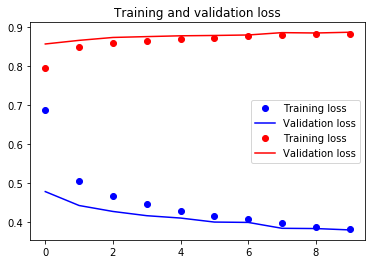

In [23]:
# 학습 loss, acc  확인 

loss = cae_train.history['loss']
val_loss = cae_train.history['val_loss']
acc = cae_train.history['acc']
val_acc = cae_train.history['val_acc']
epochs = range (epoch)
plt.figure()
plt.plot(epochs, loss,'bo', label = 'Training loss')
plt.plot(epochs, val_loss, 'b',label = 'Validation loss')
plt.plot(epochs, acc,'ro', label = 'Training loss')
plt.plot(epochs, val_acc, 'r',label = 'Validation loss')

plt.title('Training and validation loss')
plt.legend()
plt.show()

In [27]:
# evaluate test dataset
eval = CAE_Class.evaluate(x_test_noisy , test_labels_categorical, verbose= 1)
print('Test loss;', eval[0])
print('Test Accuracy', eval[1])

   32/10000 [..............................] - ETA: 7s

  128/10000 [..............................] - ETA: 6s

  224/10000 [..............................] - ETA: 6s

  320/10000 [..............................] - ETA: 6s

  416/10000 [>.............................] - ETA: 6s

  480/10000 [>.............................] - ETA: 6s

  576/10000 [>.............................] - ETA: 6s

  640/10000 [>.............................] - ETA: 6s

  704/10000 [=>............................] - ETA: 6s

  800/10000 [=>............................] - ETA: 6s

  896/10000 [=>............................] - ETA: 6s

  992/10000 [=>............................] - ETA: 6s

 1088/10000 [==>...........................] - ETA: 6s

 1120/10000 [==>...........................] - ETA: 6s

 1184/10000 [==>...........................] - ETA: 6s

 1280/10000 [==>...........................] - ETA: 6s

 1376/10000 [===>..........................] - ETA: 6s

 1440/10000 [===>..........................] - ETA: 6s

 1536/10000 [===>..........................] - ETA: 6s

 1632/10000 [===>..........................] - ETA: 6s

 1728/10000 [====>.........................] - ETA: 6s

 1824/10000 [====>.........................] - ETA: 6s

 1920/10000 [====>.........................] - ETA: 6s

 2016/10000 [=====>........................] - ETA: 5s

 2112/10000 [=====>........................] - ETA: 5s

 2208/10000 [=====>........................] - ETA: 5s

 2304/10000 [=====>........................] - ETA: 5s

 2400/10000 [======>.......................] - ETA: 5s

 2496/10000 [======>.......................] - ETA: 5s

 2592/10000 [======>.......................] - ETA: 5s

 2688/10000 [=======>......................] - ETA: 5s

 2784/10000 [=======>......................] - ETA: 5s

 2880/10000 [=======>......................] - ETA: 5s

 2976/10000 [=======>......................] - ETA: 4s

 3072/10000 [========>.....................] - ETA: 4s

 3168/10000 [========>.....................] - ETA: 4s

 3264/10000 [========>.....................] - ETA: 4s

 3360/10000 [=========>....................] - ETA: 4s

 3456/10000 [=========>....................] - ETA: 4s

 3552/10000 [=========>....................] - ETA: 4s

 3648/10000 [=========>....................] - ETA: 4s

 3744/10000 [==========>...................] - ETA: 4s

 3840/10000 [==========>...................] - ETA: 4s

 3936/10000 [==========>...................] - ETA: 4s

 4032/10000 [===========>..................] - ETA: 4s

 4128/10000 [===========>..................] - ETA: 3s

 4224/10000 [===========>..................] - ETA: 3s

 4320/10000 [===========>..................] - ETA: 3s

 4416/10000 [============>.................] - ETA: 3s

 4512/10000 [============>.................] - ETA: 3s

 4608/10000 [============>.................] - ETA: 3s

 4704/10000 [=============>................] - ETA: 3s

 4800/10000 [=============>................] - ETA: 3s

 4896/10000 [=============>................] - ETA: 3s

 4992/10000 [=============>................] - ETA: 3s

 5088/10000 [==============>...............] - ETA: 3s

 5184/10000 [==============>...............] - ETA: 3s

 5280/10000 [==============>...............] - ETA: 3s

 5376/10000 [===============>..............] - ETA: 3s

 5472/10000 [===============>..............] - ETA: 2s

 5568/10000 [===============>..............] - ETA: 2s

 5664/10000 [===============>..............] - ETA: 2s

 5760/10000 [================>.............] - ETA: 2s

 5856/10000 [================>.............] - ETA: 2s

 5952/10000 [================>.............] - ETA: 2s

 6048/10000 [=================>............] - ETA: 2s

 6144/10000 [=================>............] - ETA: 2s

 6240/10000 [=================>............] - ETA: 2s

 6336/10000 [==================>...........] - ETA: 2s

 6432/10000 [==================>...........] - ETA: 2s

 6528/10000 [==================>...........] - ETA: 2s

 6624/10000 [==================>...........] - ETA: 2s

 6720/10000 [===================>..........] - ETA: 2s

 6816/10000 [===================>..........] - ETA: 2s

 6912/10000 [===================>..........] - ETA: 1s

 7008/10000 [====================>.........] - ETA: 1s

 7104/10000 [====================>.........] - ETA: 1s

 7200/10000 [====================>.........] - ETA: 1s

 7296/10000 [====================>.........] - ETA: 1s

 7392/10000 [=====================>........] - ETA: 1s

 7488/10000 [=====================>........] - ETA: 1s

 7584/10000 [=====================>........] - ETA: 1s

 7680/10000 [======================>.......] - ETA: 1s

 7776/10000 [======================>.......] - ETA: 1s

 7872/10000 [======================>.......] - ETA: 1s

 7968/10000 [======================>.......] - ETA: 1s

 8064/10000 [=======================>......] - ETA: 1s

 8160/10000 [=======================>......] - ETA: 1s

 8256/10000 [=======================>......] - ETA: 1s

 8352/10000 [========================>.....] - ETA: 1s

 8448/10000 [========================>.....] - ETA: 0s

 8544/10000 [========================>.....] - ETA: 0s

 8640/10000 [========================>.....] - ETA: 0s

 8736/10000 [=========================>....] - ETA: 0s

 8832/10000 [=========================>....] - ETA: 0s

 8928/10000 [=========================>....] - ETA: 0s

 9024/10000 [==========================>...] - ETA: 0s

 9120/10000 [==========================>...] - ETA: 0s

 9216/10000 [==========================>...] - ETA: 0s

 9312/10000 [==========================>...] - ETA: 0s

 9408/10000 [===========================>..] - ETA: 0s

 9504/10000 [===========================>..] - ETA: 0s

 9600/10000 [===========================>..] - ETA: 0s

 9696/10000 [============================>.] - ETA: 0s

 9792/10000 [============================>.] - ETA: 0s

 9888/10000 [============================>.] - ETA: 0s

 9984/10000 [============================>.] - ETA: 0s

10000/10000 [==============================] - 6s 627us/step


Test loss; 0.28930010747909546


Test Accuracy 0.9131


Test images


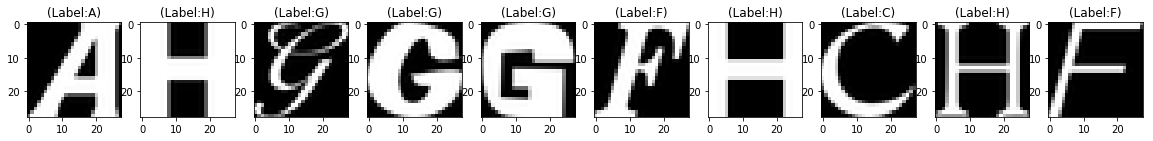

Test images with Noise


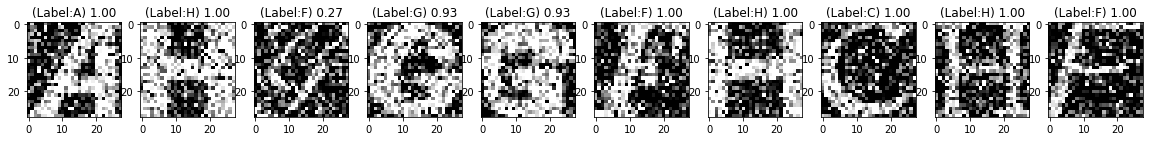

In [101]:
# predict test dataset
# pred = CAE_Class.predict(x_test_noisy[,...,])


plt.figure(figsize=(20,4))
print("Test images")
for i in range(10,20,1):
    plt.subplot(2, 10, i+1)
    plt.imshow(test_data[i,...,0], cmap='gray')
    curr_lbl = test_labels[i]
    plt.title("(Label:"+str(label_dict[curr_lbl])+")")
plt.show()

plt.figure(figsize=(20,4))
print("Test images with Noise")
for i in range(10,20,1):
    plt.subplot(2,10,i+1)
    plt.imshow(x_test_noisy[i,...,0],cmap='gray')
    x= x_test_noisy[i,...,]
    x = x.reshape((1,)+x.shape)
    pred_lbl = CAE_Class.predict(x)
    classes = np.argmax(pred_lbl)
    # print("%.2f"%list(pred_lbl)[0][classes])
    # print("%.2f"%pred_lbl(classes)])
    plt.title("(Label:"+str(label_dict[classes])+")"+" %.2f"%list(pred_lbl)[0][classes])
plt.show()


In [24]:
CAE_Class.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_9 (InputLayer)         (None, 28, 28, 1)         0         
_________________________________________________________________
conv1 (Conv2D)               (None, 28, 28, 32)        320       
_________________________________________________________________
pool1 (MaxPooling2D)         (None, 14, 14, 32)        0         
_________________________________________________________________
conv2 (Conv2D)               (None, 14, 14, 64)        18496     
_________________________________________________________________
pool2 (MaxPooling2D)         (None, 7, 7, 64)          0         
_________________________________________________________________
conv3 (Conv2D)               (None, 7, 7, 128)         73856     
_________________________________________________________________
pool3 (MaxPooling2D)         (None, 3, 3, 128)         0         
__________